**🎓 Analyse exploratoire des données de systèmes éducatifs**

<p style="font-size:1rem">L'entreprise, "academy", un start-up de la EdTech, propose des contenus de formation en ligne pour un public de niveau lycée et université.</p>


<p class="h1" style="font-size:1.5rem">Table de matières</p><a name="toc"></a>

1. [Compréhension du mission](#mission)
   1. [Objectifs commerciaux](#mission)
   1. [Déclaration comme questions d'analyse](#mission)
   1. [Objectifs d'analyse](#mission)
2. [Compréhension des données](#donnees)
   1. [Configuration du workspace](#donnees-configuration)
   1. [Chargement des données](#donnees-chargement)
   1. [Déscription des fichiers](#donnees-description)
   1. [Validation de la qualité des données](#donnees-validation)
3. [Préparation des données](#preparation)
   1. [Nettoyage](#preparation-nettoyage)
   1. [Critères de sélection](#preparation-selection)
   1. [Chercher des indicateurs](#preparation-recherche)
   1. [Pré-sélection des indicateurs (long list)](#preparation-selection)
   1. [Sélection des indicateurs (short list)](#preparation-shortlist)
4. [Analyse exploratoire](#analyse)
   1. [Sélectionne des données 2015 / 2010 à utiliser pour l'analyse](#analyse-selectionne)
   1. [Analyse par région et income group](#analyse-region)
   1. [Corrélations par Income Group](#analyse-income)
   1. [Top pays pour chaque indicateur](#analyse-top-pays)
5. [Conclusion](#conclusion)
   1. [Quel Pays ont une fort potentiel?](#conclusion)
   1. [Evolution de ces pays?](#conclusion-evolution)
   1. [Dans quel pays opérer en priorité ?](#conclusion-priorite)


# 1. 📄 Compréhension du problème (mission)<a name="mission"></a>

## 1.1 Mission

- Déterminer si [les données sur l’éducation de la banque mondiale](https://datacatalog.worldbank.org/dataset/education-statistics) permettent
  d’informer le projet d’expansion à l’international de l’entreprise

## 1.2 Les objectifs commerciaux

- Quels sont les pays avec un fort potentiel de clients pour nos services ?
- Pour chacun de ces pays, quelle sera l’évolution de ce potentiel de clients ?
- Dans quels pays l'entreprise doit-elle opérer en priorité ?

## 1.3 Déclaration du problème comme questions d'analyse

Est-ce que ces données peuvent nous aider à discriminer dans quels pays :

- on peut vendre le maximum quantité de cours (e-learning via internet),
- avec le maximum prix,
- à un certain secteur de la population (secteur tertiaire, BAC+, 18-25 ans ?),
- pour faire le maximum du profit (= nombre de clients \* prix de vente - dépenses)

Doubt: Maximiser le revenu total, ou maximiser le revenu par 1000 habitants (par exemple)

## 1.4 Les objectifs de l'analyse pré-exploratoire

- Décrire les informations contenues dans le jeu de données
- Valider la qualité de ce jeu de données
- Sélectionner les informations qui semblent pertinentes pour répondre à la problématique
- Déterminer des ordres de grandeurs des indicateurs statistiques classiques pour les différentes zones géographiques et pays du monde


---

# 2. 📦 Compréhension des données<a name="donnees"></a>


[🔝](#toc)
- 2.1 Préparation des outils

- 2.2 Téléchargement et extraire les données

- 2.3 Description des contenus des fichiers de données

- 2.4 Evaluation de la qualité des données


## 📌 2.1 CONFIGURATION des outils<a name="donnees-configuration"></a>

### 2.1.1 Installer les bibliothèques nécessaires pour manipuler les données


In [1]:
import subprocess
# https://stackoverflow.com/questions/44210656/how-to-check-if-a-module-is-installed-in-python-and-if-not-install-it
import sys

import pkg_resources

required = {'numpy', 'pandas', 'matplotlib', 'seaborn', 'missingno', 'plotly'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
print('required modules: ', required)
print('missing modules: ', missing)

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)


required modules:  {'numpy', 'matplotlib', 'plotly', 'pandas', 'seaborn', 'missingno'}
missing modules:  set()


#### Installation plotly >= 4.5.0

Plotly >=4.5.0 est utilisé pour afficher des choropleths (cartes des pays)
- enleve la commentaire (#) dans le code ci-dessous pour mettre à jour plotly si besoin
- il faut rédemarrer le runtime pour prendre en compte la nouvelle version

In [2]:
#!pip install plotly --upgrade 

### 2.1.2 Importer les bibliothèques nécessaires pour manipuler les données


In [3]:
# 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import plotly.express as px # il faut plotly version >= 4.5.0 pour visualiser un choropleth d'une variable catégorique 

### 2.1.3 Configuration défauts d'affichage


In [4]:
pd.set_option('display.max_columns', 100)  # pour afficher toutes les colonnes
pd.set_option('display.max_colwidth', 100)

%matplotlib inline

sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")


### 2.1.4 Liste des versions des librairies utilisés


In [5]:
!python --version
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))


Python 3.9.6
pandas==1.3.2
numpy==1.20.3
seaborn==0.11.2
missingno==0.5.0


## 📌 2.2 CHARGEMENT et extraction des données


In [6]:
# Télécharger les données s'ils ne sont pas déjà téléchargés
import zipfile
from urllib import request
import os

# DATA_URL="https://databank.worldbank.org/data/download/Edstats_csv.zip"
DATA_URL = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Donn%C3%A9es+%C3%A9ducatives/Projet+Python_Dataset_Edstats_csv.zip"
DOSSIER = 'data/raw'  # dossier ou en met les données
if not os.path.exists(DOSSIER):
    os.makedirs(DOSSIER)
FICHIER_LOCAL = DOSSIER + '/' + DATA_URL.split('/')[-1]

# download with progress bar (platform independent)
# https://github.com/tqdm/tqdm/blob/master/examples/tqdm_wget.py

if os.path.exists(FICHIER_LOCAL):
    print(f'{FICHIER_LOCAL} déjà téléchargé')
else:
    try:
        import tqdm  # exception if not installed

        class TqdmUpTo(tqdm.tqdm):
            def update_to(self, b=1, bsize=1, tsize=None):
                if tsize is not None:
                    self.total = tsize
                return self.update(b * bsize - self.n)

        with TqdmUpTo(unit='B', unit_scale=True, unit_divisor=1024, miniters=1,
                      desc=FICHIER_LOCAL) as t:  # all optional kwargs
            request.urlretrieve(
                url=DATA_URL, filename=FICHIER_LOCAL, reporthook=t.update_to, data=None)
            t.total = t.n
    except ImportError:
        tqdm = None
        request.urlretrieve(
            url=DATA_URL, filename=FICHIER_LOCAL, reporthook=None, data=None)

# extract contenu du fichier zip vers le DOSSIER 'data'
# https://thispointer.com/python-how-to-unzip-a-file-extract-single-multiple-or-all-files-from-a-zip-archive/

zipfile.ZipFile(FICHIER_LOCAL, 'r').extractall(DOSSIER)
raw_data_files = list(
    filter(lambda f: not f.endswith('.zip'), os.listdir(DOSSIER)))
print(f'raw_data_files : {raw_data_files}')


data/raw/Projet+Python_Dataset_Edstats_csv.zip: 100%|██████████| 37.1M/37.1M [00:38<00:00, 1.02MB/s]


raw_data_files : ['EdStatsCountry-Series.csv', 'EdStatsCountry.csv', 'EdStatsData.csv', 'EdStatsFootNote.csv', 'EdStatsSeries.csv']


---

## 📌 2.3 DESCRIPTION des informations contenus dans les fichiers de données<a name="donnees-description"></a>

[🔝](#toc)

Il y a 5 fichiers de données téléchargés :

- 🟦 EdStatsSeries.csv
- 🟪 EdStatsCountry-Series.csv
- 🟨 EdStatsCountry.csv
- 🟧 EdStatsData.csv
- 🟩 EdStatsFootNote.csv

Pour chaque fichier :

- description du fichier
- nombre de colonnes et registres
- noms, description et types des champs qui semble pertinentes


### **Note sur les noms de variables / fonctions utilisées dans ce notebook**

**Prefixes**

- `raw_` : des données originales
- `supprime_`: fonction qui supprime des lignes
- `drop_`: fonction qui supprime les colonnes

Utilisation de fonctions pour n'accumule pas des variables/données en memoire


---

### 2.3.1 🟦 Description: "EdStatsSeries.csv"


Chargement du fichier `Series` et affichage des 3 premières lignes du dataframe pour vérifier que les données sont bien chargées.


In [7]:
raw_series_df = pd.read_csv(
    f'{DOSSIER}/EdStatsSeries.csv', sep=',', encoding='UTF-8')
raw_series_df.head(3)


,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,Limitations and exceptions,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
0,BAR.NOED.1519.FE.ZS,Attainment,Barro-Lee: Percentage of female population age 15-19 with no education,Percentage of female population age 15-19 with no education,Percentage of female population age 15-19 with no education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.barrolee.com/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAR.NOED.1519.ZS,Attainment,Barro-Lee: Percentage of population age 15-19 with no education,Percentage of population age 15-19 with no education,Percentage of population age 15-19 with no education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.barrolee.com/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAR.NOED.15UP.FE.ZS,Attainment,Barro-Lee: Percentage of female population age 15+ with no education,Percentage of female population age 15+ with no education,Percentage of female population age 15+ with no education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.barrolee.com/,NaN,NaN,NaN,NaN,NaN,NaN,NaN


❔ Combien de lignes et colonnes

- il y beaucoup de colonnes, on utilise info() avec paramètre `verbose=False`


In [8]:
raw_series_df.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Columns: 21 entries, Series Code to Unnamed: 20
dtypes: float64(6), object(15)
memory usage: 601.4+ KB


❔ Quelle sont les types des colonnes


In [9]:
raw_series_df.dtypes


Series Code                             object
Topic                                   object
Indicator Name                          object
Short definition                        object
Long definition                         object
Unit of measure                        float64
Periodicity                             object
Base Period                             object
Other notes                             object
Aggregation method                      object
Limitations and exceptions              object
Notes from original source             float64
General comments                        object
Source                                  object
Statistical concept and methodology     object
Development relevance                   object
Related source links                    object
Other web links                        float64
Related indicators                     float64
License Type                           float64
Unnamed: 20                            float64
dtype: object

❔ Les colonnes identifiées comme numériques (float64) sont étranges :

- on attend du text dans les colonnes `['Unit of measure', 'Notes from original source', 'Other web links', 'Related indicators', 'Licence Type' ]`

Décrire les colonnes numériques


In [10]:
raw_series_df.describe(include="float64")


,Unit of measure,Notes from original source,Other web links,Related indicators,License Type,Unnamed: 20
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN


Explication des colonnes numériques étranges

- Les 6 colonnes `['Unit of measure', 'Notes from original source', 'Other web links', 'Related indicators', 'Licence Type', 'Unnamed: 20' ]` sont toutes vides.
- comme il n'y a pas de données, pandas.read_csv() est incapable de déterminer leurs types de données.


#### 2.3.3.1 Sommaire description du fichier `EdStatSeries.csv`

- Le fichier contient 3665 series, décrire par 21 colonnes
- 6 colonnes sont complétement vides
- Le [site de téléchargement des données du world bank](https://datacatalog.worldbank.org/search/dataset/0038480/Education-Statistics), ne fourni pas des definitions (meta data) des colonnes


---

### 2.3.2 🟪 Description "EdStatsCountry-Series.csv"


Chargement du fichier `Country-Series` et affichage des 3 premières lignes du dataframe pour vérifier que les données sont bien chargées.


In [11]:
raw_country_series_df = pd.read_csv(
    f'{DOSSIER}/EdStatsCountry-Series.csv', sep=',', encoding='UTF-8')
raw_country_series_df.head(3)


,CountryCode,SeriesCode,DESCRIPTION,Unnamed: 3
0,ABW,SP.POP.TOTL,Data sources : United Nations World Population Prospects,NaN
1,ABW,SP.POP.GROW,Data sources: United Nations World Population Prospects,NaN
2,AFG,SP.POP.GROW,Data sources: United Nations World Population Prospects,NaN


❔ Combien de lignes et colonnes

On voit qu'il y a seulement 4 colonnes, donc on met `verbose=True` pour répondre aux même temps aux questions

- ❔ Quelle sont les types des colonnes
- ❔ Est-ce qu'il y a des colonnes sans données


In [12]:
raw_country_series_df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryCode  613 non-null    object 
 1   SeriesCode   613 non-null    object 
 2   DESCRIPTION  613 non-null    object 
 3   Unnamed: 3   0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 19.3+ KB


❔ Combien de séries uniques sont représentés

- 613 lignes pour 242 pays, donc peut-être seulement 3 series


In [13]:
raw_country_series_df['SeriesCode'].unique()


array(['SP.POP.TOTL', 'SP.POP.GROW', 'NY.GDP.PCAP.PP.CD',
       'NY.GDP.MKTP.PP.KD', 'NY.GNP.MKTP.PP.CD', 'NY.GDP.MKTP.PP.CD',
       'NY.GDP.PCAP.PP.KD', 'NY.GNP.PCAP.PP.CD', 'SP.POP.1564.TO.ZS',
       'SP.POP.TOTL.MA.ZS', 'SP.POP.TOTL.FE.ZS', 'SP.POP.0014.TO.ZS',
       'NY.GNP.PCAP.CD', 'NY.GDP.PCAP.CD', 'NY.GDP.PCAP.KD',
       'SP.POP.1564.MA.IN', 'SP.POP.0014.TO', 'SP.POP.1564.TO',
       'SP.POP.1564.FE.IN', 'SP.POP.0014.MA.IN', 'SP.POP.0014.FE.IN'],
      dtype=object)

#### Sommaire description du fichier `EdStatCountry-Series.csv`

- contient une 613 lignes, chacun avec une description d'une série de populations (POP), GDP ou GNP pour un pays
- la colonne `description` semble fourni la source des données pour une série pour un pays
- aucune donnée dans colonne `Unnamed: 3`
- Le site du [world bank](https://datacatalog.worldbank.org/search/dataset/0038480/Education-Statistics) ne fourni pas de metadata sur les colonnes`


---

### 2.3.3 🟨 Description "EdStatsCountry.csv"


Chargement du fichier `Country` et affichage des 3 premières lignes du dataframe pour vérifier que les données sont bien chargées.


In [14]:
raw_country_df = pd.read_csv(
    f'{DOSSIER}/EdStatsCountry.csv', sep=',', encoding='UTF-8')
raw_country_df.head(3)


,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,National accounts base year,National accounts reference year,SNA price valuation,Lending category,Other groups,System of National Accounts,Alternative conversion factor,PPP survey year,Balance of Payments Manual in use,External debt Reporting status,System of trade,Government Accounting concept,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,Unnamed: 31
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,SNA data for 2000-2011 are updated from official government statistics; 1994-1999 from UN databa...,Latin America & Caribbean,High income: nonOECD,AW,2000,NaN,Value added at basic prices (VAB),NaN,NaN,Country uses the 1993 System of National Accounts methodology.,NaN,NaN,"IMF Balance of Payments Manual, 6th edition.",NaN,Special trade system,NaN,NaN,2010,NaN,NaN,Yes,NaN,NaN,2012.0,NaN,NaN
1,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period for national accounts data: FY (from 2013 are CY). N...,South Asia,Low income,AF,2002/03,NaN,Value added at basic prices (VAB),IDA,HIPC,Country uses the 1993 System of National Accounts methodology.,NaN,NaN,NaN,Actual,General trade system,Consolidated central government,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2012.0,2000,NaN
2,AGO,Angola,Angola,People's Republic of Angola,AO,Angolan kwanza,"April 2013 database update: Based on IMF data, national accounts data were revised for 2000 onwa...",Sub-Saharan Africa,Upper middle income,AO,2002,NaN,Value added at producer prices (VAP),IBRD,NaN,Country uses the 1993 System of National Accounts methodology.,1991–96,2005,"IMF Balance of Payments Manual, 6th edition.",Actual,Special trade system,Budgetary central government,General Data Dissemination System (GDDS),1970,"Malaria Indicator Survey (MIS), 2011","Integrated household survey (IHS), 2008",NaN,2015,NaN,NaN,2005,NaN


❔ Combien de lignes et colonnes

- il y beaucoup de colonnes, on utilise paramètre `verbose=False`


In [15]:
raw_country_df.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Columns: 32 entries, Country Code to Unnamed: 31
dtypes: float64(4), object(28)
memory usage: 60.4+ KB


❔ Quelle sont les types des colonnes

- 4 sont float64, 28 colonnes sont objet

❔ Les colonnes type `float`:


In [16]:
list(raw_country_df.select_dtypes(include=['float64']).columns)


['National accounts reference year',
 'Latest industrial data',
 'Latest trade data',
 'Unnamed: 31']

❔ Est-ce que certaines colonnes sont du type catégorie (peu de valeurs uniques)


In [17]:
raw_country_df.nunique()


Country Code                                         241
Short Name                                           241
Table Name                                           241
Long Name                                            241
2-alpha code                                         238
Currency Unit                                        152
Special Notes                                        131
Region                                                 7
Income Group                                           5
WB-2 code                                            240
National accounts base year                           43
National accounts reference year                      11
SNA price valuation                                    2
Lending category                                       3
Other groups                                           2
System of National Accounts                            3
Alternative conversion factor                         32
PPP survey year                

#### Sommaire description du fichier `EdStatCountry.csv`

- contient 241 lignes et 32 colonnes
- Chaque ligne represent un pays (ou groupe de pays, car il n'y a pas 241 pays dans le monde)
- plusieurs colonnes possibles pour catégoriser et grouper les pays (Region, Income Group, Lending Category, Currency...)
- aucune donnée dans colonne `Unnamed: 31`
- Le site du [world bank](https://datacatalog.worldbank.org/search/dataset/0038480/Education-Statistics) ne fourni pas de metadata sur les colonnes`


---

### 2.3.4 🟧 Description "EdStatsData.csv"


Chargement du fichier `Data` et affichage des 3 premières lignes du dataframe pour vérifier que les données sont bien chargées.


In [18]:
raw_data_df = pd.read_csv(
    f'{DOSSIER}/EdStatsData.csv', sep=',', encoding='UTF-8')
# raw_data_df.style.set_sticky(axis="index")
raw_data_df.head(3)


,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, female (%)",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, gender parity index (GPI)",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


❔ Combien de lignes et colonnes

- il y beaucoup de colonnes, on utilise info() avec parametre `verbose=False`


In [19]:
raw_data_df.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886930 entries, 0 to 886929
Columns: 70 entries, Country Name to Unnamed: 69
dtypes: float64(66), object(4)
memory usage: 473.7+ MB


❔ Quelle sont les types des colonnes


In [20]:
raw_data_df.dtypes


Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1970              float64
                   ...   
2085              float64
2090              float64
2095              float64
2100              float64
Unnamed: 69       float64
Length: 70, dtype: object

❔ Les noms des colonnes


In [21]:
raw_data_df.columns


Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045',
       '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090',
       '2095', '2100', 'Unnamed: 69'],
      dtype='object')

❔ Combien de valeurs uniques dans chaque colonne


In [22]:
raw_data_df.nunique()


Country Name        242
Country Code        242
Indicator Name     3665
Indicator Code     3665
1970              24595
                  ...  
2085               7335
2090               7150
2095               7044
2100               6914
Unnamed: 69           0
Length: 70, dtype: int64

#### Sommaire description du fichier `EdStatData.csv`

- Très grand fichier qui contient les data des indicateurs (886930 lignes, 70 colonnes)
- Seulement 4 colonnes textes, les autres colonnes représenter l'année
- Chaque ligne fournit une série temporale des valeurs d'un indicateur pour un pays
  - Il y a des colonnes pour chaque année 1970 à 2017
  - Pour les series dans le futur (des projections), il y une colonne pour chaque 5 ans, de 2020 à 2100
- La dernière colonne est vide


---

### 2.3.5 🟩 Description "EdStatsFootNote.csv"


Chargement du fichier `Data` et affichage des 3 premières lignes du dataframe pour vérifier que les données sont bien chargées.


In [23]:
raw_footnote_df = pd.read_csv(
    f'{DOSSIER}/EdStatsFootNote.csv', sep=',', encoding='UTF-8')
raw_footnote_df.head(3)


,CountryCode,SeriesCode,Year,DESCRIPTION,Unnamed: 4
0,ABW,SE.PRE.ENRL.FE,YR2001,Country estimation.,NaN
1,ABW,SE.TER.TCHR.FE,YR2005,Country estimation.,NaN
2,ABW,SE.PRE.TCHR.FE,YR2000,Country estimation.,NaN


❔ Combien de lignes et colonnes

- ❔ Quelle sont les types des colonnes
- ❔ Est-ce qu'il y a des colonnes vides


In [24]:
raw_footnote_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643638 entries, 0 to 643637
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CountryCode  643638 non-null  object 
 1   SeriesCode   643638 non-null  object 
 2   Year         643638 non-null  object 
 3   DESCRIPTION  643638 non-null  object 
 4   Unnamed: 4   0 non-null       float64
dtypes: float64(1), object(4)
memory usage: 24.6+ MB


❔ Nombre de valeurs uniques dans chaque colonne


In [25]:
raw_footnote_df.nunique()


CountryCode     239
SeriesCode     1558
Year             56
DESCRIPTION    9102
Unnamed: 4        0
dtype: int64

In [26]:
raw_footnote_df['Year'].unique()


array(['YR2001', 'YR2005', 'YR2000', 'YR2004', 'YR2006', 'YR2003',
       'YR1999', 'YR2008', 'YR2002', 'YR2007', 'YR2017', 'YR2010',
       'YR2009', 'YR2011', 'YR2012', 'YR2015', 'YR2014', 'YR1970',
       'YR1971', 'YR1972', 'YR1973', 'YR1974', 'YR1975', 'YR1976',
       'YR1977', 'YR1978', 'YR1979', 'YR1980', 'YR1981', 'YR1982',
       'YR1983', 'YR1984', 'YR1985', 'YR1986', 'YR1987', 'YR1988',
       'YR1989', 'YR1990', 'YR1991', 'YR1992', 'YR1993', 'YR1994',
       'YR1995', 'YR1996', 'YR1997', 'YR1998', 'YR2013', 'YR2016',
       'YR2020', 'YR2025', 'YR2030', 'YR2035', 'YR2040', 'YR2045',
       'YR2050', 'yr2012'], dtype=object)

#### Sommaire description du fichier `EdStatFootNote.csv`

- 643638 lignes sur 5 colonnes ou la dernière colonne est vide
- Les premiers deux colonnes référencent une ligne dans le `Data` (_EdStatData.csv_)
- La troisième colonne référence une colonne dans le `Data`
- Donc une ligne de footnote fait référence à un point de données
- La quatrième colonne contient le footnote pour un indicateur pour un pays et année.


---

## 📌 2.4 VALIDATION de la qualité des données<a name="donnees-validation"></a>

[🔝](#toc)

1. 🟦🔵 Qualité de "EdStatsSeries.csv"
2. 🟪🟣 Qualité de "EdStatsCountry-Series.csv"
3. 🟨🟡 Qualité de "EdStatsCountry.csv"
4. 🟧🟠 Qualité de "EdStatsData.csv"
5. 🟩🟢 Qualité de "EdStatsFootNote.csv"

Pour chaque fichier

- pertinence de chaque fichier au projet
- pertinence des colonnes au projet (champs)
- pertinence des registres au projet
- données manquantes
- données dupliquées
- uniformité des données
- outliers


#### Fonctions auxiliaires pour décrire un dataframe


In [27]:
def max_len_colonnes(df: pd.DataFrame):
    """
    Retourne la largeur maximum des colonnes text d'un dataframe - aide à valider l'uniformité des clés et autres données
    """
    mesurer = np.vectorize(len)
    max_df = pd.DataFrame(columns=['column', 'max_len'])
    for col in df.columns:
        if df[col].dtype == 'object':
            uniq = df[col].unique()
            max_len = mesurer(uniq.astype(str)).max(axis=0)
            max_df = max_df.append(
                {'column': col, 'max_len': max_len}, ignore_index=True)
    max_df = max_df.set_index('column')
    return max_df


def decrire_dataframe(df: pd.DataFrame):
    """
    Retourner un dataframe avec des informations sur les colonnes d'un dataframe
    """
    ret = df.columns.to_frame(name="column").set_index('column')
    ret['count'] = df.notnull().sum()
    ret['unique'] = df.nunique()
    ret['dtype'] = df.dtypes
    ret['max_length'] = max_len_colonnes(df)
    return ret


def is_zero(cell_value, color='pink'):
    """
    style pour souligné une valeur
    example use:
    df.style.applymap(is_zero,subset=["my_col"],color='red')
    """
    return f'background-color: {color};' if cell_value == 0 else None


#### Fonctions pour compter / afficher les not nulls (ou autre critère)


In [28]:
def not_nulls(df):
    ret = df.notnull().sum().to_frame(name='count').rename_axis('column').reset_index()
    return ret


def plot_not_null(df, titre='nombre de valeurs not null', figsize=None, orient='h'):
    """affiche un bar plot avec le nombre de valeurs not null"""

    _, ax = plt.subplots(figsize=figsize)

    if orient == 'h':
        ax1 = sns.barplot(ax=ax, y=df.columns,
                          x=df.notnull().sum(), orient='h')
        ax1.set(ylabel="colonne", xlabel='count not null')
        ax1.xaxis.grid()
    else:
        ax1 = sns.barplot(ax=ax, x=df.columns,
                          y=df.notnull().sum(), orient='v')
        plt.xticks(rotation=90)
        ax1.set(xlabel="colonne", ylabel='count not null')
        # ax1.yaxis.grid()

    ax1.set_title(titre)
    sns.despine()
    ax1.plot()
    return ax1


#### Fonctions pour compter la fréquence des mots


In [29]:
from collections import Counter


def most_common_words(labels, num=100):
    words = []
    for lab in labels:
        words += lab.split(" ")
    counter = Counter(words)
    return counter.most_common(num)


def common_word_count(labels, num=100):
    c = most_common_words(labels, num=num)
    sans_interet = 'of,and,it,(%),in,to,with,by,for,who,are,the,-'.split(',')
    ret = pd.DataFrame.from_records(c, columns=['word', 'count'])
    filtre = ret['word'].isin(sans_interet)
    ret = ret[~filtre]
    return ret


---

### 2.4.1 🟦🔵 Qualité de "EdStatsSeries.csv"


❔ Existe-t-il des valeurs manquantes dans ce jeu de données ?
❔ Combien de valeurs uniques dans chaque colonne


In [30]:
(decrire_dataframe(raw_series_df).reset_index().style
    .bar(axis='index', subset=['count'], color='lightgreen')
    .applymap(is_zero, subset=['count', 'unique'], color='pink'))


,column,count,unique,dtype,max_length
0,Series Code,3665,3665,object,30
1,Topic,3665,37,object,92
2,Indicator Name,3665,3665,object,162
3,Short definition,2156,1169,object,2192
4,Long definition,3665,2060,object,2192
5,Unit of measure,0,0,float64,nan
6,Periodicity,99,1,object,6
7,Base Period,314,4,object,26
8,Other notes,552,14,object,39
9,Aggregation method,47,3,object,16


Seulement colonnes `['Series Code', 'Topic', 'Indicator Name', 'Short definition','Long definition', 'Source']` sont bien remplis


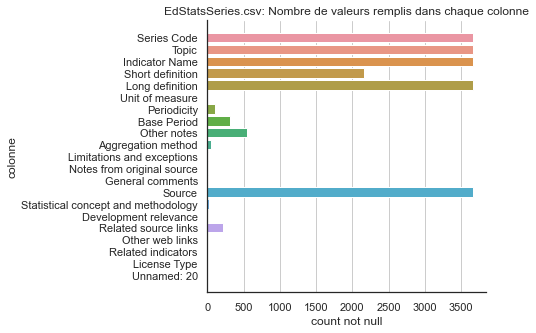

In [31]:
plot_not_null(raw_series_df,  figsize=(
    5, 5), titre='EdStatsSeries.csv: Nombre de valeurs remplis dans chaque colonne');


❔ Existe-t-il des duplicatas ?


In [32]:
raw_series_df.duplicated(subset=['Series Code']).sum()


0

✂ Supprime les colonnes sans données


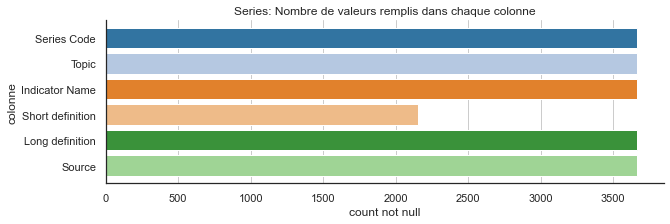

In [33]:
use_colonnes = ['Series Code', 'Topic', 'Indicator Name',
                'Short definition', 'Long definition', 'Source']


plot_not_null(raw_series_df.loc[:, use_colonnes], orient='h', figsize=(
    10, 3), titre='Series: Nombre de valeurs remplis dans chaque colonne');


❔ Quel sont les sujets (indicateurs) traités par chaque Topic ?


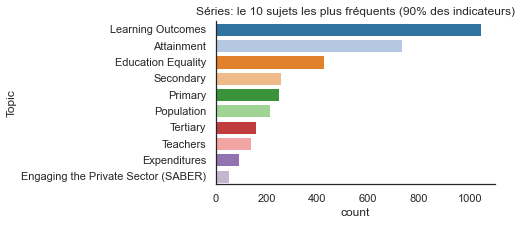

In [34]:
def plot_topic_counts(df):
    _, ax = plt.subplots(figsize=(5, 3))
    topics = df[['Topic']].value_counts().head(10).reset_index(name='count')
    sns.barplot(ax=ax, y=topics['Topic'], x=topics['count'], orient='h')
    ax.set_title('Séries: le 10 sujets les plus fréquents (90% des indicateurs)')
    sns.despine()


plot_topic_counts(raw_series_df)


❔ Quel sont les mots plus associés aux 10 plus grands topics


In [35]:
def print_topic_words(df_series):
    topics = df_series[['Topic']].value_counts().reset_index(name='count')
    top10topics = '; '.join(topics.head(10)['Topic'].head(20).tolist())
    print(f'Top 10 Topics: {top10topics}')

    cumulpercent = round(topics.head(
        10)['count'].sum() / topics['count'].sum() * 100, 2)
    print(f'Top 10 Topics, percentage cumulative de series :{cumulpercent} %')

    words_df = common_word_count(df_series['Indicator Name'].values)
    words = ', '.join(words_df['word'].tolist())
    print(f'Tous les topics:\n{words}')

    for topic in topics.head(9)['Topic']:
        print('-------------------------------------------')
        filtre = raw_series_df['Topic'] == topic
        words_df = common_word_count(
            raw_series_df[filtre]['Indicator Name'].values, num=40).head(20)
        words = ', '.join(words_df['word'].tolist())
        print(f'{topic}:\n{words}')


print_topic_words(raw_series_df)


Top 10 Topics: Learning Outcomes; Attainment; Education Equality; Secondary; Primary; Population; Tertiary; Teachers; Expenditures; Engaging the Private Sector (SABER)
Top 10 Topics, percentage cumulative de series :91.71 %
Tous les topics:
age, Percentage, Grade, female, students, level, population, (%)., secondary, primary, EGRA:, grade, education,, Barro-Lee:, education, male, 2nd, both, sexes, Projection:, lower, educational, Female, Male, proficiency, attainment., Total, Level, highest, Reading, (number), tertiary, UIS:, schooling., Share, Policy, SABER:, Goal, total, a, years, Secondary., 1, rate,, Primary., attendance, 6th, Correct, Read, Per, Minute, (Mean)., Average, Completed, mathematics, Distribution, zero, score, Percentile, Score, Lever, from, Comprehension, Net, Population, rate, PASEC:, reading, 3rd, 2, Population,, 3, DHS:, Age, on, LLECE:, 4, Mean, Scores:, Quintile, schooling,, out-of-school, MICS:, general, secondary,, expenditure, rate., 5
-------------------------

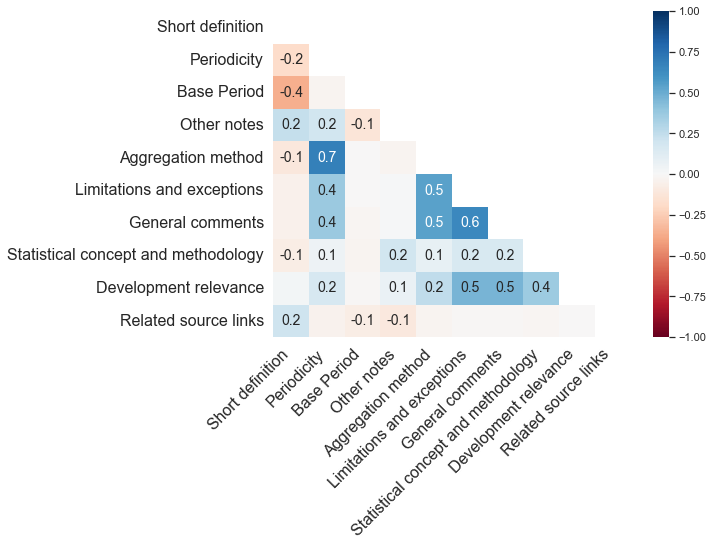

In [36]:
def plot_missing_heatmap(df, figsize=(8, 6)):
    _, ax = plt.subplots(figsize=figsize)
    msno.heatmap(df, ax=ax)


plot_missing_heatmap(raw_series_df)


<AxesSubplot:>

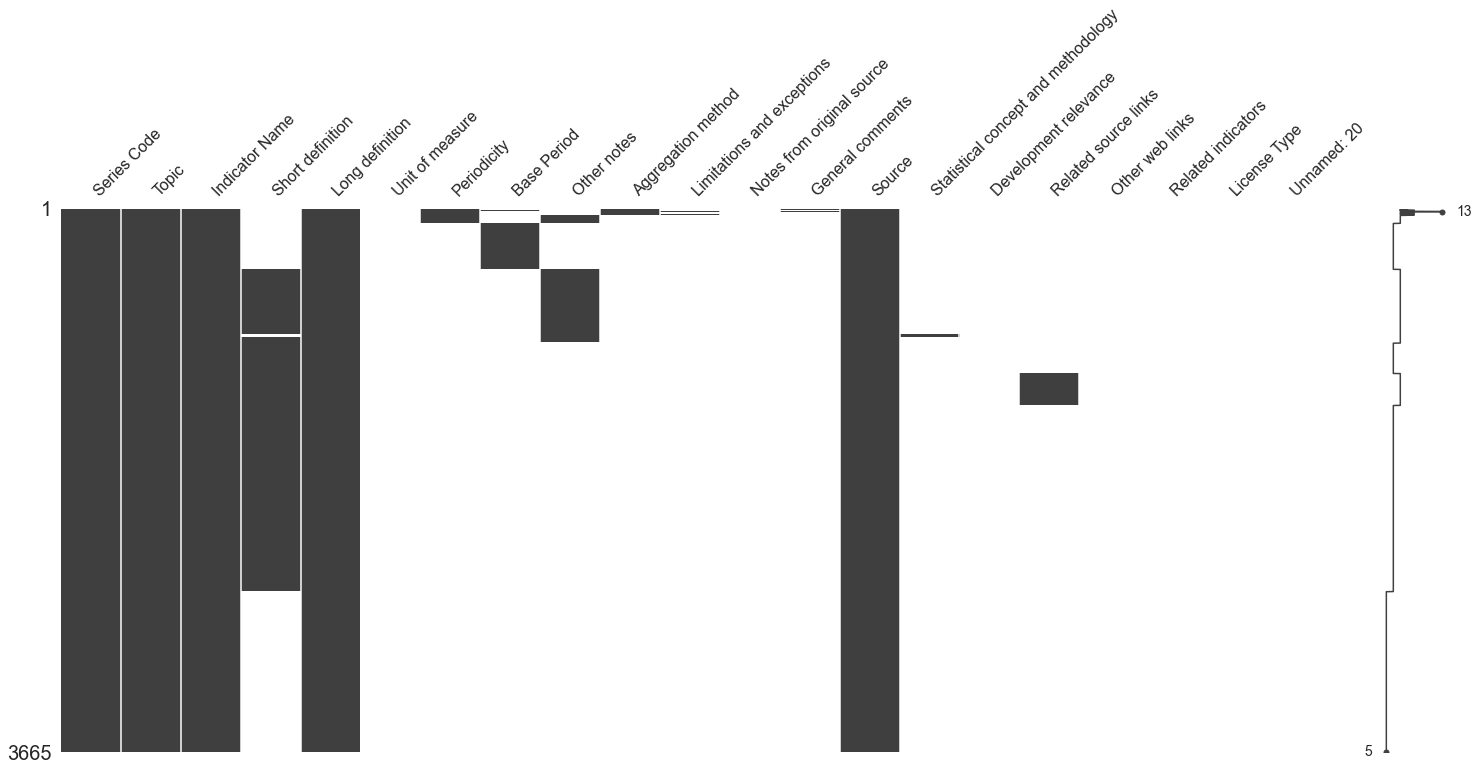

In [37]:
msno.matrix(
    raw_series_df.sort_values(['Aggregation method', 'Periodicity', 'Base Period', 'Other notes', 'Short definition']))


#### 2.4.1.1 Bilan qualité de "EdStatsSeries.csv"

Une table qui décrit 3665 indicateurs, en 21 colonnes

- seulement 5 colonnes sont complètement remplies
- 6 colonnes n'ont pas de données
- aucune des données dupliquées (clé primaire est `Series code`)
- Chaque série est attribuée à un de 37 "topics" très variés
- Les indicateurs provenant de 31 sources différents
- 90% des indicateurs tombe dans les 9 topics :
  - Learning Outcomes; Attainment; Education Equality; Secondary; Primary; Population; Tertiary; Teachers; Expenditures;


---

### 2.4.2 🟪🟣 Qualité de "EdStatsCountry-Series.csv"


❔ Existe-t-il des valeurs manquantes dans ce jeu de données ?
❔ Combien de valeurs uniques dans chaque colonne


In [38]:
(decrire_dataframe(raw_country_series_df).reset_index().style
    .bar(axis='index', subset=['count'], color='lightgreen')
    .applymap(is_zero, subset=['count', 'unique'], color='pink'))


,column,count,unique,dtype,max_length
0,CountryCode,613,211,object,3
1,SeriesCode,613,21,object,17
2,DESCRIPTION,613,97,object,278
3,Unnamed: 3,0,0,float64,nan


❔ Existe-t-il des duplicatas ?


In [39]:
raw_country_series_df.duplicated(subset=['CountryCode', 'SeriesCode']).sum()


0

❔ Combien de countries dans chaque série


In [40]:
raw_country_series_df['SeriesCode'].value_counts()


SP.POP.TOTL          211
SP.POP.GROW          211
NY.GDP.PCAP.PP.CD     19
NY.GDP.PCAP.PP.KD     19
NY.GNP.PCAP.PP.CD     19
NY.GDP.MKTP.PP.KD     14
NY.GNP.MKTP.PP.CD     14
NY.GDP.MKTP.PP.CD     14
SP.POP.0014.TO.ZS     13
SP.POP.TOTL.FE.ZS     13
SP.POP.TOTL.MA.ZS     13
SP.POP.1564.TO.ZS     13
NY.GNP.PCAP.CD         6
NY.GDP.PCAP.CD         5
NY.GDP.PCAP.KD         5
SP.POP.1564.MA.IN      4
SP.POP.0014.TO         4
SP.POP.1564.TO         4
SP.POP.1564.FE.IN      4
SP.POP.0014.MA.IN      4
SP.POP.0014.FE.IN      4
Name: SeriesCode, dtype: int64

❔ Quelle sont les pays dans les séries moins utilisées


In [41]:
filter_series_frequents = raw_country_series_df['SeriesCode'].isin(
    ['SP.POP.TOTL', 'SP.POP.GROW'])
rare_country_series_df = raw_country_series_df[~filter_series_frequents]
rare_country_series_df['SeriesCode'].value_counts()
rare_country_series_df.groupby(['SeriesCode']).agg(
    {'CountryCode': ['nunique', set]})


CountryCode  \
                      nunique   
SeriesCode                      
NY.GDP.MKTP.PP.CD          14   
NY.GDP.MKTP.PP.KD          14   
NY.GDP.PCAP.CD              5   
NY.GDP.PCAP.KD              5   
NY.GDP.PCAP.PP.CD          19   
NY.GDP.PCAP.PP.KD          19   
NY.GNP.MKTP.PP.CD          14   
NY.GNP.PCAP.CD              6   
NY.GNP.PCAP.PP.CD          19   
SP.POP.0014.FE.IN           4   
SP.POP.0014.MA.IN           4   
SP.POP.0014.TO              4   
SP.POP.0014.TO.ZS          13   
SP.POP.1564.FE.IN           4   
SP.POP.1564.MA.IN           4   
SP.POP.1564.TO              4   
SP.POP.1564.TO.ZS          13   
SP.POP.TOTL.FE.ZS          13   
SP.POP.TOTL.MA.ZS          13   

                                                                                                                    
                                                                                                               set  
SeriesCode                                                                                                          
NY.GDP.MKTP.PP.CD                           {ERI, AFG, LBY, SOM, SYR, TKM, TLS, UZB, XKX, SMR, GUY, PRI, LBN, ARG}  
NY.GDP.MKTP.PP.KD                           {ERI, AFG, LBY, SOM, SYR, TKM, TLS, UZB, XKX, SMR, GUY, PRI, LBN, ARG}  
NY.GDP.PCAP.CD                                                                           {MDA, CYP, GEO, TZA, MAR}  
NY.GDP.PCAP.KD                                                                           {MDA, CYP, GEO, TZA, MAR}  
NY.GDP.PCAP.PP.CD  {MDA, TLS, XKX, SOM, SMR, ARG, SYR, CYP, GUY, GEO, TZA, PRI, LBN, ERI, AFG, MAR, UZB, LBY, TKM}  
NY.GDP.PCAP.PP.KD  {MDA, TLS, XKX, SOM, SMR, ARG, SYR, CYP, GUY, GEO, TZA, PRI, LBN, ERI, AFG, MAR, UZB, LBY, TKM}  
NY.GNP.MKTP.PP.CD                           {ERI, AFG, LBY, SOM, SYR, TKM, TLS, UZB, XKX, SMR, GUY, PRI, LBN, ARG}  
NY.GNP.PCAP.CD                                                                      {MDA, CYP, VEN, GEO, TZA, MAR}  
NY.GNP.PCAP.PP.CD  {MDA, TLS, XKX, SOM, SMR, ARG, SYR, CYP, GUY, GEO, TZA, PRI, LBN, ERI, AFG, MAR, UZB, LBY, TKM}  
SP.POP.0014.FE.IN                                                                             {MDA, SRB, MUS, GEO}  
SP.POP.0014.MA.IN                                                                             {MDA, SRB, MUS, GEO}  
SP.POP.0014.TO                                                                                {MDA, SRB, MUS, GEO}  
SP.POP.0014.TO.ZS                                {MDA, FRA, TZA, SRB, CYP, PSE, MUS, GEO, MYS, CHI, AUS, MAR, CHN}  
SP.POP.1564.FE.IN                                                                             {MDA, SRB, MUS, GEO}  
SP.POP.1564.MA.IN                                                                             {MDA, SRB, MUS, GEO}  
SP.POP.1564.TO                                                                                {MDA, SRB, MUS, GEO}  
SP.POP.1564.TO.ZS                                {MDA, FRA, TZA, SRB, CYP, PSE, MUS, GEO, MYS, CHI, AUS, MAR, CHN}  
SP.POP.TOTL.FE.ZS                                {MDA, FRA, TZA, SRB, CYP, PSE, MUS, GEO, MYS, CHI, AUS, MAR, CHN}  
SP.POP.TOTL.MA.ZS                                {MDA, FRA, TZA, SRB, CYP, PSE, MUS, GEO, MYS, CHI, AUS, MAR, CHN}

#### 2.4.2.1 Bilan qualité de "EdStatsCountry-Series.csv"

- contient une liste de définitions de 613 séries de population, GDP ou GNP par pays,
- aucun dupliqué : les colonnes (`CountryCode`, `SeriesCode`) sont clés
- la colonne `description` fournit la source des séries pour chaque pays
- aucune donnée dans colonne `Unnamed: 3`
- Il y a seulement 2 indicateurs qui sont disponible pour tous les 211 pays : `SP.POP.TOTL` et `SP.POP.GROW`
- les autres indicateurs ont des séries pour des ensembles de pays pas très homogène en taille


---

### 2.4.3 🟨🟡 Qualité de "EdStatsCountry.csv"


❔ Existe-t-il des valeurs manquantes dans ce jeu de données ?

- ❔ Combien de valeurs uniques dans chaque colonne


In [42]:
(decrire_dataframe(raw_country_df).reset_index().style
    .bar(axis='index', subset=['count'], color='lightgreen')
    .applymap(is_zero, subset=['count', 'unique'], color='pink'))


,column,count,unique,dtype,max_length
0,Country Code,241,241,object,3
1,Short Name,241,241,object,46
2,Table Name,241,241,object,46
3,Long Name,241,241,object,73
4,2-alpha code,238,238,object,3
5,Currency Unit,215,152,object,42
6,Special Notes,145,131,object,1008
7,Region,214,7,object,26
8,Income Group,214,5,object,20
9,WB-2 code,240,240,object,3


<AxesSubplot:>

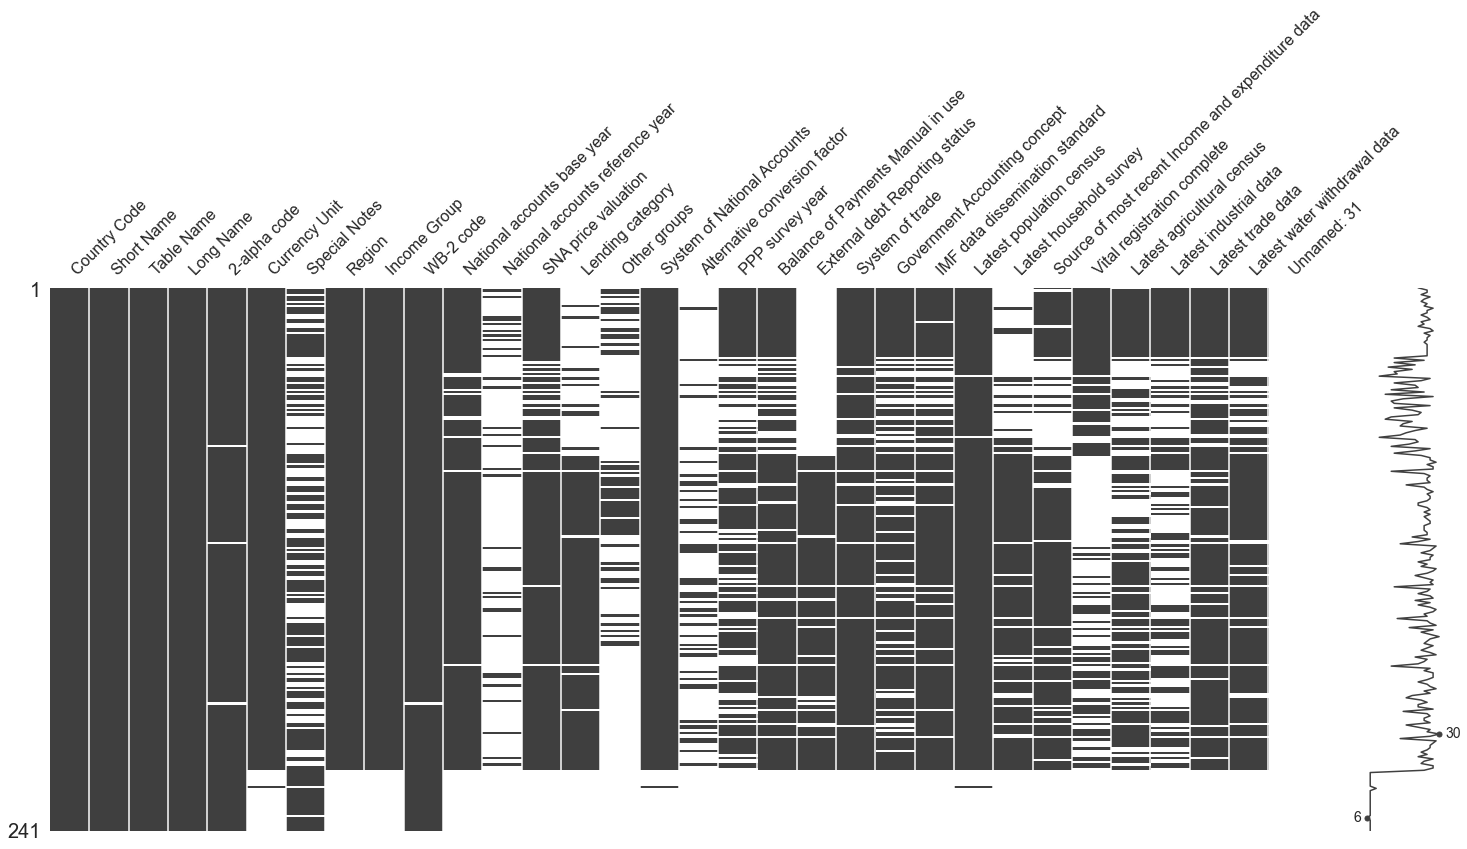

In [43]:
msno.matrix(raw_country_df.sort_values(by=['Income Group'], axis=0))


❔Currency Units

In [44]:
raw_country_df['Currency Unit'].value_counts().head(10)

Euro                     23
CFA franc                14
U.S. dollar              14
East Caribbean dollar     6
Danish krone              3
Pound sterling            3
Australian dollar         3
Swiss franc               2
Israeli new shekel        2
CFP franc                 2
Name: Currency Unit, dtype: int64

In [45]:
raw_country_df[raw_country_df['Currency Unit']=='U.S. dollar']['Table Name'].to_list()

['American Samoa',
 'Ecuador',
 'Micronesia, Fed. Sts.',
 'Guam',
 'Marshall Islands',
 'Northern Mariana Islands',
 'Palau',
 'Puerto Rico',
 'El Salvador',
 'Turks and Caicos Islands',
 'Timor-Leste',
 'United States',
 'Virgin Islands (U.S.)',
 'Zimbabwe']

❔ Quels sont les régions, et combien de pays dans chaque region


In [46]:
# region_df = raw_country_df['Region'].value_counts().reset_index(name='count').rename(columns={'index': 'Region'})
raw_country_df['Region'].value_counts()


Europe & Central Asia         57
Sub-Saharan Africa            48
Latin America & Caribbean     41
East Asia & Pacific           36
Middle East & North Africa    21
South Asia                     8
North America                  3
Name: Region, dtype: int64

❔ Est-ce que tous les pays sont représentés (et dans la bonne région) ?


In [47]:
(raw_country_df
 .sort_values(by='Short Name')
 .groupby(['Region'])
 .agg({'Short Name': ['count', ', '.join]})
 .droplevel(level=0, axis=1)
 .reset_index(drop=False)
 .rename(columns={'join': 'countries'})
 .set_index('countries'))


,Region,count
countries,,
"American Samoa, Australia, Brunei, Cambodia, China, Dem. People's Rep. Korea, Fiji, French Polynesia, Guam, Hong Kong SAR, China, Indonesia, Japan, Kiribati, Korea, Lao PDR, Macao SAR, China, Malaysia, Marshall Islands, Micronesia, Mongolia, Myanmar, New Caledonia, New Zealand, Northern Mariana Islands, Palau, Papua New Guinea, Philippines, Samoa, Singapore, Solomon Islands, Thailand, Timor-Leste, Tonga, Tuvalu, Vanuatu, Vietnam",East Asia & Pacific,36
"Albania, Andorra, Armenia, Austria, Azerbaijan, Belarus, Belgium, Bosnia and Herzegovina, Bulgaria, Channel Islands, Croatia, Cyprus, Czech Republic, Denmark, Estonia, Faeroe Islands, Finland, France, Georgia, Germany, Greece, Greenland, Hungary, Iceland, Ireland, Isle of Man, Italy, Kazakhstan, Kosovo, Kyrgyz Republic, Latvia, Liechtenstein, Lithuania, Luxembourg, Macedonia, Moldova, Monaco, Montenegro, Netherlands, Norway, Poland, Portugal, Romania, Russia, San Marino, Serbia, Slovak Republic, Slovenia, Spain, Sweden, Switzerland, Tajikistan, Turkey, Turkmenistan, Ukraine, United Kingdom, Uzbekistan",Europe & Central Asia,57
"Antigua and Barbuda, Argentina, Aruba, Barbados, Belize, Bolivia, Brazil, Cayman Islands, Chile, Colombia, Costa Rica, Cuba, Curaçao, Dominica, Dominican Republic, Ecuador, El Salvador, Grenada, Guatemala, Guyana, Haiti, Honduras, Jamaica, Mexico, Nicaragua, Panama, Paraguay, Peru, Puerto Rico, Sint Maarten (Dutch part), St. Kitts and Nevis, St. Lucia, St. Martin (French part), St. Vincent and the Grenadines, Suriname, The Bahamas, Trinidad and Tobago, Turks and Caicos Islands, Uruguay, Venezuela, Virgin Islands",Latin America & Caribbean,41
"Algeria, Bahrain, Djibouti, Egypt, Iran, Iraq, Israel, Jordan, Kuwait, Lebanon, Libya, Malta, Morocco, Oman, Qatar, Saudi Arabia, Syrian Arab Republic, Tunisia, United Arab Emirates, West Bank and Gaza, Yemen",Middle East & North Africa,21
"Bermuda, Canada, United States",North America,3
"Afghanistan, Bangladesh, Bhutan, India, Maldives, Nepal, Pakistan, Sri Lanka",South Asia,8
"Angola, Benin, Botswana, Burkina Faso, Burundi, Cabo Verde, Cameroon, Central African Republic, Chad, Comoros, Congo, Côte d'Ivoire, Dem. Rep. Congo, Equatorial Guinea, Eritrea, Ethiopia, Gabon, Ghana, Guinea, Guinea-Bissau, Kenya, Lesotho, Liberia, Madagascar, Malawi, Mali, Mauritania, Mauritius, Mozambique, Namibia, Niger, Nigeria, Rwanda, Senegal, Seychelles, Sierra Leone, Somalia, South Africa, South Sudan, Sudan, Swaziland, São Tomé and Principe, Tanzania, The Gambia, Togo, Uganda, Zambia, Zimbabwe",Sub-Saharan Africa,48


❔ Verification que les Country Code (longueur) est le code ISO-3

- plus rapide est une visualisation avec plotly:


#### 2.4.3.1 Couleurs pour les régions
Défine les même couleurs pour les régions que celles utilisées plus tard dans l'analyse exploratoire 

In [48]:
# region_palette = 'Dark2'
# https://colorbrewer2.org/#type=qualitative&scheme=Dark2&n=7
region_colors = sns.color_palette("Dark2").as_hex()[:7]
# meilleur ordre visuel pour l'analyse exploratoire - copié ici
region_order = [
    'North America',
    'Europe & Central Asia',
    'Middle East & North Africa',
    'East Asia & Pacific',
    'Latin America & Caribbean',
    'South Asia',
    'Sub-Saharan Africa'
]
region_palette = dict(zip(region_order, region_colors))
region_palette


{'North America': '#1b9e77',
 'Europe & Central Asia': '#d95f02',
 'Middle East & North Africa': '#7570b3',
 'East Asia & Pacific': '#e7298a',
 'Latin America & Caribbean': '#66a61e',
 'South Asia': '#e6ab02',
 'Sub-Saharan Africa': '#a6761d'}

In [49]:
# You must restart the runtime in order to use newly installed versions.
# !pip install plotly --upgrade 

In [50]:
# Cette import exige plotly > 4.5.0 et alourdi le fichiere par plusieurs Mo
# enlève les commentaires pour visualiser la carte


In [51]:
# import plotly.express as px
def map_countries_with_region(df):
    countries_with_region = df[(~df['Region'].isnull())]
    fig = px.choropleth(countries_with_region,
                        locations='Country Code',
                        color="Region",
                        color_discrete_map=region_palette,
                        hover_data=['Short Name'],
                        locationmode='ISO-3',
                        scope="world",
                        title='Pays par région'
                        )
    fig.show()

map_countries_with_region(raw_country_df)


❔ Existe-t-il des duplicatas ?


In [52]:
raw_country_df.duplicated(subset=['Country Code']).sum()


0

In [53]:
out_df = raw_country_df.groupby(['Country Code']).agg(
    {'Region': ['nunique', set]})
out_df.columns = out_df.columns.droplevel(0)
masque = out_df['nunique'] > 1
out_df[masque]


,nunique,set
Country Code,,


❔ Est-ce qu'il y a des pays manquants dans les autres fichiers ?

- pays dans `country.csv` qui n'éxistent pas dans `country_series.csv` ?
- pays dans `country_series.csv` qui n'éxistent pas dans `country.csv` ?
- pays dans `country.csv` qui n'éxistent pas dans `data.csv` ?
- pays dans `data.csv` qui n'éxistent pas dans `country.csv` ?


In [54]:
def validation_pays_cles():
    pays_country = raw_country_df['Country Code'].unique()
    pays_series = raw_country_series_df['CountryCode'].unique()
    pays_data = raw_data_df['Country Code'].unique()
    tous_les_pays = list(set(pays_country).union(
        set(pays_series).union(set(pays_data))))
    print(f'{len(tous_les_pays)} pays uniques')
    print(f'{len(pays_country)} pays dans country')
    print(f'{len(pays_series)} pays dans series_countries')
    print(f'{len(pays_data)}  pays dans data')

    pays_series_not_in_country = list(set(pays_series) - set(pays_country))
    pays_data_not_in_country = list(set(pays_data) - set(pays_country))

    pays_not_in_country = list(set(tous_les_pays) - set(pays_country))
    pays_not_in_country_series = list(set(tous_les_pays) - set(pays_series))
    pays_not_in_data = list(set(tous_les_pays) - set(pays_data))

    pays_not_in_country.sort()
    pays_not_in_country_series.sort()
    pays_not_in_data.sort()

    print(f'pays pas dans country: {pays_not_in_country}')
    print(f'pays pas dans country_series: {pays_not_in_country_series}')
    print(f'pays pas dans data: {pays_not_in_data}')
    return pays_not_in_country_series

pays_not_in_country_series= validation_pays_cles()


242 pays uniques
241 pays dans country
211 pays dans series_countries
242  pays dans data
pays pas dans country: ['VGB']
pays pas dans country_series: ['ARB', 'CUW', 'EAP', 'EAS', 'ECA', 'ECS', 'EMU', 'EUU', 'HIC', 'HPC', 'LAC', 'LCN', 'LDC', 'LIC', 'LMC', 'LMY', 'MAF', 'MEA', 'MIC', 'MNA', 'NAC', 'NRU', 'OED', 'SAS', 'SSA', 'SSD', 'SSF', 'SXM', 'UMC', 'VGB', 'WLD']
pays pas dans data: []


❔ Quel est les pays 'VGB' représentés dans `Data` sans registre dans `Country`

- on peut ignorer : c'est un très petit pays qui ne sera pas prioritaire pour notre entreprise


In [55]:
mask = raw_data_df['Country Code'].isin(['VGB'])
raw_data_df[mask]['Country Name'].drop_duplicates()


190580    British Virgin Islands
Name: Country Name, dtype: object

❔ Quel sont les pays pas représentés dans `Country_Series`


In [56]:
mask = raw_country_df['Country Code'].isin(pays_not_in_country_series)
missing_country_df = raw_country_df[mask].iloc[:, :6]
missing_country_df


,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit
5,ARB,Arab World,Arab World,Arab World,1A,NaN
47,CUW,Curaçao,Curaçao,Curaçao,CW,Netherlands Antilles guilder
57,EAP,East Asia & Pacific (developing only),East Asia & Pacific,East Asia & Pacific (developing only),4E,NaN
58,EAS,East Asia & Pacific (all income levels),East Asia & Pacific (all income levels),East Asia & Pacific (all income levels),Z4,NaN
59,ECA,Europe & Central Asia (developing only),Europe & Central Asia,Europe & Central Asia (developing only),7E,NaN
60,ECS,Europe & Central Asia (all income levels),Europe & Central Asia (all income levels),Europe & Central Asia (all income levels),Z7,NaN
63,EMU,Euro area,Euro area,Euro area,XC,NaN
68,EUU,European Union,European Union,European Union,EU,NaN
89,HIC,High income,High income,High income,XD,NaN
92,HPC,Heavily indebted poor countries (HIPC),Heavily indebted poor countries (HIPC),Heavily indebted poor countries (HIPC),XE,NaN


Les pays sans representation dans country_series sont des parties ou groupes de pays.

- on les ignore dans notre analyse, car l'objectif est d'identifier de pays spécifiques, pas des pays groupés par catégorie


❔ Est-ce que le champ `Income Group` peut être utile


#### 2.4.3.2 Couleurs pour les Income Group
Défine les même couleurs pour les Income Groups que celles utilisées plus tard dans l'analyse exploratoire 

In [57]:
income_group_colors = sns.color_palette("tab20").as_hex()[:5]
income_group_order = [
    'Low income',
    'Lower middle income',
    'Upper middle income',
    'High income: nonOECD',
    'High income: OECD'
]
income_group_palette = dict(zip(income_group_order,income_group_colors))
income_group_palette

{'Low income': '#1f77b4',
 'Lower middle income': '#aec7e8',
 'Upper middle income': '#ff7f0e',
 'High income: nonOECD': '#ffbb78',
 'High income: OECD': '#2ca02c'}

In [58]:
def order_by_income_group(df, group_order=income_group_order):
    df = df.assign(income_group_order=1)
    for index_label, row_series in df.iterrows():
        df.loc[index_label, 'income_group_order'] = group_order.index(row_series['Income Group'])
    return df.sort_values(by='income_group_order')

def map_countries_by_income_group(df):
    countries_with_income_group = df[~df['Income Group'].isnull()]

    fig = px.choropleth(countries_with_income_group.pipe(order_by_income_group),
                        locations='Country Code',
                        color="Income Group",
                        color_discrete_map=income_group_palette,
                        hover_data=['Short Name'],
                        locationmode='ISO-3',
                        scope="world",
                        title='Pays par Income Group',
                        )
    fig.show()


map_countries_by_income_group(raw_country_df)


#### 2.4.3.3 Bilan qualité de "EdStatsCountry.csv"

- Contient 241 registres, dont 214 pays, plus des divers groupements de pays
- peu de données manquantes pour les 214 pays
- aucun dupliqué : la colonne `Country Code` est clé
- aucune donnée dans la dernière colonne `Unnamed: 3`
- Les champs `Region` et `Income Group` peut être util pour comparer les pays
- contient plusieurs autres façons de catégorisé les pays (Currency, System of Trade)


---

### 2.4.4 🟧🟠 Qualité de "EdStatsData.csv"


❔ Existe-t-il des valeurs manquantes dans ce jeu de données ?

- ❔ Combien de valeurs uniques dans chaque colonne


In [59]:
(decrire_dataframe(raw_data_df).reset_index().style
    .bar(axis='index', subset=['count'], color='lightgreen')
    .applymap(is_zero, subset=['count', 'unique'], color='pink'))


,column,count,unique,dtype,max_length
0,Country Name,886930,242,object,50
1,Country Code,886930,242,object,3
2,Indicator Name,886930,3665,object,164
3,Indicator Code,886930,3665,object,30
4,1970,72288,24595,float64,nan
5,1971,35537,30892,float64,nan
6,1972,35619,30982,float64,nan
7,1973,35545,30988,float64,nan
8,1974,35730,31139,float64,nan
9,1975,87306,37838,float64,nan


❔ Existe-t-il des duplicatas ?

- dans `['Country Code', 'Indicator Code']`


In [60]:
dup_ci = raw_data_df.duplicated(
    subset=['Country Code', 'Indicator Code']).sum()
print(f'{dup_ci} duplicatas dans [Country Code, Indicator Code]')


0 duplicatas dans [Country Code, Indicator Code]


❔ Est-ce qu'il y a une ligne pour tous les indicateurs pour tous les pays

- Vérifie avec country name et indicator name


In [61]:
nb_data_unique = raw_data_df.drop_duplicates(
    subset=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']).shape[0]
print(f'nb registres unique:{nb_data_unique}')
print(f'nb registres: {raw_data_df.shape[0]}')
print(f'242*3665 = {242 * 3665}')
raw_data_df[['Country Name', 'Country Code',
             'Indicator Name', 'Indicator Code']].nunique()


nb registres unique:886930
nb registres: 886930
242*3665 = 886930


Country Name       242
Country Code       242
Indicator Name    3665
Indicator Code    3665
dtype: int64

❔ Distribution des valeurs remplies


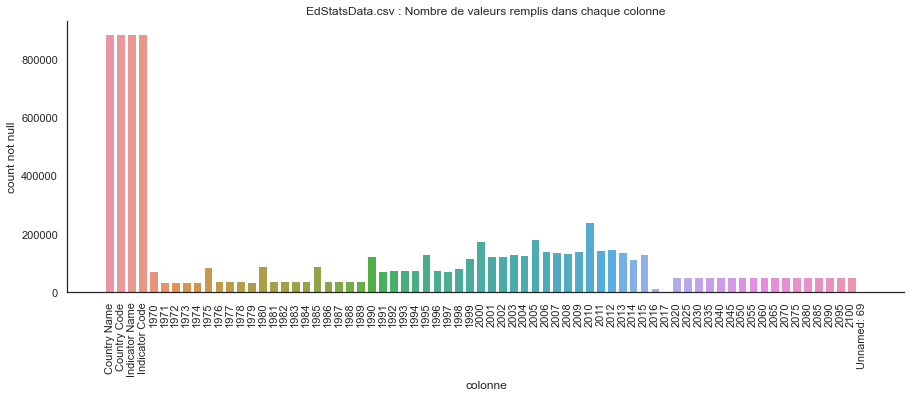

In [62]:

plot_not_null(raw_data_df, titre='EdStatsData.csv : Nombre de valeurs remplis dans chaque colonne',
              figsize=(15, 5), orient='v');


❔ Données manquantes par 'topic' d'indicateur

- le code d'indicateur commence par le code du topic


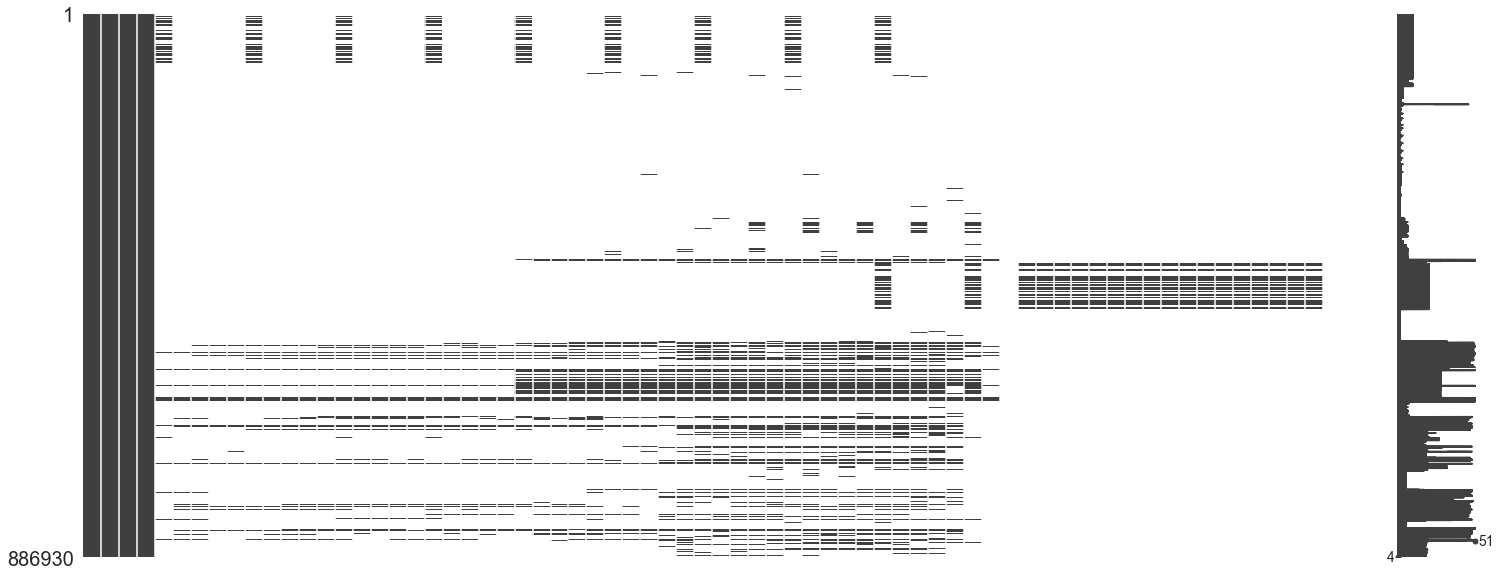

In [63]:
msno.matrix(raw_data_df.sort_values(by=['Indicator Code']));


❔ Quels series existent dans table `Data`, mais ne sont pas décrits dans table `Series`

- Utilise 'outer' join pour au même temps identifier series dans `Series`, qui ne sont pas présents dans table `Data`


In [64]:
def validate_missing_series(series=raw_series_df, data=raw_data_df):
    series = series[['Series Code', 'Indicator Name']]
    data = data[['Indicator Code', 'Indicator Name']]

    tous_series_codes = series.merge(
        data, left_on='Indicator Name', right_on='Indicator Name', how='outer')
    filter_series_sans_description = tous_series_codes['Series Code'].isnull()

    filter_data_codes_avec_series = data['Indicator Code'].isin(
        series['Series Code'].unique())
    filter_data_names_avec_series = data['Indicator Name'].isin(
        series['Indicator Name'].unique())
    filter_series_codes_avec_data = series['Series Code'].isin(
        data['Indicator Code'].unique())
    filter_series_names_avec_data = series['Indicator Name'].isin(
        data['Indicator Name'].unique())

    data_series_sans_description_df = tous_series_codes[filter_series_sans_description]
    # series_sans_description= data_series_sans_description_df["Indicator Code"].to_list()

    data_codes_sans_series_desc = data[~filter_data_codes_avec_series]
    data_names_sans_series_desc = data[~filter_data_names_avec_series]

    series_codes_sans_data_df = series[~filter_series_codes_avec_data]
    series_names_sans_data_df = series[~filter_series_names_avec_data]

    series_sans_description = (data_codes_sans_series_desc[["Indicator Code"]]
                               .drop_duplicates()['Indicator Code'].to_list())
    series_sans_description.sort()
    series_codes_sans_data = series_codes_sans_data_df.drop_duplicates()[
        "Series Code"].to_list()
    series_codes_sans_data.sort()

    # print (f'Il y a {len(series_sans_data_df.index)} series codes sans data')
    print(
        f'Il y a {series_codes_sans_data_df.shape[0]} series codes absents dans data')
    print(
        f'Il y a {series_names_sans_data_df.shape[0]} series names absents dans data')
    print(
        f'Il y a {data_codes_sans_series_desc.shape[0]} data codes absents dans series')
    print(
        f'Il y a {data_names_sans_series_desc.shape[0]} data names absents dans series')

    print(
        f'\nIl y a {len(data_codes_sans_series_desc.index)} series codes dans data.csv sans descriptions dans series.csv')
    print(
        f'\nData series codes sans description dans table Series:\n{"; ".join(series_sans_description)}')
    print(
        f'\nIl y a {len(series_codes_sans_data_df.index)} series codes dans data.csv sans descriptions dans series.csv')
    print(
        f'\nSeries codes sans clé Indicator Code dans table Data:\n{"; ".join(series_codes_sans_data)}')
    # return data_series_sans_description_df


validate_missing_series(raw_series_df, raw_data_df)


Il y a 53 series codes absents dans data
Il y a 462 series names absents dans data
Il y a 12826 data codes absents dans series
Il y a 111804 data names absents dans series

Il y a 12826 series codes dans data.csv sans descriptions dans series.csv

Data series codes sans description dans table Series:
SE.SEC.DURS.LO; SE.SEC.ENRR.UP.FE; UIS.AIR.1.GLAST.GPI; UIS.CEAGE.1; UIS.E.0.PU.F; UIS.E.1.GUK; UIS.E.1.GUK.F; UIS.E.1.PU; UIS.E.1.PU.F; UIS.E.2.PU.F; UIS.E.23.PU; UIS.E.23.PU.F; UIS.E.3.PU.F; UIS.E.4.PU; UIS.E.4.PU.F; UIS.FOSEP.56.FUK.F; UIS.GER.1T6.F; UIS.GER.1T6.GPI; UIS.GER.1T6.M; UIS.LP.AG15T24; UIS.LP.AG15T24.F; UIS.LP.AG15T24.M; UIS.LP.AG15T99; UIS.LP.AG15T99.F; UIS.LP.AG65; UIS.LP.AG65.M; UIS.LPP.AG15T99; UIS.LPP.AG65; UIS.LR.AG15T99.GPI; UIS.LR.AG65.F; UIS.LR.AG65.M; UIS.NIR.1.AGM1; UIS.NIR.1.AGM1.F; UIS.NIR.1.AGM1.M; UIS.NIR.1.AGP1; UIS.NIR.1.AGP1.F; UIS.NIR.1.AGP1.M; UIS.OE.56.40510; UIS.SLE.1T6.GPI; UIS.SR.1.GLAST.GPI; UIS.THAGE.0; UIS.THAGE.3.A.GPV; UIS.THAGE.4.A.GPV; UIS.THDU

Pour trouver la description d'indicateurs (table `Series`) utilisés dans table `Data`:

- en Series['Series Code']: supprimer les espaces et mettre le code en majuscule
- n'utilise pas le champ ['Indicator Name'] comme clé pour joindre les tables `Series` et `Data`


❔ Est-ce que ce difference de format (espaces, minuscules) dans Series affect beaucoup de registres dans le `Data`

- Combien de registres sont dans `Data`, sans une description de source dans `series`, si on fait un join sur 'Series Code = Indicator Code'
- Est-ce qu'un join sur 'Indicator Name' sera pire


In [65]:
def validate_indicator_name():
    filter_series_avec_description = raw_data_df['Indicator Code'].isin(
        raw_series_df['Series Code'].unique())
    data_sans_series_description = raw_data_df[~filter_series_avec_description]
    print(
        f'data sans series (join sur Indicator Code) : {len(data_sans_series_description.index)}')

    filter_series_name_avec_description = raw_data_df['Indicator Name'].isin(
        raw_series_df['Indicator Name'].unique())
    data_sans_series_description = raw_data_df[~filter_series_name_avec_description]
    print(
        f'data sans series (join sur Indicator Name) : {len(data_sans_series_description.index)}')


validate_indicator_name()


data sans series (join sur Indicator Code) : 12826
data sans series (join sur Indicator Name) : 111804


❔ Combien de lignes ont aucune donnée dans les colonnes 'années'


In [66]:
annees_list= list(map(str, np.arange(1970, 2101)))
columns_annees=raw_data_df.columns.isin(annees_list)
columns_annees_list=raw_data_df.columns[columns_annees].tolist()
print(columns_annees_list)

['1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100']


In [67]:

data_annees_list = raw_data_df.iloc[:3, 4:-1].columns.tolist()
print(data_annees_list)


['1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100']


In [68]:
def data_annees_not_tous_null(colonnes_annees=data_annees_list):
    data_annees_not_tous_null_df = raw_data_df.dropna(
        how='all', subset=colonnes_annees)
    print(data_annees_not_tous_null_df.shape)
    # return data_annees_not_tous_null_df.sample(1)


data_annees_not_tous_null()


(357405, 70)


Presque la moitie des lignes contient aucune donnée !!!


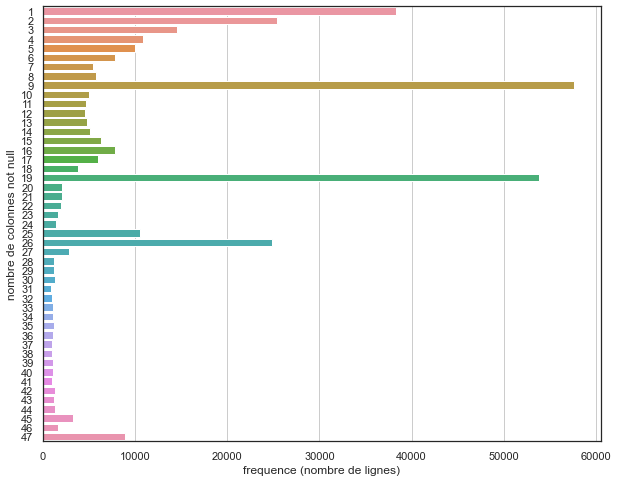

In [69]:
def plot_data_not_nulls_frequence(df, colonnes_annees=data_annees_list):
    data_not_null = df.dropna(how='all', subset=colonnes_annees)
    data_not_nulls_frequence = (data_not_null[colonnes_annees]
                                .count(axis=1)
                                .value_counts()
                                .to_frame(name="frequence")
                                .rename_axis("nb_colonnes_not_null")
                                .reset_index()
                                .sort_values('nb_colonnes_not_null'))

    _, ax = plt.subplots(figsize=(10, 8))

    sns.barplot(data=data_not_nulls_frequence, x='frequence',
                y='nb_colonnes_not_null', orient='h', ax=ax)
    ax.set(xlabel='frequence (nombre de lignes)',
           ylabel='nombre de colonnes not null')
    axes = plt.gca()
    axes.xaxis.grid()
    plt.show()


plot_data_not_nulls_frequence(raw_data_df, data_annees_list)


#### 2.4.4.1 Bilan qualité de "EdStatsData.csv"

- Contient les valeurs des séries temporales pour 3665 séries de 242 pays (886930)
- des 886930 registres, plus que la moitie des lignes n'ont pas des valeurs dans les années
- seulement 357405 lignes contient des valeurs temporales :
  - environ 10% (40000) sont des valeurs d'une année seule
  - presque 40% (135000) sont des series de 9, 19 ou 26 années (peut-être seulement 3 sources de données dominantes ?)


---

### 2.4.5 🟩🟢 Qualité de "EdStatsFootNote.csv"


In [70]:
raw_footnote_df.head(3)


,CountryCode,SeriesCode,Year,DESCRIPTION,Unnamed: 4
0,ABW,SE.PRE.ENRL.FE,YR2001,Country estimation.,NaN
1,ABW,SE.TER.TCHR.FE,YR2005,Country estimation.,NaN
2,ABW,SE.PRE.TCHR.FE,YR2000,Country estimation.,NaN


In [71]:
(decrire_dataframe(raw_footnote_df).reset_index().style
    .bar(axis='index', subset=['count'], color='lightgreen')
    .applymap(is_zero, subset=['count', 'unique'], color='pink'))


,column,count,unique,dtype,max_length
0,CountryCode,643638,239,object,3
1,SeriesCode,643638,1558,object,30
2,Year,643638,56,object,6
3,DESCRIPTION,643638,9102,object,1132
4,Unnamed: 4,0,0,float64,nan


Est-ce que le "Year" correspond à un des colonnes d'année dans "Data"

In [72]:
unique_years = raw_footnote_df['Year'].unique()
unique_years.sort()
unique_years

array(['YR1970', 'YR1971', 'YR1972', 'YR1973', 'YR1974', 'YR1975',
       'YR1976', 'YR1977', 'YR1978', 'YR1979', 'YR1980', 'YR1981',
       'YR1982', 'YR1983', 'YR1984', 'YR1985', 'YR1986', 'YR1987',
       'YR1988', 'YR1989', 'YR1990', 'YR1991', 'YR1992', 'YR1993',
       'YR1994', 'YR1995', 'YR1996', 'YR1997', 'YR1998', 'YR1999',
       'YR2000', 'YR2001', 'YR2002', 'YR2003', 'YR2004', 'YR2005',
       'YR2006', 'YR2007', 'YR2008', 'YR2009', 'YR2010', 'YR2011',
       'YR2012', 'YR2013', 'YR2014', 'YR2015', 'YR2016', 'YR2017',
       'YR2020', 'YR2025', 'YR2030', 'YR2035', 'YR2040', 'YR2045',
       'YR2050', 'yr2012'], dtype=object)

Est-ce qu'il peut avoir plus d'un footnote pour un pays, indicateur et année ?


In [73]:
raw_footnote_df.groupby(['CountryCode', 'SeriesCode', 'Year']).agg(
    {'DESCRIPTION': 'count'}).max()


DESCRIPTION    1
dtype: int64

In [74]:
raw_footnote_df.duplicated(subset=['CountryCode', 'SeriesCode', 'Year']).sum()


0

#### 2.4.5.1 Bilan qualité de "EdStatsFootnote.csv"

- Contient 643638 footnotes, un pour chaque pays, année et indicateur
- seulement 1 sur 40 données contient un footnote


---

# 3. 📊 Préparation des données<a name="preparation"></a>
[🔝](#toc)

## 3.1 Nettoyage des données <a name="preparation-nettoyage"></a>


### 3.1.1 Suppression des fichiers non pertinents

Les fichiers `country_series` et `footnote` ne seront pas utilisés pour l'analyse pré-exploratoire


In [75]:
# del raw_country_series_df
# del raw_footnote_df


### 3.1.2 Suppression des colonnes vides


In [76]:
def drop_colonnes_vides(df, debug=False):
    count = df.notnull().sum()
    colonnes_vides = count[count.values == 0].index.to_list()
    if debug:
        print(f'drop_colonnes_vides : {set(colonnes_vides)}')
    return df.drop(colonnes_vides, axis=1)


def check_drop_colonnes_vides():
    drop_colonnes_vides(raw_series_df, True)
    drop_colonnes_vides(raw_country_df, True)
    drop_colonnes_vides(raw_data_df, True)


check_drop_colonnes_vides()


drop_colonnes_vides : {'Notes from original source', 'Other web links', 'Unit of measure', 'Unnamed: 20', 'License Type', 'Related indicators'}
drop_colonnes_vides : {'Unnamed: 31'}
drop_colonnes_vides : {'Unnamed: 69'}


On a une copie de chaque fichier de données pour nettoyage

- Vider la memoire jupyter des données "raw"
- ça nous force à travailler seulement sur les données nettoyées - éviter d'erreurs


In [77]:
# del raw_data_df
# del raw_series_df
# del raw_country_df


### 3.1.3 Nettoyage des clés pour permettre de joindre les tables `Series` et `Data`

- en Series['Series Code']: supprimer les espaces et mettre le code en majuscule
- en Data['Indicator Code']: supprimer les espaces et mettre le code en majuscule


In [78]:
def nettoye_cle(df):
    if 'Series Code' in df.columns:
        df['Series Code'] = df['Series Code'].str.upper().replace(' ', '')

    if 'Indicator Code' in df.columns:
        df['Indicator Code'] = df['Indicator Code'].str.upper().replace(' ', '')
    return df


In [79]:
# check
def check_nettoye_cles(data, series):
    net_data = nettoye_cle(data)
    net_series = nettoye_cle(series)

    filter_series_avec_description = net_data['Indicator Code'].isin(
        net_series['Series Code'].unique())
    data_sans_series_description = net_data[~filter_series_avec_description]
    print(f'data sans series (count) = {len(data_sans_series_description)}')
    print(data_sans_series_description.groupby(
        ['Indicator Code', 'Indicator Name']).agg({'Country Code': 'count'}))

    return (net_data, net_series)

net_data_df, net_series_df= check_nettoye_cles(raw_data_df, raw_series_df)



data sans series (count) = 726
                                                                                                                        Country Code
Indicator Code    Indicator Name                                                                                                    
SE.SEC.DURS.LO    Theoretical duration of lower secondary education (years)                                                      242
SE.SEC.ENRR.UP.FE Gross enrolment ratio, upper secondary, female (%)                                                             242
UIS.OE.56.40510   Total outbound internationally mobile tertiary students studying abroad, all countries, both sexe...           242


---

## 3.2 Sélection des informations qui semble pertinente<a name="preparation-selection"></a>

[🔝](#toc)

### 3.2.1 Identification et sélection des indicateurs intéressants (maximum 5)

#### 3.2.1.1 Les criteria supposés pour sélectionner

❔ Est-ce que ces données peuvent nous aider à discriminer dans quels pays :

- on peut vendre le maximum quantité de cours (e-learning via internet),
- avec le maximum prix,
- à un certain secteur de la population (secteur tertiaire, BAC+, 18-25 ans? ),
- pour faire le maximum du profit (= nombre de clients \* prix de vente - dépenses)


#### 3.2.1.2 Exemple de Model

Pour une année donnée :

<b>{ PROFIT } = { POPULATION } _ { % AVEC ACESS } _ { % SECTEUR TERTIARE + MOTIVATION A E-LEARNING } \* { PRIX DE VENTE - DEPENSES } </b>

Pour simplifié, je suppose que les dépenses sont proportionelle au prix de vente:
- dans un pays de bas salaires, le prix de vente est bas, mais les dépenses en ressources humaines sont aussi bas
- dans des pays riches, on peut vendre plus cher, mais les dépenses pour payer les mentors etc sont plus chers 

Donc, les indicateurs de prix de vente et dépenses sont traités ensemble


#### 3.2.1.3 Idées pour des indicateurs


a. Analyse PESTEL (pensée divergente - idées pour indicateurs)

- **P**olitique, **E**conomique, **S**ocial, **T**echnologique, **E**nvironnementale, **L**egale


b. World Bank - Education at a Glance indicators (pensée convergente)

- Les indicateurs les plus utilisés pour comparer et discriminer les pays sont sur le site de la banque mondiale
- (par exemple : <https://datatopics.worldbank.org/education/country/brazil>)


c. Autres comparaisons de pays par thème sur Worldbank

- [Learning Outcomes Dashboard](https://datatopics.worldbank.org/education/wDashboard/dqlearning)(**2003-2018**)

  - **levels of student learning in reading, mathematics and science in over 100 countries**
  - scores international (PISA, TIMSS, PIRLS, and PIAAC) et regional(LLECE, PASEC, and SACMEQ).
  - "Data may not be comparable across years, countries, or assessments"

- [Educational Attainment Dashboard](https://datatopics.worldbank.org/education/wDashboard/dqattainment)(**1970 to 2010** )

  - education attainment (Primary, Secondary, Tertiary) and human capital in over 100 countries from (Barro-Lee)
  - étude trop ancienne ??

- [Education Equality Dashboard](https://datatopics.worldbank.org/education/wDashboard/dqequality)(**2005-2008**)

  - gender, income and geographic inequalities in education access, completion and attainment.

- [Government expenditure on education](https://datatopics.worldbank.org/education/wDashboard/dqexpenditures)(**2000 - 2018**)

  - permet correlation enter expenditures et autre relevant indicators
  - permet comparaison entre 2 pays ou regions.

- [SABER - Systems Approach for Better Education Results](https://datatopics.worldbank.org/education/wDashboard/dqpolicy)(**2013**)
  - indices objectif : how well their country's education system policies are oriented toward promoting Learning for All.


### 3.2.2 Chercher des indicateurs dans les data<a name="preparation-recherche"></a>

_**Model**_:

> <b>{ REVENU } = { POPULATION } _ { % AVEC ACESS } _ { % SECTEUR TERTIAIRE + MOTIVATION A E-LEARNING } \* { PRIX DE VENTE }</b>


#### Fonctions pour trouver des indicateurs


In [80]:
def trouve_indicateurs(str_in, series=raw_series_df, not_in=''):
    """Trouve des indicateurs qui contient une ou plusieurs chaines."""
    chaines = str_in.split(' ')
    filtre = series['Indicator Name'].notnull()
    for chaine in chaines:
        filtre &= series['Indicator Name'].str.contains(
            chaine, regex=False, case=False)

    if not not_in is None and len(not_in) > 0:
        not_in = not_in.split(' ')
        for not_chaine in not_in:
            filtre &= ~series['Indicator Name'].str.contains(
                not_chaine, regex=False, case=False)

    indicator_codes = series[filtre].sort_values(by="Series Code")
    return indicator_codes[['Series Code', 'Indicator Name', 'Topic']]


def filtrer_par_series_code(series, code):
    """Trouve des indicateurs qui contient le chaine code dans Series Code."""
    filtre = series['Series Code'].str.contains(code, regex=False, case=False)
    indicator_codes = series[filtre].sort_values(by="Series Code")
    return indicator_codes[['Series Code', 'Indicator Name', 'Topic']]


def filtrer_par_indicator_code(data, code):
    """Trouve des indicateurs qui contient le chaine code dans Indicator Code."""
    filtre = data['Indicator Code'].str.contains(code, regex=False, case=False)
    indicator_codes = data[filtre].sort_values(by="Indicator Code")
    return indicator_codes


#### Fonctions pour conter le nombre de pays avec valeurs pour chaque indicateur

Les années avec le plus de données sont 2010, 2015 et 2020 (projections)
Pour aider choisir des indicateurs, on cherche le nombre de pays avec valeurs pour les indicateurs dans ces années


In [81]:

def indicateur_nb_pays(series, data=raw_data_df):
    """trouver le nombre de pays avec des données pour chaque indicateur"""
    filter_data_series = data['Indicator Code'].isin(series['Series Code'])
    series_data = data[filter_data_series]
    annees = ['2005', '2010', '2015', '2020', '2025', '2030']
    return ((series_data.groupby(['Indicator Code', 'Indicator Name']).count()[annees])
            .reset_index().set_index(keys='Indicator Name'))


def trouve_indicateurs_count(str_in, not_in='', series=raw_series_df, data=raw_data_df):
    """trouver des indicateurs avec un chaine, p"""
    return trouve_indicateurs(str_in, not_in, series).pipe(indicateur_nb_pays, data)


#### Fonctions pour stocker les indicateurs sélectionnés

A mesure, ajoute les indicateurs trouvés à un dataframe `indicators_longlist`


In [82]:
indicateurs_longlist = pd.DataFrame(
    [], columns={'Groupe', 'Indicator Code', 'Indicator Name'})


def add_to_indicateurs_longlist(indicators, groupe=None):
    global indicateurs_longlist
    codes = indicators.reset_index()[['Indicator Code', 'Indicator Name']]
    codes = codes.assign(Groupe=groupe)
    indicateurs_longlist = indicateurs_longlist.append(
        codes).drop_duplicates().reset_index(drop=True)


#### POPULATION - indicateurs

- Population totale (actuel, projection)
- Population totale \* croissance
- Population totale d'un âge suffisant pour e-learning

Filtres à considérer sur les données :

- Data : drop années de projections trop dans le futur
- Country : drop pays avec des populations trop petits


In [83]:
total_pop = trouve_indicateurs('total population', not_in='projection % Barro-Lee UIS age male female primary secondary labor')
tertiary_pop = trouve_indicateurs('tertiary population', not_in='percent non-tertiary male female')
projection_pop=trouve_indicateurs('post secondary attainment population projection', not_in='male female age percentage')

indicateurs_population = total_pop.append(tertiary_pop).append(projection_pop).pipe(indicateur_nb_pays)
indicateurs_population


,Indicator Code,2005,2010,2015,2020,2025,2030
Indicator Name,,,,,,,
Wittgenstein Projection: Population in thousands by highest level of educational attainment. Post Secondary. Total,PRJ.POP.ALL.4.MF,0,167,167,167,167,167
"Population, total",SP.POP.TOTL,240,240,232,0,0,0
"Population of the official age for tertiary education, both sexes (number)",SP.TER.TOTL.IN,219,217,135,0,0,0


In [84]:
indicateurs_population.pipe(add_to_indicateurs_longlist, 'population')


#### ACCES à E-LEARNING - indicateurs

- % avec acces à l'internet
- % avec ordinateur
- % avec smartphone
- langue

Filtres à considérer sur les données :

- Data : drop années avant l'internet


In [85]:
internet = trouve_indicateurs('internet')
ordinateur = trouve_indicateurs('personal computer')
smartphone = trouve_indicateurs('phone')
langue = trouve_indicateurs('language', not_in='PASEC')

indicateurs_acces = internet.append(ordinateur).append(
    smartphone).append(langue).pipe(indicateur_nb_pays)
indicateurs_acces


,Indicator Code,2005,2010,2015,2020,2025,2030
Indicator Name,,,,,,,
Personal computers (per 100 people),IT.CMP.PCMP.P2,196,0,0,0,0,0
Internet users (per 100 people),IT.NET.USER.P2,223,227,223,0,0,0


In [86]:
indicateurs_acces.pipe(add_to_indicateurs_longlist, 'acces')


#### SECTEUR TERTIAIRE - indicateurs

- Total / % Population 20-24 ans
- Gross enrolment ratio for tertiary education, both sexes (%)
- % ayant un BAC+2 / niveaux de scolarisation
- % analphabètes / adult literacy

Filtres à considérer sur les données :

- Series : drop les indicateurs des secteurs 'primary' et 'secondary'
- Series : drop les indicateurs des sexes séparés ('male' et 'female')


In [87]:
age2024_total = trouve_indicateurs(
    'age 20-24 total', not_in='male female primary secondary SABER attainment')
age2024_proj = trouve_indicateurs(
    'age 20-24 projection post sec percent ', not_in='male female')
tertiary_enrol = trouve_indicateurs(
    'tertiary enrol', not_in='male female primary secondary ISCED per non ')
literacy = trouve_indicateurs('adult literacy rate', not_in='male female')
scolarity = trouve_indicateurs('advanced educ', not_in='male female')

indicateurs_tertiary = (
    age2024_total.append(age2024_proj).append(
        tertiary_enrol).append(literacy).append(scolarity)
    .pipe(indicateur_nb_pays))
indicateurs_tertiary


,Indicator Code,2005,2010,2015,2020,2025,2030
Indicator Name,,,,,,,
"Barro-Lee: Population in thousands, age 20-24, total",BAR.POP.2024,144,144,0,0,0,0
"Barro-Lee: Average years of total schooling, age 20-24, total",BAR.SCHL.2024,144,144,0,0,0,0
Barro-Lee: Percentage of population age 20-24 with tertiary schooling. Total (Incomplete and Completed Tertiary),BAR.TER.ICMP.2024.ZS,144,144,0,0,0,0
"Barro-Lee: Average years of tertiary schooling, age 20-24, total",BAR.TER.SCHL.2024,144,144,0,0,0,0
Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total,PRJ.ATT.2024.4.MF,0,167,167,167,167,167
Wittgenstein Projection: Mean years of schooling. Age 20-24. Total,PRJ.MYS.2024.MF,0,167,167,167,167,167
"Adult literacy rate, population 15+ years, both sexes (%)",SE.ADT.LITR.ZS,40,67,33,0,0,0
Labor force with advanced education (% of total),SL.TLF.ADVN.ZS,39,61,61,0,0,0
"Adult literacy rate, population 15+ years, gender parity index (GPI)",UIS.LR.AG15T99.GPI,40,67,33,0,0,0


In [88]:
indicateurs_tertiary.pipe(add_to_indicateurs_longlist, 'tertiaire')


#### MOTIVATION A E-LEARNING - indicateurs

- Taux chômage / demande pour des employés qualifié
- taux professeur/étudiant
- rural / urban (GINI - est-ce qu'il y a un gros nombre rural qui veulent étudier, mais n'etudent pas)
- stabilité de travail
- égalité des sexes (GPI - gender parity index)
- type offre et demande de cours (tourisme, agriculture, industrie, environnement)
- attitudes culturelles (public/privé)

Filtres à considérer sur les données :

- drop pays ou la scolarité et trop bas (% avec secondary education)


In [89]:
chomage = trouve_indicateurs('unemployment', not_in='male female')
taux_prof = trouve_indicateurs('teacher ratio tertiary')
gpi = trouve_indicateurs('gpi tertiary', not_in='school secondary')
indicateurs_motivations = chomage.append(taux_prof).append(gpi).pipe(indicateur_nb_pays)
indicateurs_motivations


,Indicator Code,2005,2010,2015,2020,2025,2030
Indicator Name,,,,,,,
"Gross enrolment ratio, tertiary, gender parity index (GPI)",SE.ENR.TERT.FM.ZS,143,156,103,0,0,0
"Unemployment, total (% of total labor force)",SL.UEM.TOTL.ZS,211,211,208,0,0,0
"Gross enrolment ratio, primary to tertiary, gender parity index (GPI)",UIS.GER.1T6.GPI,136,135,2,0,0,0
"Gross graduation ratio from first degree programmes (ISCED 6 and 7) in tertiary education, gender parity index (GPI)",UIS.GGR.5.A.GPI,69,71,3,0,0,0
Pupil-teacher ratio in tertiary education (headcount basis),UIS.PTRHC.56,89,99,75,0,0,0


In [90]:
indicateurs_motivations.pipe(add_to_indicateurs_longlist, 'motivations')


#### PRIX DE VENTE - indicateurs


- GDP per capita / croissance économique - indique combien l'etat peut payer pour l'education
- GNI per capita, Atlas method (current US$) - pouvoir d'achat des individus
- salaire (median)
- cout d'études / financement des études
- % du GDP dépensé par le gouvernement sur l'education
  - Expenditure on education as % of total government expenditure (%) 2017 SE.XPD.TOTL.GB.ZS
  - Government expenditure on education as % of GDP (%) 2017 SE.XPD.TOTL.GD.ZS
- salaire des professeurs (dépenses)
- stabilité financière (inflation, taux d'échange, debt publique)
- stabilité politico-géographique (corruption, conflits régionaux)
- droits et couts d'implantation dans un pays
- protection de copyright

Filtres à considérer sur les données :

- Country : drop pays `['Income Group']` in {'Low income'}
- Country : supprime pays en guerre, monnaie instable, langue trop complexe
- Data : drop les indicateurs de dépenses/salaires des secteurs primary et secondary (focus sur tertiary)


In [91]:
gdp = trouve_indicateurs('gdp per capita current us$')
gni = trouve_indicateurs('gni per capita current us$')
gouv_expen = trouve_indicateurs(
    'expenditure education', not_in='primary secondary SABER level')
prof_salaire = trouve_indicateurs('salar', not_in='primary secondary SABER')

indicateurs_prix = gdp.append(gni).append(
    gouv_expen).append(prof_salaire).pipe(indicateur_nb_pays)
indicateurs_prix


,Indicator Code,2005,2010,2015,2020,2025,2030
Indicator Name,,,,,,,
GDP per capita (current US$),NY.GDP.PCAP.CD,229,228,218,0,0,0
"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,218,215,205,0,0,0
Expenditure on tertiary as % of government expenditure on education (%),SE.XPD.TERT.ZS,85,116,38,0,0,0
Expenditure on education as % of total government expenditure (%),SE.XPD.TOTL.GB.ZS,109,124,40,0,0,0
Government expenditure on education as % of GDP (%),SE.XPD.TOTL.GD.ZS,112,128,45,0,0,0
Government expenditure on tertiary education as % of GDP (%),UIS.XGDP.56.FSGOV,86,113,1,0,0,0
Government expenditure in educational institutions as % of GDP (%),UIS.XGDP.FSGOV.FDINSTADM.FFD,85,109,1,0,0,0


In [92]:
indicateurs_prix.pipe(add_to_indicateurs_longlist, 'prix')


### 3.2.3 Pré-choix d'indicateurs à vérifier


In [93]:
indicateurs_longlist.set_index('Indicator Name')


,Groupe,Indicator Code
Indicator Name,,
Wittgenstein Projection: Population in thousands by highest level of educational attainment. Post Secondary. Total,population,PRJ.POP.ALL.4.MF
"Population, total",population,SP.POP.TOTL
"Population of the official age for tertiary education, both sexes (number)",population,SP.TER.TOTL.IN
Personal computers (per 100 people),acces,IT.CMP.PCMP.P2
Internet users (per 100 people),acces,IT.NET.USER.P2
"Barro-Lee: Population in thousands, age 20-24, total",tertiaire,BAR.POP.2024
"Barro-Lee: Average years of total schooling, age 20-24, total",tertiaire,BAR.SCHL.2024
Barro-Lee: Percentage of population age 20-24 with tertiary schooling. Total (Incomplete and Completed Tertiary),tertiaire,BAR.TER.ICMP.2024.ZS
"Barro-Lee: Average years of tertiary schooling, age 20-24, total",tertiaire,BAR.TER.SCHL.2024


---

## 3.3 Identification des années les plus remplies<a name="preparation-annees"></a>

 

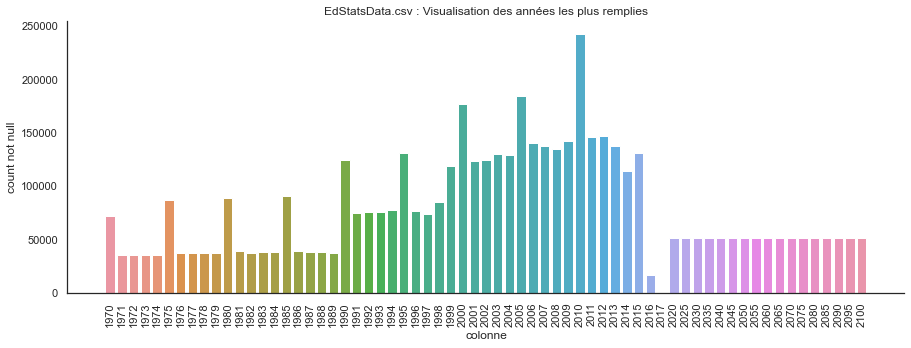

In [94]:

plot_not_null(raw_data_df.loc[:,data_annees_list],orient='v', figsize=(15,5),
titre='EdStatsData.csv : Visualisation des années les plus remplies');

### 3.3.1 Années plus remplis, tous les pays


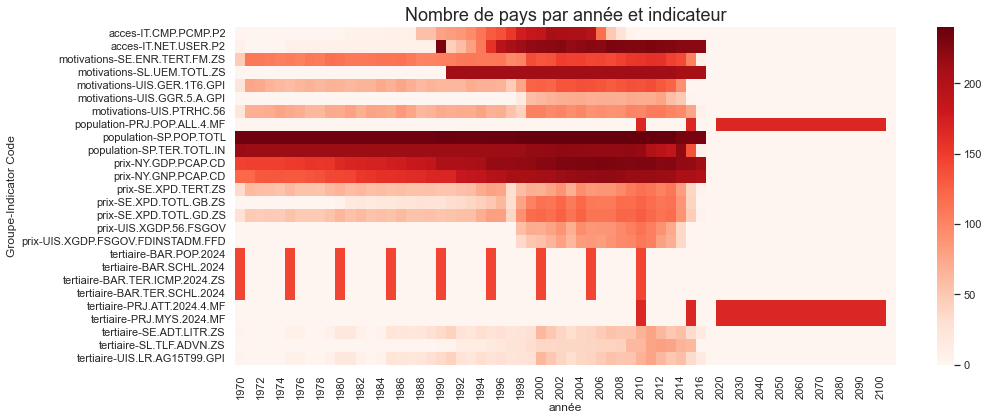

In [95]:
def merge_groupe(data, indicators=indicateurs_longlist):
    """ajout la colonne 'Groupe' au debut du dataframe"""
    return (
        indicators[['Indicator Code', 'Groupe']]
        .merge(data, left_on='Indicator Code', right_on='Indicator Code', how='right')
    )


def plot_heatmap(data, titre='Nombre de pays par année et indicateur', ax=None, annot=True):
    data = data.pipe(merge_groupe)
    if 'Region' in data.columns:
        data = data.drop(columns={'Region'})
    if 'Income Group' in data.columns:
        data = data.drop(columns={'Income Group'})
    data_count = (data.groupby(['Groupe', 'Indicator Code']).count()
                  .drop(columns={'Indicator Name', 'Country Name', 'Country Code'}))
    if ax is None:
        _, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(data_count, cmap='Reds', ax=ax, annot=annot, fmt='d')
    ax.set_title(titre, size=18)
    ax.set_xlabel('année')
    ax.set_ylabel('Groupe-Indicator Code')
    plt.tight_layout()
    plt.show()
    return data_count


def filter_indicators(data, indicators=indicateurs_longlist):
    filtre = data['Indicator Code'].isin(indicators['Indicator Code'])
    return data[filtre]


raw_data_count = (raw_data_df
                  .pipe(filter_indicators, indicators=indicateurs_longlist)
                  .pipe(plot_heatmap, annot=False))


On voit que les années les plus remplis sont 2000 à 2015 :


In [96]:
(raw_data_count.mean().to_frame(name='mean').T.round(0).style.set_precision(0).background_gradient(axis=1))


,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
mean,56,41,42,41,41,65,42,42,42,44,68,46,45,45,46,70,48,48,49,50,83,62,63,65,69,95,75,70,81,93,119,98,101,96,101,121,96,95,96,97,141,100,95,92,84,83,44,0,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,0


### 3.3.2 Années plus remplis - exclure les non-pays

❔ Est-ce qu'on a la même résultat si on supprime les non-pays ?

Pour le faire

- ajout des colonnes du pays aux data
- filtre par region not null


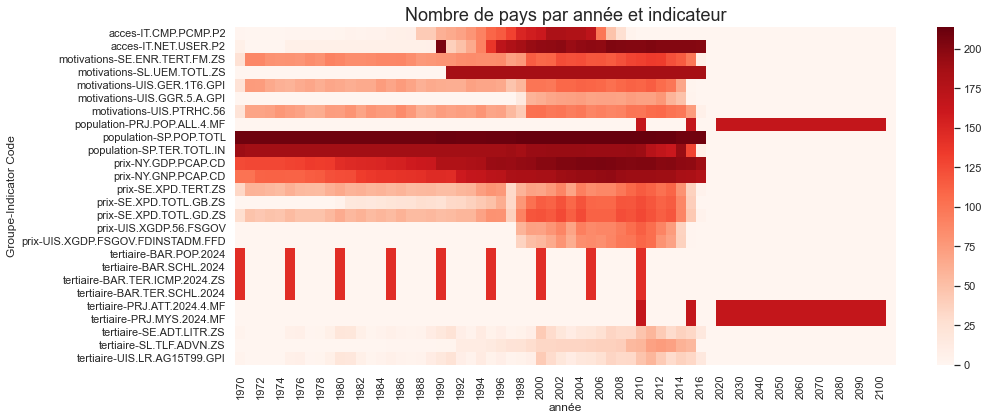

In [97]:
def merge_region(data, countries=raw_country_df):
    """ajout la colonne 'Region' au debut du dataframe"""
    if 'Region' in data.columns:
        return data
    return (
        countries[['Country Code', 'Region']]
        .merge(data, left_on='Country Code', right_on='Country Code', how='right')
    )


def drop_region(df=raw_country_df):
    """enlève la colonne region"""
    if 'Region' not in df.columns:
        return df
    return df.drop(columns={'Region'})


def merge_income_group(data, countries=raw_country_df):
    """ajout la colonne 'Income Group' au debut du dataframe"""
    if 'Income Group' in data.columns:
        return data
    return (
        countries[['Country Code', 'Income Group']]
        .merge(data, left_on='Country Code', right_on='Country Code', how='right')
    )


def drop_income_group(df=raw_country_df):
    """enlève les colonnes ajoutées par merge_income_group"""
    if 'Income Group' not in df.columns:
        return df
    return df.drop(columns={'Income Group'})


def supprime_non_pays(df=raw_country_df):
    if 'Region' not in df.columns:
        df = df.pipe(merge_region)
    return df[~df['Region'].isnull()]


pays_data_count = (raw_data_df
                   .pipe(filter_indicators, indicators=indicateurs_longlist)
                   .pipe(supprime_non_pays)
                   .pipe(plot_heatmap, annot=False)
                   )


C'est presque identique - on peut supprimer les années moins remplis


## 3.4 Sélectionne des années les plus remplis

Sélectionne les années les plus remplies, par la suppression des années moins remplies.
Des colonnes ajoutées au dataframe (ex : 'région') reste.

- supprime années avant internet : on suppose Les données avant 2010 ne sont pas pertinente à e-learning
- supprime années trop dans le futur : on suppose projections après 2040 ne sont pas pertinente


In [98]:
def drop_annees_avant_internet(df, avant=2000, debug=False):
    annees_avant_internet = list(map(str, np.arange(1970, avant)))
    filter_annees_a_supprimer = df.columns.isin(annees_avant_internet)
    colonnes_a_supprimer = df.columns[filter_annees_a_supprimer]
    colonnes_a_garder = df.columns[~filter_annees_a_supprimer]
    if debug:
        print('drop_annees_avant_internet, colonnes_a_supprimer:')
        print(list(colonnes_a_supprimer))
    return df[colonnes_a_garder]


def drop_annees_trop_dans_futur(df, apres=2040, debug=False):
    annees_trop_dans_futur = list(map(str, np.arange(apres, 2101)))
    filter_annees_a_supprimer = df.columns.isin(annees_trop_dans_futur)
    colonnes_a_supprimer = df.columns[filter_annees_a_supprimer]
    colonnes_a_garder = df.columns[~filter_annees_a_supprimer]
    if debug:
        print('drop_annees_trop_dans_futur, colonnes_a_supprimer:')
        print(list(colonnes_a_supprimer))
    return df[colonnes_a_garder]


---

## 3.5 Création d'un subset de données filtrés par indicateurs longlist pour accélerer l'analyse

Pour accélérer l'analyse, on

- supprime les colonnes vides
- supprime les données des indicateurs qui ne sont pas dans le "long list" des indicateurs selectionnés (pré-choix)
- supprime les années moins pertinentes (avant l'internet et trop dans le futur)


In [99]:
data_longlist_df = (raw_data_df
                    .pipe(drop_colonnes_vides)
                    .pipe(filter_indicators, indicators=indicateurs_longlist)
                    .pipe(drop_annees_avant_internet, avant=2010)
                    .pipe(drop_annees_trop_dans_futur, apres=2036)
                    )

print(f"Data original, Shape = {raw_data_df.shape}")
print(f"Data sélectionné pour l'analyse, Shape = {data_longlist_df.shape}")
print(', '.join(data_longlist_df.columns.tolist()))


Data original, Shape = (886930, 70)
Data sélectionné pour l'analyse, Shape = (6292, 16)
Country Name, Country Code, Indicator Name, Indicator Code, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2020, 2025, 2030, 2035


3.5.1 Combien de pays ont des données pour chaque indicateur et année


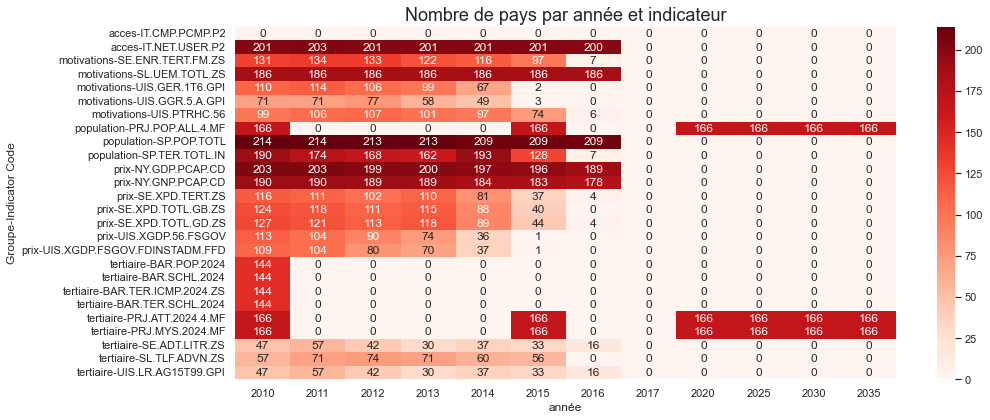

In [100]:
pays_drop_annees_count_df = (data_longlist_df
                             .pipe(supprime_non_pays)
                             .pipe(plot_heatmap))

3.5.2 Donc, beaucoup des indicateurs avec moins de 100 pays

 - il faut que les indicateurs sont présent dans les pays plus rentable


---

## 3.6 Suppression des pays avec une population petite (moins de 500,000)

Notre objectif est de vendre à beaucoup de personnes.

❔ Est-ce qu'il faut inclure les pays comme Andorre, Liechtenstein, les iles Caiman ?

- Ces pays sont fréquemment des 'outliers' en GNI per capita (paradis fiscaux)

❔ Quel sont les petits pays


In [101]:
def get_pays_petit_population(data=data_longlist_df, pop_indicator='SP.POP.TOTL', pop_limit=500000, annee='2015'):
    filter_pop_total = data['Indicator Code'] == pop_indicator
    pop_total = data[filter_pop_total]
    filtre_petit_pop = pop_total[annee] < pop_limit
    pays_petit_pop = pop_total[filtre_petit_pop]
    return pays_petit_pop


petit_pays = get_pays_petit_population(data_longlist_df)

', '.join(petit_pays['Country Name'].tolist())


'American Samoa, Andorra, Antigua and Barbuda, Aruba, Bahamas, The, Barbados, Belize, Bermuda, Brunei Darussalam, Cayman Islands, Channel Islands, Dominica, Faroe Islands, French Polynesia, Gibraltar, Greenland, Grenada, Guam, Iceland, Isle of Man, Kiribati, Liechtenstein, Maldives, Malta, Marshall Islands, Micronesia, Fed. Sts., Monaco, New Caledonia, Northern Mariana Islands, Palau, Samoa, San Marino, Sao Tome and Principe, Seychelles, St. Kitts and Nevis, St. Lucia, St. Vincent and the Grenadines, Tonga, Turks and Caicos Islands, Tuvalu, Vanuatu, Virgin Islands (U.S.)'

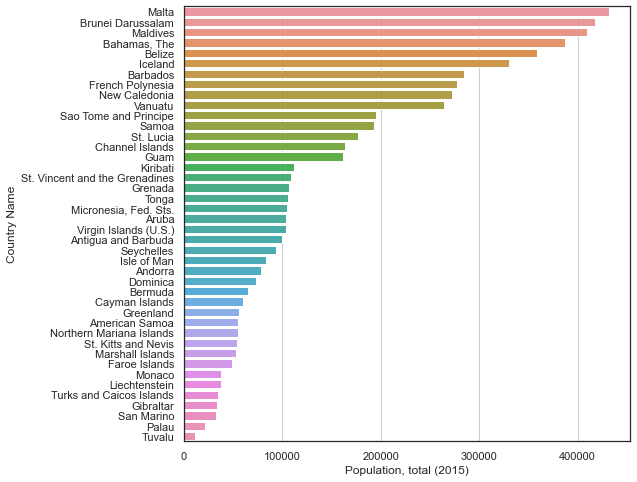

In [102]:
def nom_indicateur(indicator_code, df=raw_series_df):
    return df[df['Series Code'] == indicator_code]['Indicator Name'].tolist()[0]


def plot_bar_descending(pays, annee=2015, indicator_code=''):
    pays = pays.sort_values(by=str(annee), ascending=False)
    _, ax = plt.subplots(figsize=(8, 8))
    sns.barplot(y=pays['Country Name'], x=pays[str(annee)], orient='h', ax=ax)
    indicator_name = nom_indicateur(indicator_code)
    ax.xaxis.grid()
    ax.set_xlabel(indicator_name+' ('+str(annee)+')')


plot_bar_descending(petit_pays, 2015, 'SP.POP.TOTL')


In [103]:
def supprime_pays_petit_population(df=raw_data_df, pop_indicator='SP.POP.TOTL', pop_limit=500000, annee='2015', debug=False):
    """ supprimer le data des pays avec population < 500000"""
    pays_petit_pop = get_pays_petit_population(
        raw_data_df, pop_indicator, pop_limit, annee)
    filtre_petit_pays = df['Country Code'].isin(pays_petit_pop['Country Code'])
    if debug:
        print(
            f'supprime_pays_petit_population, count={filtre_petit_pays.sum()}')
    return df[~filtre_petit_pays]


def check_supprime_pays_petit(df):
    cpt_pays = df['Country Code'].nunique()
    print(f'nombre de pays avant: {cpt_pays}')
    df = df.pipe(supprime_pays_petit_population)
    cpt_pays = df['Country Code'].nunique()
    print(f'nombre pays apres: {cpt_pays}')


check_supprime_pays_petit(data_longlist_df.pipe(supprime_non_pays))


nombre de pays avant: 214
nombre pays apres: 173


## 3.6 Suppression des pays de bas revenu

Si la population n'ont pas un grand revenu, on ne peut pas vendre les cours a un bon prix

#### Supprime pays de bas revenu seulement pour sélection d'indicateurs

- dans l'analyse, il se peut que c'est interessant de vendre beaucoup plus dans à un prix plus bas dans un pays de grande population mais de bas revenu (ex: Chine, Brésil, Inde...)


In [104]:
def pays_faible_revenu(df=raw_country_df):
    return df[df['Income Group'].isin({'Low income', 'Lower middle income'})]


', '.join(pays_faible_revenu()['Table Name'].to_list())


"Afghanistan, Armenia, Burundi, Benin, Burkina Faso, Bangladesh, Bolivia, Bhutan, Central African Republic, Côte d'Ivoire, Cameroon, Congo, Dem. Rep., Congo, Rep., Comoros, Cabo Verde, Djibouti, Egypt, Arab Rep., Eritrea, Ethiopia, Micronesia, Fed. Sts., Georgia, Ghana, Guinea, Gambia, The, Guinea-Bissau, Guatemala, Guyana, Honduras, Haiti, Indonesia, India, Kenya, Kyrgyz Republic, Cambodia, Kiribati, Lao PDR, Liberia, Sri Lanka, Lesotho, Morocco, Moldova, Madagascar, Mali, Myanmar, Mongolia, Mozambique, Mauritania, Malawi, Niger, Nigeria, Nicaragua, Nepal, Pakistan, Philippines, Papua New Guinea, Korea, Dem. Rep., Paraguay, West Bank and Gaza, Rwanda, Sudan, Senegal, Solomon Islands, Sierra Leone, El Salvador, Somalia, South Sudan, São Tomé and Principe, Swaziland, Syrian Arab Republic, Chad, Togo, Tajikistan, Timor-Leste, Tanzania, Uganda, Ukraine, Uzbekistan, Vietnam, Vanuatu, Samoa, Kosovo, Yemen, Rep., Zambia, Zimbabwe"

In [105]:
def supprime_pays_bas_revenu(df, debug=False):
    if 'Income Group' not in df.columns:
        df = df.pipe(merge_income_group)
    filter_pays_faible_revenu = df['Income Group'].isin(
        {'Low income', 'Lower middle income'})
    filter_haut_revenu = ~filter_pays_faible_revenu
    if debug:
        print(
            f'supprime_pays_bas_revenu, count= {filter_pays_faible_revenu.sum()}')
    return df[filter_haut_revenu]


def check_supprime_pays_bas_revenu(df):
    cpt_pays = df['Country Code'].nunique()
    print(f'nombre de pays avant suppression pays bas revenu: {cpt_pays}')

    df = df.pipe(supprime_pays_bas_revenu, True)

    cpt_pays = df['Country Code'].nunique()
    print(f'nombre de pays après: {cpt_pays}')


check_supprime_pays_bas_revenu(data_longlist_df)


nombre de pays avant suppression pays bas revenu: 242
supprime_pays_bas_revenu, count= 2184
nombre de pays après: 158


## 3.7 Suppression des indicateurs sélectionnés avec peu de pays


In [106]:
pays_count2015 = (data_longlist_df
                  .dropna(subset=['2015'])
                  .pipe(supprime_non_pays)
                  .pipe(supprime_pays_petit_population)
                  .pipe(supprime_pays_bas_revenu)
                  .groupby(['Indicator Code'])
                  .agg({'Country Code': ['nunique', set]})
                  .droplevel(0, axis=1)
                  .sort_values(by='nunique', ascending=False)
                  )
pays_count2015


,nunique,set
Indicator Code,,
IT.NET.USER.P2,91,"{FRA, IRQ, TUR, MYS, NOR, IRN, AUT, LUX, SVK, HKG, CRI, POL, DEU, CUB, FJI, DZA, SRB, SGP, COL, ..."
SP.POP.TOTL,91,"{FRA, IRQ, TUR, MYS, NOR, IRN, AUT, LUX, SVK, HKG, CRI, POL, DEU, CUB, FJI, DZA, SRB, SGP, COL, ..."
SL.UEM.TOTL.ZS,91,"{FRA, IRQ, TUR, MYS, NOR, IRN, AUT, LUX, SVK, HKG, CRI, POL, DEU, CUB, FJI, DZA, SRB, SGP, COL, ..."
NY.GDP.PCAP.CD,88,"{FRA, IRQ, TUR, MYS, NOR, IRN, AUT, LUX, SVK, HKG, CRI, POL, DEU, CUB, FJI, DZA, SRB, SGP, COL, ..."
NY.GNP.PCAP.CD,87,"{FRA, IRQ, TUR, MYS, NOR, IRN, AUT, LUX, SVK, HKG, CRI, POL, DEU, FJI, DZA, SRB, SGP, COL, CAN, ..."
PRJ.ATT.2024.4.MF,86,"{FRA, IRQ, TUR, MYS, NOR, IRN, AUT, LUX, SVK, HKG, CRI, POL, DEU, CUB, DZA, SRB, SGP, COL, CAN, ..."
PRJ.MYS.2024.MF,86,"{FRA, IRQ, TUR, MYS, NOR, IRN, AUT, LUX, SVK, HKG, CRI, POL, DEU, CUB, DZA, SRB, SGP, COL, CAN, ..."
PRJ.POP.ALL.4.MF,86,"{FRA, IRQ, TUR, MYS, NOR, IRN, AUT, LUX, SVK, HKG, CRI, POL, DEU, CUB, DZA, SRB, SGP, COL, CAN, ..."
SP.TER.TOTL.IN,68,"{BEL, IRQ, COL, ECU, THA, SWE, TUR, ITA, PER, BWA, MYS, IRN, ISR, JAM, ARG, AGO, FIN, KAZ, TTO, ..."


In [107]:
indicateurs_to_keep = pays_count2015[pays_count2015['nunique'] > 50].index.tolist(
)
', '.join(indicateurs_to_keep)


'IT.NET.USER.P2, SP.POP.TOTL, SL.UEM.TOTL.ZS, NY.GDP.PCAP.CD, NY.GNP.PCAP.CD, PRJ.ATT.2024.4.MF, PRJ.MYS.2024.MF, PRJ.POP.ALL.4.MF, SP.TER.TOTL.IN, SE.ENR.TERT.FM.ZS'

In [108]:
def keep_indicateurs(df, to_keep):
    filter_to_keep = df['Indicator Code'].isin(to_keep)
    return df[filter_to_keep]


indicateurs_shortlist = (indicateurs_longlist
                         .pipe(keep_indicateurs, to_keep=indicateurs_to_keep)
                         .reset_index(drop=True))
indicateurs_shortlist


,Groupe,Indicator Name,Indicator Code
0,population,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Pos...,PRJ.POP.ALL.4.MF
1,population,"Population, total",SP.POP.TOTL
2,population,"Population of the official age for tertiary education, both sexes (number)",SP.TER.TOTL.IN
3,acces,Internet users (per 100 people),IT.NET.USER.P2
4,tertiaire,Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational ...,PRJ.ATT.2024.4.MF
5,tertiaire,Wittgenstein Projection: Mean years of schooling. Age 20-24. Total,PRJ.MYS.2024.MF
6,motivations,"Gross enrolment ratio, tertiary, gender parity index (GPI)",SE.ENR.TERT.FM.ZS
7,motivations,"Unemployment, total (% of total labor force)",SL.UEM.TOTL.ZS
8,prix,GDP per capita (current US$),NY.GDP.PCAP.CD
9,prix,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD


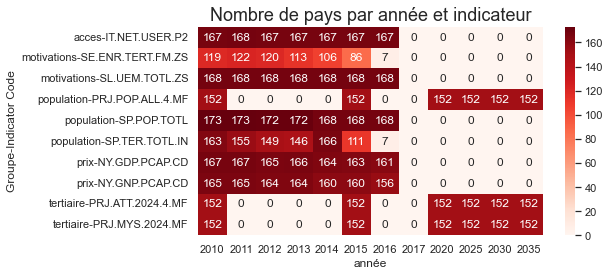

In [109]:
_, axis = plt.subplots(figsize=(9, 4))

shortlist_count_df = (raw_data_df
                      .pipe(drop_colonnes_vides)
                      .pipe(filter_indicators, indicators=indicateurs_shortlist)
                      .pipe(drop_annees_avant_internet, avant=2010)
                      .pipe(drop_annees_trop_dans_futur, apres=2036)
                      .pipe(supprime_non_pays)
                      .pipe(supprime_pays_petit_population, pop_limit=500*1000)
                      .pipe(plot_heatmap, ax=axis))


In [110]:
(shortlist_count_df.reset_index()[['Indicator Code', '2015']]
 .merge(indicateurs_longlist, how='inner', left_on='Indicator Code', right_on='Indicator Code')
 .sort_values(by=['2015'], ascending=False)
 .sort_values(by=['Groupe'], ascending=True))


,Indicator Code,2015,Groupe,Indicator Name
0,IT.NET.USER.P2,167,acces,Internet users (per 100 people)
2,SL.UEM.TOTL.ZS,168,motivations,"Unemployment, total (% of total labor force)"
1,SE.ENR.TERT.FM.ZS,86,motivations,"Gross enrolment ratio, tertiary, gender parity index (GPI)"
4,SP.POP.TOTL,168,population,"Population, total"
3,PRJ.POP.ALL.4.MF,152,population,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Pos...
5,SP.TER.TOTL.IN,111,population,"Population of the official age for tertiary education, both sexes (number)"
6,NY.GDP.PCAP.CD,163,prix,GDP per capita (current US$)
7,NY.GNP.PCAP.CD,160,prix,"GNI per capita, Atlas method (current US$)"
8,PRJ.ATT.2024.4.MF,152,tertiaire,Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational ...
9,PRJ.MYS.2024.MF,152,tertiaire,Wittgenstein Projection: Mean years of schooling. Age 20-24. Total


## 3.8 Selection des 5 indicateurs

- Un de chaque groupe pour le model
- choisi celui qui est :
  - le plus pertinente
  - le plus de données

J'ai choisi:

- `SP.POP.TOTL` (population)
- `PRJ.ATT.2024.4.MF` (secteur tertiaire)
- `IT.NET.USER.P2` (acces à e-learning)
- `SL.UEM.TOTL.ZS` (motivations)
- `NY.GNP.PCAP.CD` (prix de vente)


In [111]:
code_population = 'SP.POP.TOTL'  # (population)
code_tertiaire = 'PRJ.ATT.2024.4.MF'  # (secteur tertiaire)
code_internet = 'IT.NET.USER.P2'  # (acces à e-learning)
# code_motivation = 'SE.ENR.TERT.FM.ZS'  # (motivations)
code_motivation = 'SL.UEM.TOTL.ZS'  # (motivations)
code_prix = 'NY.GNP.PCAP.CD'  # (prix de vente)

indicateurs_to_keep = [code_population, code_tertiaire,
                       code_internet, code_motivation, code_prix]

selected_indicateurs = indicateurs_shortlist.pipe(
    keep_indicateurs, indicateurs_to_keep)

print(', '.join(selected_indicateurs['Indicator Code'].tolist()))
selected_indicateurs.set_index('Indicator Name')


SP.POP.TOTL, IT.NET.USER.P2, PRJ.ATT.2024.4.MF, SL.UEM.TOTL.ZS, NY.GNP.PCAP.CD


,Groupe,Indicator Code
Indicator Name,,
"Population, total",population,SP.POP.TOTL
Internet users (per 100 people),acces,IT.NET.USER.P2
Wittgenstein Projection: Percentage of the population age 20-24 by highest level of educational attainment. Post Secondary. Total,tertiaire,PRJ.ATT.2024.4.MF
"Unemployment, total (% of total labor force)",motivations,SL.UEM.TOTL.ZS
"GNI per capita, Atlas method (current US$)",prix,NY.GNP.PCAP.CD


---

# 4. 🔍 Analyse exploratoire<a name="analyse"></a>

[🔝](#toc)


## 4.1 Sélectionne des données à utiliser pour l'analyse <a name="analyse-selectionne"></a>

### 4.1.1 Filtre les donnees pour travailler seulement avec indicateurs, années et pays sélectionnés


In [112]:
def supprime_pays_par_code(df, code_pays=''):
    return df[~df['Country Code'].isin([code_pays])]
    
def supprime_pays_par_nom(df, nom_pays=''):
    return df[~df['Country Name'].isin([nom_pays])]

data_selected = (
    raw_data_df
    .pipe(filter_indicators, indicators=selected_indicateurs)
    .pipe(drop_colonnes_vides)
    .pipe(drop_annees_avant_internet, avant=2010)
    .pipe(drop_annees_trop_dans_futur, apres=2036)
    .pipe(merge_region)
    .pipe(supprime_non_pays)
    .pipe(supprime_pays_petit_population, pop_limit=500000)
    .pipe(supprime_pays_par_code,'CHN')
    .pipe(supprime_pays_par_code,'IND')
    .pipe(drop_region)
)


### 4.1.2 Filtre pour sélectionner les données pour une année


In [113]:
def select_annee(data=data_selected, annee=2015):
    """sélectionner seulement les données pour un année"""
    str_annee = str(annee)
    data_annee = (data
                  .pivot_table(
                      index=['Country Code', 'Country Name'],
                      columns=['Indicator Code'],
                      values=str_annee)
                  .reset_index(drop=False)
                  .rename_axis('index', axis=1)
                  .pipe(merge_income_group)
                  .pipe(merge_region)
                  )
    return data_annee


#### Données 2015 pour les 5 indicateurs selectionnées

In [114]:
data2015 = data_selected.pipe(select_annee, 2015)
print (data2015.shape)
data2015.sort_values(by=code_prix, ascending=False).head(5)


(167, 9)


,Country Code,Region,Income Group,Country Name,IT.NET.USER.P2,NY.GNP.PCAP.CD,PRJ.ATT.2024.4.MF,SL.UEM.TOTL.ZS,SP.POP.TOTL
111,NOR,Europe & Central Asia,High income: OECD,Norway,96.810300,93860.0,0.18,4.3,5188607.0
24,CHE,Europe & Central Asia,High income: OECD,Switzerland,87.479056,84570.0,0.06,4.5,8282396.0
126,QAT,Middle East & North Africa,High income: nonOECD,Qatar,92.884826,75660.0,0.13,0.2,2481539.0
89,LUX,Europe & Central Asia,High income: OECD,Luxembourg,97.334100,73530.0,0.15,6.7,569604.0
91,MAC,East Asia & Pacific,High income: nonOECD,"Macao SAR, China",77.600132,64580.0,0.21,1.8,600942.0


#### Données 2010 pour les 5 indicateurs selectionnées

In [115]:
data2010 = data_selected.pipe(select_annee, 2010)
print (data2010.shape)
data2010.sort_values(by=code_prix, ascending=False).head(5)

(171, 9)


,Country Code,Region,Income Group,Country Name,IT.NET.USER.P2,NY.GNP.PCAP.CD,PRJ.ATT.2024.4.MF,SL.UEM.TOTL.ZS,SP.POP.TOTL
113,NOR,Europe & Central Asia,High income: OECD,Norway,93.39,88440.0,0.17,3.5,4889252.0
90,LUX,Europe & Central Asia,High income: OECD,Luxembourg,90.62,78440.0,0.14,4.4,506953.0
24,CHE,Europe & Central Asia,High income: OECD,Switzerland,83.90,77360.0,0.11,4.5,7824909.0
128,QAT,Middle East & North Africa,High income: nonOECD,Qatar,69.00,66360.0,0.10,0.4,1779676.0
40,DNK,Europe & Central Asia,High income: OECD,Denmark,88.72,61220.0,0.08,7.5,5547683.0


Note: Il y a 171 pays avec données pour ces 5 indicateurs en 2010, et 167 pays en 2015

### 4.1.3 Fonctions utilitaires pour convertir entre indicator code et indicator name


In [116]:
def get_indicator_name(indicator_code, df=raw_series_df):
    if 'Series Code' in df.columns:
        names = df[df['Series Code'] ==
                   indicator_code]['Indicator Name'].tolist()
    else:
        names = df[df['Indicator Code'] ==
                   indicator_code]['Indicator Name'].tolist()
    # fonction pour label des axes - il faut retourner quelque chose:
    return indicator_code if len(names) == 0 else names[0]


def trouve_code(reg_str, df=selected_indicateurs):
    filtre = df['Indicator Name'].str.contains(
        reg_str, regex=False, case=False)
    data = df[filtre]
    if len(data) == 0:
        return None
    elif 'Indicator Code' in df.columns.tolist():
        # return data['Indicator Code'].tolist()[0]
        return df.loc[filtre, 'Indicator Code'].values[0]
    else:
        return df.loc[filtre, 'Series Code'].values[0]


# check
print(get_indicator_name('IT.NET.USER.P2'))

print(trouve_code('tertiary', df=raw_series_df))
print(trouve_code('tertiary', df=indicateurs_longlist))
print(trouve_code('tertiary', df=selected_indicateurs))
print(trouve_code('20-24', df=selected_indicateurs))


Internet users (per 100 people)
BAR.TER.CMPT.1519.FE.ZS
SP.TER.TOTL.IN
None
PRJ.ATT.2024.4.MF


### 4.1.4 Ordonner les 'Income Group' et 'Region', puis standardise les couleurs

- Facilite la lecture et comparaison des graphiques
- Utilise les mêmes couleurs dans les graphiques pour distinguer par 'Income Group' et par 'Region'


In [117]:
income_groups = raw_country_df[['Income Group']].dropna().drop_duplicates()[
    'Income Group'].tolist()

', '.join(income_groups)


'High income: nonOECD, Low income, Upper middle income, Lower middle income, High income: OECD'

In [118]:
# Trier les régions par % avec accès internet (moyenne)
region_order = data2015.groupby('Region').agg('mean').sort_values(
    by=code_internet, ascending=False).index.tolist()
region_colors = sns.color_palette("Dark2").as_hex()[:7]
# meilleur ordre visuel pour l'analyse exploratoire - copié ici
# region_palette = 'Dark2'
region_palette = dict(zip(region_order, region_colors))
region_palette


{'North America': '#1b9e77',
 'Europe & Central Asia': '#d95f02',
 'Middle East & North Africa': '#7570b3',
 'East Asia & Pacific': '#e7298a',
 'Latin America & Caribbean': '#66a61e',
 'South Asia': '#e6ab02',
 'Sub-Saharan Africa': '#a6761d'}

### 4.1.5 Box Plots : Vérifier que les indicateurs discriminent les pays <a name="analyse-region"></a>


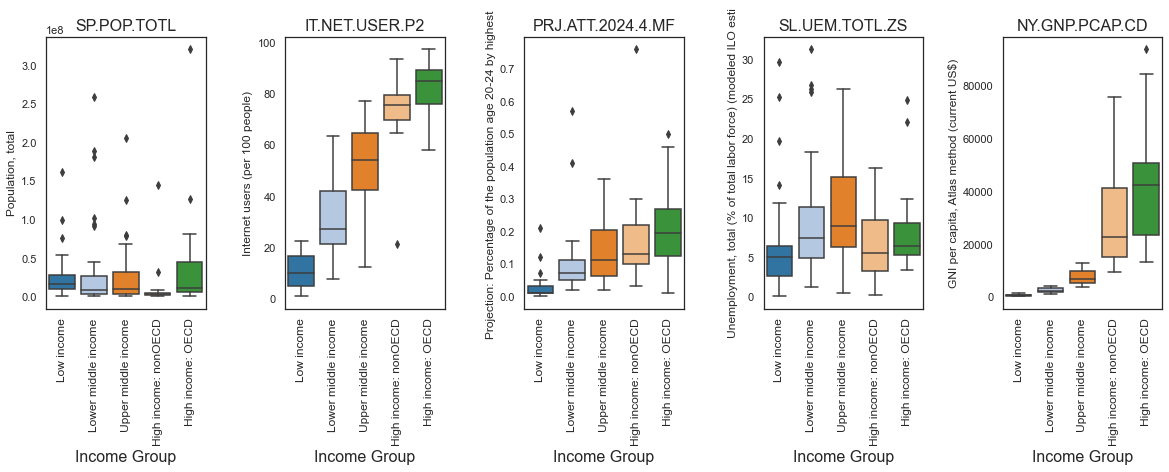

In [119]:
def boxplot_by_income_group(country_data, indicator_code, ax=None, group_order=income_group_order, palette=income_group_palette):
    if ax is None:
        _, ax = plt.subplots(figsize=(3, 5))
    box = sns.boxplot(data=country_data, y=indicator_code, ax=ax,
                      x='Income Group',  showfliers=True, order=group_order, palette=palette)
    box.set_xticklabels(group_order, rotation=90, fontsize=12)
    indicator_name = get_indicator_name(indicator_code)
    ax.set_xlabel('Income Group', size=16)
    ax.set_ylabel(indicator_name[:62], size=12)
    plt.title(label=indicator_code, size=16)


def box_plots_by_income(data, indicators):
    nrow = 1  # number of rows
    ncol = 5  # number of columns
    _, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20, 5))
    for i, indicator in enumerate(indicators):
        boxplot_by_income_group(
            data, indicator, ax=plt.subplot(nrow, ncol, i+1))
    # espace entre les plots
    plt.subplots_adjust(wspace=0.5, hspace=0.5)


indicators_shortlist = selected_indicateurs['Indicator Code'].tolist()

box_plots_by_income(data2015, indicators_shortlist)


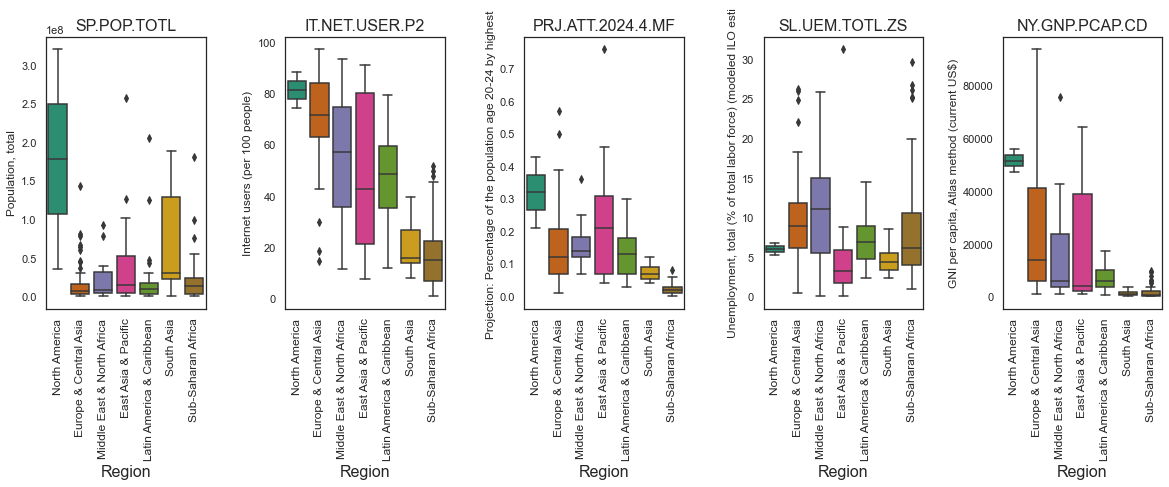

In [120]:
def boxplot_by_region(country_data, indicator_code, ax=None, group_order=region_order, palette=region_palette):
    indicator_name = get_indicator_name(indicator_code)
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))
    sns.boxplot(data=country_data, y=indicator_code, ax=ax, palette=palette,
                x='Region',  showfliers=True, order=group_order)
    ax.set_xticklabels(group_order, rotation=90, fontsize=12)
    ax.set_xlabel('Region', size=16)
    ax.set_ylabel(indicator_name[:62], size=12)
    ax.set_title(label=indicator_code, size=16)


def box_plots_by_region(data, indicators):
    nrow = 1  # number of rows
    ncol = 5  # number of columns
    _, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20, 5))
    for i, indicator in enumerate(indicators):
        boxplot_by_region(
            data, indicator, ax=plt.subplot(nrow, ncol, i+1))
    # espace entre les plots
    plt.subplots_adjust(wspace=0.5, hspace=0.5)


indicators_shortlist = selected_indicateurs['Indicator Code'].tolist()

box_plots_by_region(data2015, indicators_shortlist)


### 4.1.6 Alternative à box-plots

Box plot montre (median, interquartile range, +1.5 _ 75%quartile, -1.5_ 25%quartile)

- Avantage : moins influencé par des outliers

Alternatif est d'agréger par moyenne et écart

- Ci-dessous pour comparaison


In [121]:
def aggregate_by_region(country_data, indicator_code):
    return country_data.groupby('Region').agg({indicator_code: ['count', 'median', 'mean', 'std']})


# aggregate_by_region(data2015,indicator_code=code_internet).sort_values(by=(code_internet,'mean'),ascending=False)
aggregate_by_region(data2015, indicator_code=code_population).sort_values(
    by=(code_population, 'mean'), ascending=False)


SP.POP.TOTL                             \
                                 count       median          mean   
Region                                                              
North America                        2  178372614.0  1.783726e+08   
South Asia                           6   31196388.0  7.245459e+07   
East Asia & Pacific                 21   15517635.0  4.211436e+07   
Latin America & Caribbean           25   10528394.0  2.515386e+07   
Sub-Saharan Africa                  44   13958771.0  2.246711e+07   
Middle East & North Africa          20    9156802.0  2.142649e+07   
Europe & Central Asia               48    7730193.5  1.888586e+07   

                                          
                                     std  
Region                                    
North America               2.015594e+08  
South Asia                  8.093482e+07  
East Asia & Pacific         6.204782e+07  
Latin America & Caribbean   4.573676e+07  
Sub-Saharan Africa          3.228059e+07  
Middle East & North Africa  2.573850e+07  
Europe & Central Asia       2.839046e+07

In [122]:
data2015.groupby('Region').agg('median').sort_values(by=code_prix)


,IT.NET.USER.P2,NY.GNP.PCAP.CD,PRJ.ATT.2024.4.MF,SL.UEM.TOTL.ZS,SP.POP.TOTL
Region,,,,,
Sub-Saharan Africa,15.199127,890.0,0.02,6.20,13958771.0
South Asia,15.990809,1310.0,0.07,4.45,31196388.0
East Asia & Pacific,43.000000,4315.0,0.21,3.30,15517635.0
Middle East & North Africa,57.252096,5960.0,0.14,11.15,9156802.0
Latin America & Caribbean,48.940434,6195.0,0.13,7.00,10528394.0
Europe & Central Asia,71.715900,14155.0,0.12,9.00,7730193.5
North America,81.512101,51750.0,0.32,6.10,178372614.0


### 4.1.7 Pair Plots: Verifier s'il y a des correlations entre les indicateurs <a name="analyse-income"></a>

Si les indicateurs sont trop corrélés, cherche d'autres

- utilise seaborn pair plot pour visualiser
  - univariée (diagonale) : distribution du variable pou chaque groupe de pays (par catégorie de revenu)
  - bivariée : scatter pour voir s'il y a des correlations entre les indicateurs (par catégorie de revenu)


In [123]:
def get_pays_grand_population(data=data_longlist_df, pop_indicator='SP.POP.TOTL', pop_limit=400000000, annee='2015'):
    filter_pop_total = data['Indicator Code'] == pop_indicator
    pop_total = data[filter_pop_total]
    filtre_grand_pop = pop_total[annee] > pop_limit
    pays_grand_popln = pop_total[filtre_grand_pop]
    return pays_grand_popln


def supprime_pays_grand_population(df=data_longlist_df, pays_grand_pop=None, pop_indicator='SP.POP.TOTL', pop_limit=400000000, annee='2015', debug=False):
    """ supprimer le data des pays avec population > 400 million"""
    if pays_grand_pop is None:
        pays_grand_pop = get_pays_grand_population(
            df, pop_indicator, pop_limit, annee)
    filtre_grand_pays = df['Country Code'].isin(pays_grand_pop['Country Code'])
    if debug:
        print(
            f'supprime_pays_grand_population, count={filtre_grand_pays.sum()}')
    return df[~filtre_grand_pays]


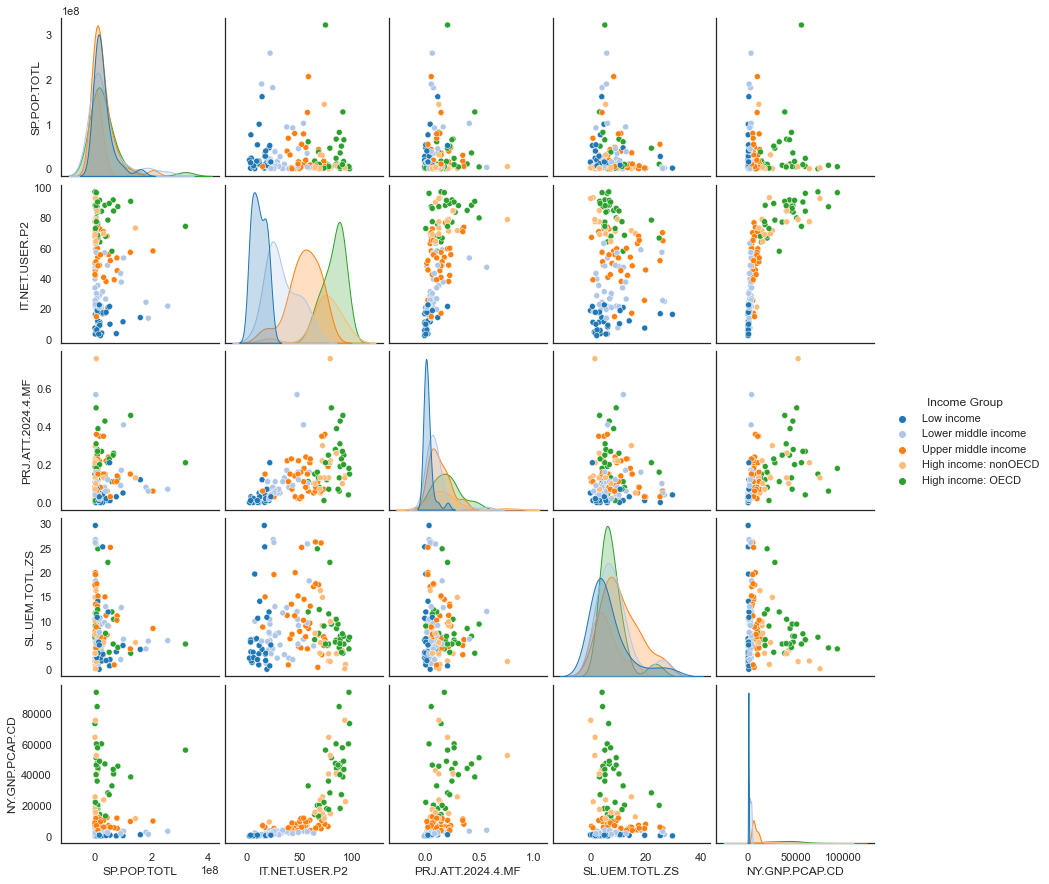

In [124]:

def plot_pairs(df, indicators=selected_indicateurs):
    subset = ['Income Group'] + indicators['Indicator Code'].tolist()
    ts = plt.rcParams['axes.titlesize']
    plt.rcParams['axes.titlesize'] = 14
    sns.pairplot(df.loc[:, subset].dropna(),
                 hue='Income Group', hue_order=income_group_order, palette=income_group_palette)
    plt.show()
    plt.rcParams['axes.titlesize'] = ts


# les pays avec < 500,000 habitants sont déjà exclu de l'analyse
# supprime les outliers de grand population (chine et inde) des pairplots
pays_grand_pop = get_pays_grand_population(
    raw_data_df, pop_limit=400*1000*1000)

(data2015
 .pipe(supprime_pays_grand_population, pays_grand_pop)
 .pipe(plot_pairs, indicators=selected_indicateurs))


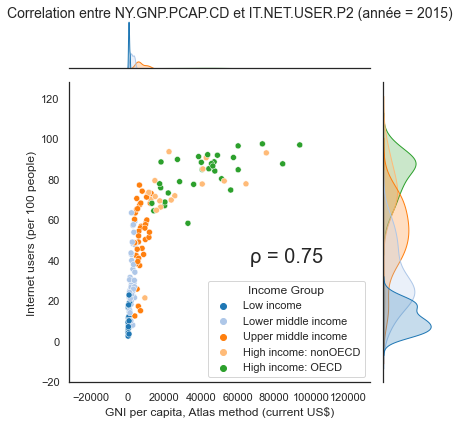

In [125]:
def plot_joint(data, x='NY.GNP.PCAP.CD', y='IT.NET.USER.P2', hue='Income Group', annee='2015'):
    data = data.dropna(subset=[x, y])
    ax = sns.jointplot(data=data, x=x, y=y, hue=hue,
                       hue_order=income_group_order, palette=income_group_palette)
    ax.ax_joint.set_xlabel(get_indicator_name(x))
    ax.ax_joint.set_ylabel(get_indicator_name(y))

    # Pearson's correlation coefficient
    r = np.corrcoef(data[x], data[y])[0][1]
    ax.ax_joint.annotate(f'ρ = {r:.2f}', xy=(.6, .4),
                         size=20, xycoords=ax.ax_joint.transAxes)

    titre = f'Correlation entre {x} et {y} (année = {annee})'
    ax.fig.suptitle(titre, fontsize=14)
    ax.fig.tight_layout()
    ax.fig.subplots_adjust(top=0.95)
    plt.show()


plot_joint(data2015, x=code_prix, y=code_internet, hue='Income Group')


#### 4.1.7.2 Projection pourcentage 20-24 en secteur tertiare vs. projection du population total ayant education post secondaire

❔ Est-ce qu'il y a un correlation entre le nombre total d'étudiants 20-24 en secteur tertiaire et le total ayant un education post secondaire

- si c'est le cas, on peut utiliser les projections (% 20-24 ans en secteur tertiaire) et (total population) pour estimer l'évolution du nombre d'étudiants potentiels


In [126]:
trouve_indicateurs('post secondary attainment population projection', not_in='male female age percentage')


,Series Code,Indicator Name,Topic
1987,PRJ.POP.ALL.4.MF,Projection: Population in thousands by highest level of educational attainment. Post Secondary. ...,Attainment


In [127]:
code_attainment = 'PRJ.POP.ALL.4.MF'
get_indicator_name(code_attainment)


'Projection: Population in thousands by highest level of educational attainment. Post Secondary. Total'

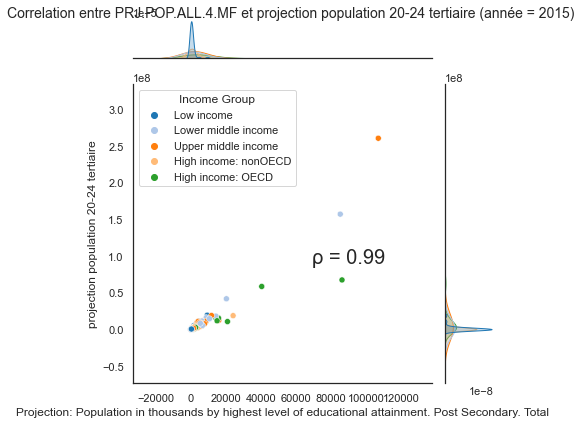

In [128]:
def analyse_attainment(df=data_longlist_df):
    df2015 = data_longlist_df.pipe(select_annee)
    code_pop2024 = 'projection population 20-24 tertiaire'
    df2015[code_pop2024] = df2015[code_population]*df2015[code_tertiaire]
    plot_joint(df2015, x=code_attainment, y=code_pop2024, hue='Income Group')


analyse_attainment()


La population (age 20-24) en secteur tertiare (code_tertiaire) est très corrélée (r=0.99) avec la population (tous ages) qui a un niveau de scolarité post-secondaire.

Donc l'indicateur selectionné (code_tertiaire, 20-24 ans) répresent bien le public ciblé (tertiare, tous âges)

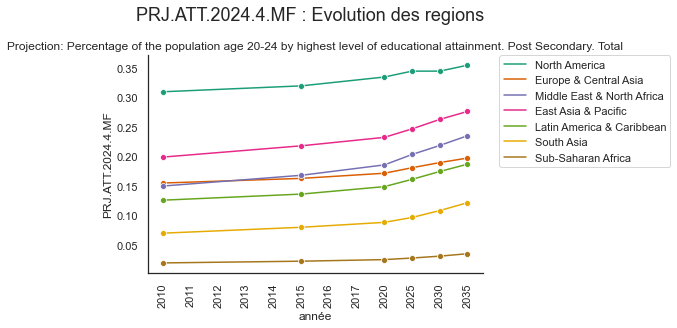

In [129]:
def plot_evolution_par_region(data=raw_data_df, indicator_code=code_internet):
    if 'Region' not in data.columns: data=data.pipe(merge_region)
    df = (data.query('`Indicator Code`==@indicator_code')
          .groupby('Region')
          .agg('mean')
          .reset_index(drop=False)
          )

    data_unpivot = pd.melt(
        df,
        id_vars=['Region'],
        var_name='année',
        value_name=indicator_code
    )
    ax = sns.lineplot(data=data_unpivot, x='année', y=indicator_code, marker='o',
                      hue='Region', palette=region_palette, hue_order=region_order)
    ax.set_ylabel(indicator_code)
    plt.suptitle(f'{indicator_code} : Evolution des regions',
                 y=1.05, fontsize=18)
    plt.title(get_indicator_name(indicator_code), fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    sns.despine()
    plt.xticks(rotation=90)
    plt.show()


# raw_data_df.pipe(plot_evolution_par_region,code_tertiaire)
data_longlist_df.pipe(plot_evolution_par_region, indicator_code=code_tertiaire)


### 4.1.8 Evolution accès internet par région


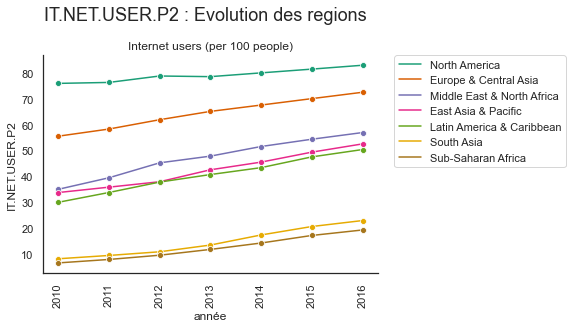

In [130]:
data_selected.pipe(plot_evolution_par_region, indicator_code=code_internet)


#### Evolution accès internet par région depuis debut de l'internet (1990)


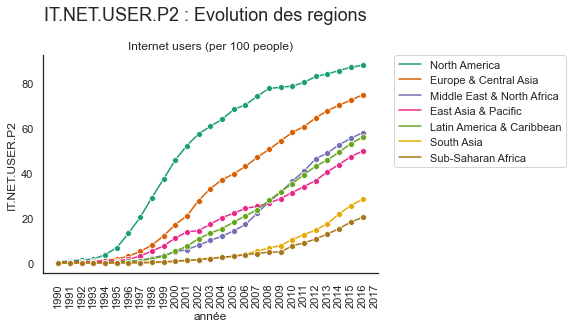

In [131]:
(raw_data_df
 .pipe(drop_annees_avant_internet, avant=1990)
 .pipe(plot_evolution_par_region, indicator_code=code_internet))


- Il semble tous les regions (sauf 'Sub-saharan africa' et 'South Asia') vont atteint accès > 90% vers 2030


## 4.2 Analyse pour chaque indicateur les n pays les plus intéressants (avec des graphiques)
<a name="analyse-pays"></a>


In [132]:

', '.join(data2015.columns.to_list())


'Country Code, Region, Income Group, Country Name, IT.NET.USER.P2, NY.GNP.PCAP.CD, PRJ.ATT.2024.4.MF, SL.UEM.TOTL.ZS, SP.POP.TOTL'

In [133]:
def plot_top_pays(data, indicator_code, nb=20, annee='2015'):
    top_pays = data.sort_values(by=indicator_code, ascending=False).head(nb)
    ax = sns.barplot(y=top_pays['Country Name'], x=top_pays[indicator_code], data=data,
                     hue='Income Group', hue_order=income_group_order, palette=income_group_palette, 
                     dodge=False)
    plt.xlabel(get_indicator_name(indicator_code))
    plt.suptitle(f'{indicator_code} : Top {nb} pays en {annee}',
                 y=1.05, fontsize=18)
    plt.title(get_indicator_name(indicator_code), fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    sns.despine()
    ax.xaxis.grid()
    plt.show()
    return top_pays.reset_index()


### 4.2.1 Population (Les top 20 pays)


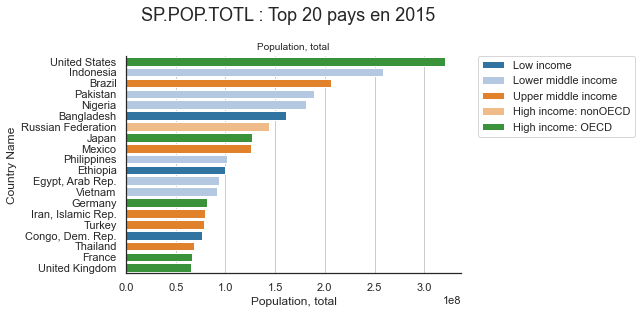

In [134]:
code_population = trouve_code('population', selected_indicateurs)
top_population = data2015.pipe(plot_top_pays, code_population)


### 4.2.2 Accès à l'internet pour e-learning (Les top 20 pays)


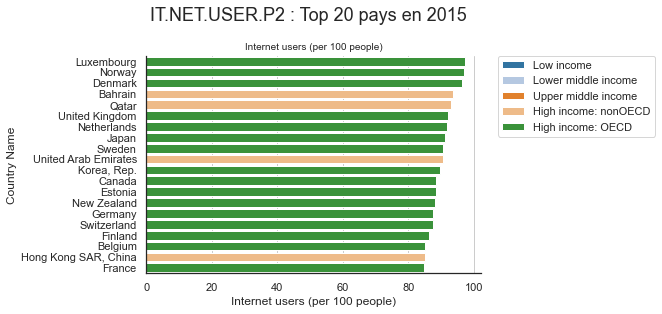

In [135]:
code_internet = trouve_code('internet')
top_internet = data2015.pipe(plot_top_pays, code_internet)


### 4.2.3 Secteur tertiaire (les top 20 pays)


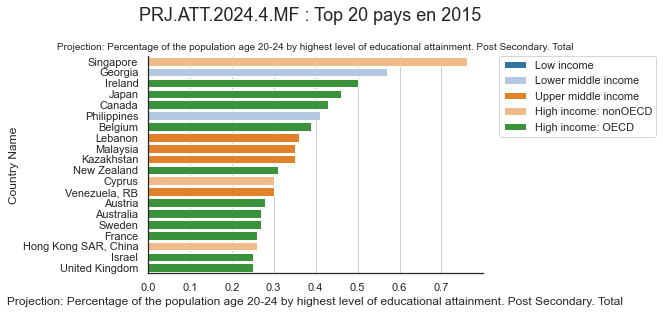

In [136]:
code_tertiaire = trouve_code('20-24')
top_tertiaire = data2015.pipe(plot_top_pays, code_tertiaire)


### 4.2.4 Incentives : facteurs motivants d'e-learning (les top 20 pays)


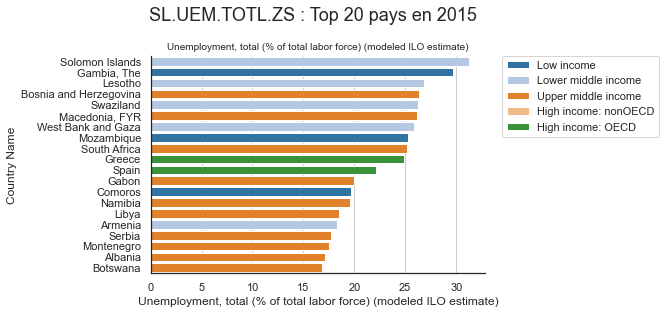

In [137]:
top_motivation = data2015.pipe(plot_top_pays, code_motivation)


Les pays avec haut chomage sont de bas revenu.

On veut que les chômeurs puissent payer (ou être payées) pour prendre les cours e-learning.

Donc, on répète sans les pays de bas revenu


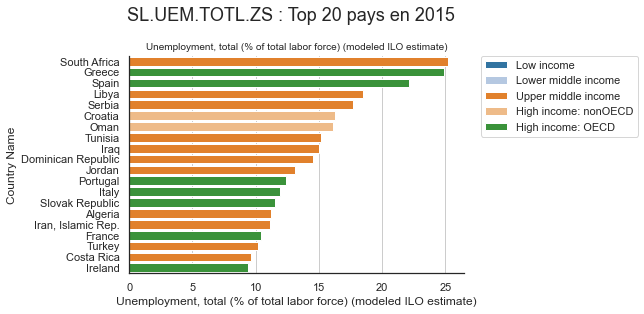

In [138]:
top_motivation2 = (data2015
                   .pipe(supprime_pays_petit_population, pop_limit=4000000)
                   .pipe(supprime_pays_bas_revenu)
                   .pipe(plot_top_pays, code_motivation))


### 4.2.5 Prix de vente (les top pays)


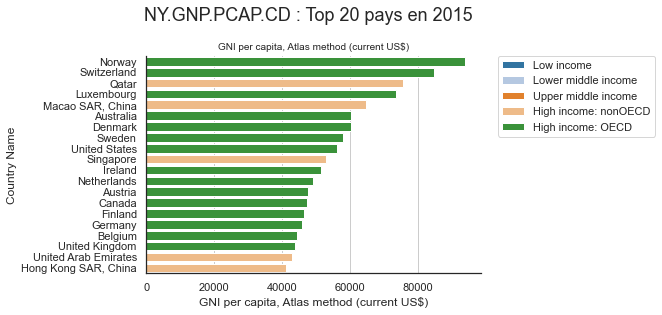

In [139]:
code_prix = trouve_code('GNI')
top_prix = data2015.pipe(plot_top_pays, code_prix)


## 4.3 Évolution des indicateurs choisis pour les pays les plus intéressants<a name="analyse-top-pays"></a>


In [140]:
def plot_evolution_indicateur(data, indicator_code, selected_pays=None, nb_pays=10, logscale=False):
    data = data.pipe(drop_income_group).pipe(drop_region)
    if selected_pays is None:
        selected_pays = (data[data['Indicator Code'] == indicator_code]
                         .sort_values(by='2015', ascending=False)).dropna(subset=['2015'])
    nb_pays = min(len(selected_pays), nb_pays)
    top_pays = selected_pays.head(nb_pays)
    country_order = top_pays['Country Name'].tolist()
    filter_pays = data['Country Code'].isin(top_pays['Country Code'])
    filter_indicator = data['Indicator Code'] == indicator_code
    data_top_pays_indicator = data[filter_pays & filter_indicator]
    data_unpivot = pd.melt(
        data_top_pays_indicator,
        id_vars=['Country Name', 'Country Code',
                 'Indicator Name', 'Indicator Code'],
        var_name='année',
        value_name=indicator_code
    )
    palette = 'tab10' if nb_pays < 11 else 'tab20'
    ax = sns.lineplot(x='année', y=indicator_code, hue='Country Name', palette=palette,
                      data=data_unpivot, marker='o', hue_order=country_order)
    if logscale:
        ax.set_yscale('log')
    ax.set_ylabel(indicator_code)
    plt.suptitle(f'{indicator_code} : Evolution des top {nb_pays} pays', y=1.05, fontsize=18)
    plt.title(get_indicator_name(indicator_code), fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    sns.despine()
    plt.show()


### 4.3.1 Evolution de la population - Top 10 pays


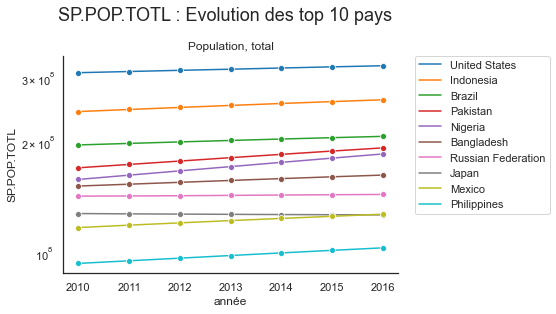

In [141]:
plot_evolution_indicateur(data_selected, indicator_code=code_population,
                          selected_pays=top_population, logscale=True)


### 4.3.2 Evolution d'accès à l'internet - Top 10 pays


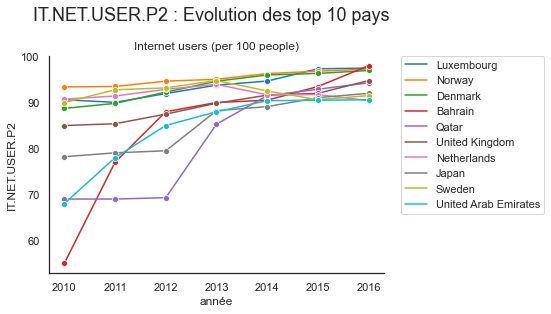

In [142]:
plot_evolution_indicateur(data_selected, indicator_code=code_internet)


### 4.3.3 Evolution du secteur tertiaire - Top 10 pays


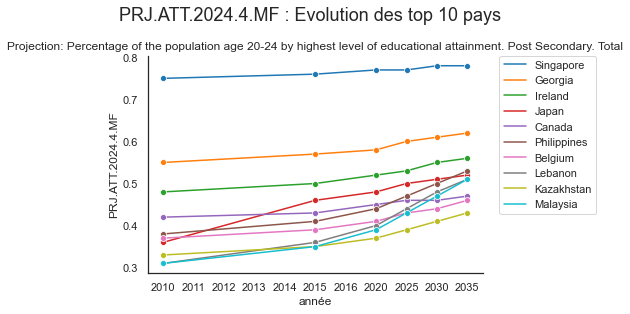

In [143]:
plot_evolution_indicateur(data_selected, indicator_code=code_tertiaire)


### 4.3.4 Evolution des facteurs motivants d'e-learning - Top 10 pays


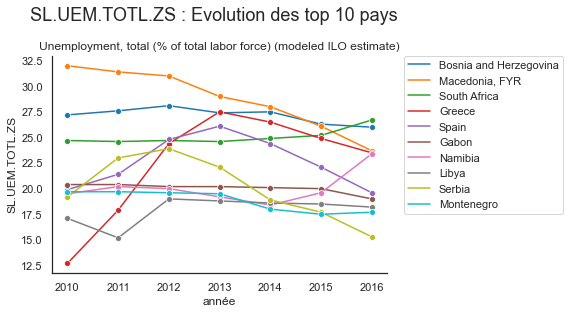

In [144]:
(data_selected
 .pipe(supprime_pays_bas_revenu)
 .pipe(plot_evolution_indicateur, indicator_code=code_motivation))


### 4.3.5 Evolution du prix - Top 10 pays


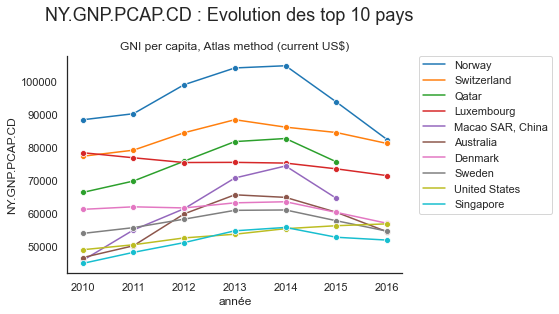

In [145]:
plot_evolution_indicateur(data_selected, indicator_code=code_prix)


---

## 4.4 Model pour une première sélection des pays<a name="selection-model"></a>


### Model original proposé (pour une année donnée)

<b>{ PROFIT } = { POPULATION } x { % AVEC ACESS } x { % SECTEUR TERTIAIRE } x { MOTIVATION A E-LEARNING } x { PRIX DE VENTE }</b>


### Model modifie pour prendre en compte les indicateurs choisis

<b>{ NOMBRE_ÉTUDIANTS } = </b>

<b> alpha \* { POPULATION } \* { % AVEC ACESS } \* { % SECTEUR TERTIAIRE }</b>

<b> + beta \* { POPULATION } \* { % AVEC ACESS } \* { MOTIVATION A E-LEARNING }) </b>

- alpha: % de la population du secteur tertiaire avec internet qui choisi notre entreprise
- beta: contribution des motivations à étudier

<b> { PRIX DE VENTE } = gamma \* { REVENU_ETUDIANT }</b>

- gamma: % du revenu que l'etudiant trouve acceptable à payer

### Mesures de performance: "Profit", "Revenu Total" et "Revenu par habitant"

<b>{ PROFIT } = { REVENU } - { DEPENSES } </b>


Le calcul du profit dépend du business model:
- Un business model sans grands dépenses par étudiant --> maximiser revenu total
- Un business model avec grands dépenses par étudiant --> maximiser revenu par étudiant

Si les couts de production, marketing, administration pour un pays est indépendent du nombre d'etudiants, on sera mieux de maximiser le revenu total:

<b>{ REVENU_TOTAL } = { NOMBRE_ÉTUDIANTS } \* { PRIX DE VENTE }</b>

_Ci-dessous je calcule les estimats de revenu (avant deduction de dépenses) en millions de US Dollars_


Si les dépenses de marketing et administration sont proportionnelles au nombre d'étudiants prix en charge, on cherche à maximiser le revenu par 1000 habitants ciblés. 
- Exemple: couts signicatifs pour le suivi et mentorat des étudiants

<b>{ REVENU_1000_HABITANTS } = { NOMBRE_ÉTUDIANTS } \* { PRIX DE VENTE } / { POPULATION PAYS } * 1000 </b>

_Ci-dessous je calcule des estimats de revenu par 1000 habitants en US dollars_


In [146]:
data2015.columns


Index(['Country Code', 'Region', 'Income Group', 'Country Name',
       'IT.NET.USER.P2', 'NY.GNP.PCAP.CD', 'PRJ.ATT.2024.4.MF',
       'SL.UEM.TOTL.ZS', 'SP.POP.TOTL'],
      dtype='object')

In [147]:
codes_shortlist = (code_population, code_internet,
                   code_tertiaire, code_motivation, code_prix)


def estimation_nb_etudiants(df, alpha=0.01, beta=0, colonnes=codes_shortlist):
    """
     alpha= percent du marché (entre 0 et 100%)
    # beta = facteur de motivation (entre 0 et 100%)
    exemple: 
    1% de population de 1 million * 90% accès internet * 40% code tertiare
    = (0.01 * 0.9 * 0.4 ) million étudiants
    = 0.0036 * 1 000 000
    = 3.6 * 1000
    = 3,600 étudiants
    """
    (code_population, code_internet, code_tertiaire,
     code_motivation, code_prix) = colonnes
    # rappel: divise par 100 seulement si la valeur/colonne est un pourcentage 0 à 100
    df = df.assign(nb_etudiants=lambda x: round(
        (alpha/100 * x[code_population] *
         x[code_internet]/100 * x[code_tertiaire])
        + (beta/100 * x[code_population] *
           x[code_internet]/100 * x[code_motivation]/100)
    )
    )
    return df


In [148]:

def estimation_prix_de_vente(df, gamma=0.05, colonne_revenu=code_prix):
    """
    gamma = % du revenu que l'etudiant payera pour e-learning
    si revenu = 1000 USD par mois, on suppose l'etudiant peux payé jusqu'à 50 USD
    50 / 1000 = 5%
    prix de vente 
    """
    df = df.assign(prix_de_vente=lambda x: round(
        gamma/100 * x[colonne_revenu]))
    return df


In [149]:

def estimation_revenu_million_euros(df):
    return df.assign(revenu=lambda x: round(x['nb_etudiants']*x['prix_de_vente']/1000000))


def estimation_revenu_par_mille_habitants(df,colonne_population=code_population):
    return df.assign(revenu_1000_habitants=lambda x: x['nb_etudiants']*x['prix_de_vente']/x[colonne_population]*1000)


def estimate_revenu(df, alpha=0.05, beta=0.01, gamma=0.05, colonnes=codes_shortlist):
    (code_population, code_internet, code_tertiaire,
     code_motivation, code_prix) = colonnes
    return (df
            .pipe(estimation_nb_etudiants, alpha, beta, colonnes)
            .pipe(estimation_prix_de_vente, gamma, colonne_revenu=code_prix)
            .pipe(estimation_revenu_par_mille_habitants, colonne_population = code_population)
            .pipe(estimation_revenu_million_euros))


#### Choix des valeurs pour alpha, beta et gamma

- **alpha** = % de la population du secteur tertiaire avec internet qui choisi notre entreprise
- **beta** = influence des motivations à étudier sur la population qui fait d'e-learning (0 à 100, à déterminer)
  - si code_motivation == "% chômage", alors beta est le pourcentage de chômeurs que décide de faire d'e-learning
  - code_motivation peut représenter ruralité, parité femme/homme, ...
- **gamma** = % du revenu que l'étudiant peut payer


In [150]:
def top_pays_revenu(df, nb_pays=10):
    return df.sort_values(by='revenu', ascending=False).head(nb_pays)

def top_pays_revenu_par_1000_habitants(df, nb_pays=10):
    return df.sort_values(by='revenu_1000_habitants', ascending=False).head(nb_pays)

def reorder_colonnes(df, codes_shortlist=codes_shortlist):
    colonnes = (['Country Code', 'Country Name', 'nb_etudiants', 'prix_de_vente', 'revenu','revenu_1000_habitants']
               + list(codes_shortlist))
    return df[colonnes]

def top_pays(df, per_habitant=True, nb_pays=10, percent_marche=0.01, facteur_motivations=0, percent_revenu=0.05, codes=codes_shortlist):
    revenu_function = top_pays_revenu_par_1000_habitants if per_habitant else top_pays_revenu
    sort_colonne = 'revenu_1000_habitants' if per_habitant else 'revenu'
    return (df
            .pipe(estimate_revenu, alpha=percent_marche, beta=facteur_motivations, gamma=percent_revenu, colonnes=codes)
            .pipe(revenu_function, nb_pays=nb_pays)
            .pipe(reorder_colonnes)
            .sort_values(by=sort_colonne, ascending=False)
            .reset_index(drop=True)
            .rename_axis('rank')
            .reset_index(drop=False)
            )


In [151]:
def list_pays(df, titre=''):
    titre = titre + " : " if len(titre) > 0 else ""
    print(titre + ', '.join(df['Country Name'].tolist()))

def sommaire(df):
    return df.style.set_precision(0)
    #.format(precision=2,subset=code_tertiaire)


---

# 5. 💡 Conclusion <a name="conclusion"></a>
[🔝](#toc)

## 5.1 Quels sont les pays avec un fort potentiel de clients pour nos services ?

On suppose que:

1. On peut adapter le prix de vente de nos services aux revenus des clients dans chaque pays
2. On n'est pas limité par la langue du pays


### 5.1.1 Scenario A : Cibler les 20-24 ans qui suivent des études tertiaires

- Suppose que le nombre de ventes est proportionnelle au nombre de personnes 20-24 ans suivant des études
- Ignorer autres facteurs que peuvent inciter les personnes hors du secteur tertiaire à choisir e-learning


In [152]:
scenario_A = dict(percent_marche=0.1, facteur_motivations=0, percent_revenu=2)

# Business Model 1
scenario_A_2015_total_population = (data2015.pipe(top_pays, per_habitant=False, **scenario_A))
scenario_A_2010_total_population = (data2010.pipe(top_pays, per_habitant=False, **scenario_A))

# Business Model 2
scenario_A_2015_per_habitant = (data2015.pipe(top_pays, per_habitant=True, **scenario_A))
scenario_A_2010_per_habitant = (data2010.pipe(top_pays, per_habitant=True, **scenario_A))

In [153]:
# Business Model 1, sommaire pour 2015
scenario_A_2015_total_population.pipe(sommaire)

,rank,Country Code,Country Name,nb_etudiants,prix_de_vente,revenu,revenu_1000_habitants,SP.POP.TOTL,IT.NET.USER.P2,PRJ.ATT.2024.4.MF,SL.UEM.TOTL.ZS,NY.GNP.PCAP.CD
0,0,USA,United States,50241,1125,57,176,320896618,75,0,5,56250
1,1,JPN,Japan,53255,776,41,325,127141000,91,0,3,38780
2,2,CAN,Canada,13638,945,13,360,35848610,88,0,7,47250
3,3,GBR,United Kingdom,14980,874,13,201,65128861,92,0,5,43720
4,4,FRA,France,14671,815,12,179,66624068,85,0,10,40730
5,5,DEU,Germany,9301,916,9,104,81686611,88,0,5,45790
6,6,AUS,Australia,5431,1207,7,276,23789338,85,0,6,60330
7,7,KOR,"Korea, Rep.",10519,545,6,112,51014947,90,0,4,27250
8,8,SGP,Singapore,3324,1055,4,634,5535002,79,1,2,52740
9,9,ESP,Spain,7675,568,4,94,46447697,79,0,22,28420


In [154]:
# Business Model 2, sommaire pour 2015
scenario_A_2015_per_habitant.pipe(sommaire)

,rank,Country Code,Country Name,nb_etudiants,prix_de_vente,revenu,revenu_1000_habitants,SP.POP.TOTL,IT.NET.USER.P2,PRJ.ATT.2024.4.MF,SL.UEM.TOTL.ZS,NY.GNP.PCAP.CD
0,0,SGP,Singapore,3324,1055,4,634,5535002,79,1,2,52740
1,1,IRL,Ireland,1874,1026,2,411,4676835,80,0,9,51290
2,2,CAN,Canada,13638,945,13,360,35848610,88,0,7,47250
3,3,NOR,Norway,904,1877,2,327,5188607,97,0,4,93860
4,4,JPN,Japan,53255,776,41,325,127141000,91,0,3,38780
5,5,BEL,Belgium,3740,887,3,294,11274196,85,0,8,44340
6,6,SWE,Sweden,2397,1155,3,283,9799186,91,0,7,57760
7,7,AUS,Australia,5431,1207,7,276,23789338,85,0,6,60330
8,8,AUT,Austria,2029,952,2,224,8633169,84,0,6,47610
9,9,NZL,New Zealand,1257,805,1,220,4595700,88,0,5,40250


In [155]:
# Comparaison Business Models 1 et 2 (pour 2015 e 2010)
scenario_A_2015_total_population.pipe(list_pays)
scenario_A_2010_total_population.pipe(list_pays)

scenario_A_2015_per_habitant.pipe(list_pays)
scenario_A_2010_per_habitant.pipe(list_pays);

United States, Japan, Canada, United Kingdom, France, Germany, Australia, Korea, Rep., Singapore, Spain
United States, Japan, United Kingdom, France, Canada, Germany, Korea, Rep., Australia, Spain, Netherlands
Singapore, Ireland, Canada, Norway, Japan, Belgium, Sweden, Australia, Austria, New Zealand
Singapore, Ireland, Canada, Norway, Belgium, Japan, Sweden, Luxembourg, Austria, Netherlands


#### Business Model 1 : Maximiser revenu total, cibler les 20-24 ans qui suivent des études tertiaires :
- 2015 (top 10 pays) : United States, Japan, Canada, United Kingdom, France, Germany, Australia, Korea, Rep., Singapore, Spain
- 2010 (top 10 pays) : United States, Japan, United Kingdom, France, Canada, Germany, Korea, Rep., Australia, Spain, Netherlands

Note: Les top 7 pays sont les mêmes pour 2010 et 2015.

#### Business Model 2 : Maximiser revenu par 1000 habitants, cibler les 20-24 ans qui suivent des études tertiaires : 
- 2015 (top 10 pays) : Singapore, Ireland, Canada, Norway, Japan, Belgium, Sweden, Australia, Austria, New Zealand
- 2010 (top 10 pays) : Singapore, Ireland, Canada, Norway, Belgium, Japan, Sweden, Luxembourg, Austria, Netherlands

Note: Les top 7 pays sont les mêmes pour 2010 et 2015.



### 5.1.2 Scenario B : Cibler les personnes de haut niveau d'éducation qui cherche à se former ou recycler

Favoriser légèrement les pays ou le chômage est haut (motivation à recycler)


In [156]:
scenario_B = dict(percent_marche=0.1, facteur_motivations=0.9, percent_revenu=2)

# Business Model 3
scenario_B_2015_total_population = (data2015.pipe(top_pays, per_habitant=False, **scenario_B))
scenario_B_2010_total_population = (data2010.pipe(top_pays, per_habitant=False, **scenario_B))

# Business Model 4
scenario_B_2015_per_habitant = (data2015.pipe(top_pays, per_habitant=True, **scenario_B))
scenario_B_2010_per_habitant = (data2010.pipe(top_pays, per_habitant=True, **scenario_B))


In [157]:
# Business Model 3, sommaire pour 2015
scenario_B_2015_total_population.pipe(sommaire)

,rank,Country Code,Country Name,nb_etudiants,prix_de_vente,revenu,revenu_1000_habitants,SP.POP.TOTL,IT.NET.USER.P2,PRJ.ATT.2024.4.MF,SL.UEM.TOTL.ZS,NY.GNP.PCAP.CD
0,0,USA,United States,164359,1125,185,576,320896618,75,0,5,56250
1,1,JPN,Japan,88681,776,69,541,127141000,91,0,3,38780
2,2,FRA,France,67487,815,55,826,66624068,85,0,10,40730
3,3,ESP,Spain,80372,568,46,983,46447697,79,0,22,28420
4,4,GBR,United Kingdom,43561,874,38,585,65128861,92,0,5,43720
5,5,DEU,Germany,38923,916,36,436,81686611,88,0,5,45790
6,6,CAN,Canada,33333,945,31,879,35848610,88,0,7,47250
7,7,ITA,Italy,41701,659,27,453,60730582,58,0,12,32970
8,8,BRA,Brazil,99110,202,20,97,205962108,58,0,8,10080
9,9,AUS,Australia,16475,1207,20,836,23789338,85,0,6,60330


In [158]:
# Business Model 4, sommaire pour 2015
scenario_B_2015_per_habitant.pipe(sommaire)

,rank,Country Code,Country Name,nb_etudiants,prix_de_vente,revenu,revenu_1000_habitants,SP.POP.TOTL,IT.NET.USER.P2,PRJ.ATT.2024.4.MF,SL.UEM.TOTL.ZS,NY.GNP.PCAP.CD
0,0,IRL,Ireland,5044,1026,5,1107,4676835,80,0,9,51290
1,1,LUX,Luxembourg,417,1471,1,1077,569604,97,0,7,73530
2,2,NOR,Norway,2848,1877,5,1030,5188607,97,0,4,93860
3,3,ESP,Spain,80372,568,46,983,46447697,79,0,22,28420
4,4,SWE,Sweden,8311,1155,10,980,9799186,91,0,7,57760
5,5,CAN,Canada,33333,945,31,879,35848610,88,0,7,47250
6,6,BEL,Belgium,11075,887,10,871,11274196,85,0,8,44340
7,7,AUS,Australia,16475,1207,20,836,23789338,85,0,6,60330
8,8,FRA,France,67487,815,55,826,66624068,85,0,10,40730
9,9,SGP,Singapore,3993,1055,4,761,5535002,79,1,2,52740


In [159]:
# Comparaison Business Models 3 et 4 (pour 2015 e 2010)
scenario_B_2015_total_population.pipe(list_pays)
scenario_B_2010_total_population.pipe(list_pays)

scenario_B_2015_per_habitant.pipe(list_pays)
scenario_B_2010_per_habitant.pipe(list_pays);

United States, Japan, France, Spain, United Kingdom, Germany, Canada, Italy, Brazil, Australia
United States, Japan, France, Germany, United Kingdom, Spain, Canada, Italy, Brazil, Australia
Ireland, Luxembourg, Norway, Spain, Sweden, Canada, Belgium, Australia, France, Singapore
Ireland, Sweden, Spain, Denmark, Canada, Belgium, Norway, Luxembourg, United States, France


#### Business Model 3 : Maximiser revenu total, cibler les personnes qui cherche à se former ou recycler: 
- 2015 (top 10 pays) : United States, Japan, France, Spain, United Kingdom, Germany, Canada, Italy, Brazil, Australia
- 2010 (top 10 pays) : United States, Japan, France, Germany, United Kingdom, Spain, Canada, Italy, Brazil, Australia

- Les top 10 pays sont les mêmes en 2010 et 2015 sous cette scenario
- Italy et Brazil remplace Korea et Singapore dans la liste du top 10 pays (comparé à Business Model 1)

#### Business Model 4 : Maximiser revenu par 1000 habitants, cibler les personnes qui cherche à se former ou recycler: 
- 2015 (top 10 pays) : Ireland, Luxembourg, Norway, Spain, Sweden, Canada, Belgium, Australia, France, Singapore
- 2010 (top 10 pays) : Ireland, Sweden, Spain, Denmark, Canada, Belgium, Norway, Luxembourg, United States, France



### 5.1.3 Scenario C : Cibler les pays de haut revenu où le chomage est bas

Dans l'hypothèse que le facteur motivation (ici, la chômage) est en fait un facteur négatif:
- si le chomage est bas, il aura peut-etre une demande pour employées à se former car on ne trouve pas les personnes qualifiées
- si le chomage est haut, fréquemment c'est accompagné par un baisse des prix de vente / pouvoir d'achat 

In [160]:
scenario_C = dict (percent_marche=0.1, facteur_motivations=-0.2, percent_revenu=2)

# Business Model 5
scenario_C_2015_total_population = (data2015.pipe(top_pays, per_habitant=False, **scenario_C))
scenario_C_2010_total_population = (data2010.pipe(top_pays, per_habitant=False, **scenario_C))

# Business Model 6
scenario_C_2015_per_habitant = (data2015.pipe(top_pays, per_habitant=True, **scenario_C))
scenario_C_2010_per_habitant = (data2010.pipe(top_pays, per_habitant=True, **scenario_C))



In [161]:
# Business Model 5, sommaire pour 2015
scenario_C_2015_total_population.pipe(sommaire)


,rank,Country Code,Country Name,nb_etudiants,prix_de_vente,revenu,revenu_1000_habitants,SP.POP.TOTL,IT.NET.USER.P2,PRJ.ATT.2024.4.MF,SL.UEM.TOTL.ZS,NY.GNP.PCAP.CD
0,0,JPN,Japan,45383,776,35,277,127141000,91,0,3,38780
1,1,USA,United States,24881,1125,28,87,320896618,75,0,5,56250
2,2,CAN,Canada,9261,945,9,244,35848610,88,0,7,47250
3,3,GBR,United Kingdom,8628,874,8,116,65128861,92,0,5,43720
4,4,KOR,"Korea, Rep.",7226,545,4,77,51014947,90,0,4,27250
5,5,AUS,Australia,2977,1207,4,151,23789338,85,0,6,60330
6,6,SGP,Singapore,3175,1055,3,605,5535002,79,1,2,52740
7,7,DEU,Germany,2719,916,2,30,81686611,88,0,5,45790
8,8,FRA,France,2934,815,2,36,66624068,85,0,10,40730
9,9,BEL,Belgium,2110,887,2,166,11274196,85,0,8,44340


In [162]:
# Business Model 6, sommaire pour 2015
scenario_C_2015_per_habitant.pipe(sommaire)

,rank,Country Code,Country Name,nb_etudiants,prix_de_vente,revenu,revenu_1000_habitants,SP.POP.TOTL,IT.NET.USER.P2,PRJ.ATT.2024.4.MF,SL.UEM.TOTL.ZS,NY.GNP.PCAP.CD
0,0,SGP,Singapore,3175,1055,3,605,5535002,79,1,2,52740
1,1,JPN,Japan,45383,776,35,277,127141000,91,0,3,38780
2,2,IRL,Ireland,1169,1026,1,256,4676835,80,0,9,51290
3,3,CAN,Canada,9261,945,9,244,35848610,88,0,7,47250
4,4,QAT,Qatar,290,1513,0,177,2481539,93,0,0,75660
5,5,MAC,"Macao SAR, China",81,1292,0,174,600942,78,0,2,64580
6,6,NOR,Norway,472,1877,1,171,5188607,97,0,4,93860
7,7,BEL,Belgium,2110,887,2,166,11274196,85,0,8,44340
8,8,AUS,Australia,2977,1207,4,151,23789338,85,0,6,60330
9,9,NZL,New Zealand,819,805,1,143,4595700,88,0,5,40250


In [163]:
# Comparaison Business Models 5 et 6 (pour 2015 e 2010)
scenario_C_2015_total_population.pipe(list_pays)
scenario_C_2010_total_population.pipe(list_pays)

scenario_C_2015_per_habitant.pipe(list_pays)
scenario_C_2010_per_habitant.pipe(list_pays);

Japan, United States, Canada, United Kingdom, Korea, Rep., Australia, Singapore, Germany, France, Belgium
Japan, Canada, United Kingdom, Korea, Rep., Belgium, Netherlands, Singapore, France, United States, Australia
Singapore, Japan, Ireland, Canada, Qatar, Macao SAR, China, Norway, Belgium, Australia, New Zealand
Singapore, Canada, Japan, Norway, Belgium, Ireland, Austria, Australia, Netherlands, Qatar


#### Business Model 5 : Maximiser revenu total, cibler les pays haut revenu et bas chomage : : 
- 2015 (top 10 pays) : Japan, United States, Canada, United Kingdom, Korea, Rep., Australia, Singapore, Germany, France, Belgium
- 2010 (top 10 pays) : Japan, Canada, United Kingdom, Korea, Rep., Belgium, Netherlands, Singapore, France, United States, Australia

Note: les top 10 pays sont presque identique pour 2010 et 2015 pour cette scenario: Germany remplace Netherlands en 2015

#### Business Model 6 : Maximiser revenu par 1000 habitants, cibler les pays haut revenu et bas chomage : 
- 2015 (top 10 pays) : Singapore, Japan, Ireland, Canada, Qatar, Macao SAR, China, Norway, Belgium, Australia, New Zealand
- 2010 (top 10 pays) : Singapore, Canada, Japan, Norway, Belgium, Ireland, Austria, Australia, Netherlands, Qatar




### 5.1.4 Sélection des candidat pays avec fort potentiel 

#### Est-ce qu'on peut utilisé les données de 2015 pour faire le choix ?

Les 6 simulations (pour 2015, 2010) ci-dessus montre que le choix de candidat pays est fortement influencié par le business model, mais reste assez constante pour chaque Business Model entre 2015 et 2010. 

Donc, on peut basée notre choix sur les données de 2015

#### Quel business model pour faire le choix ?

Idéalement, les candidat pays ont un fort potentiel, avac ou sans le personnes en chomage / reconversion (qui peut fluctuer fortement dans les prochaines années, comme le taux d'echange et couts des cours)



- Pour choisir les pays entre autant de scenarios, il est preferable de choisir les pays qui reste le plus souvent dans les top 10 pays sous chaque scenario
- Un mèthode de choisir entre candidats est la "Borda Count" (utilisé pour des élections):

  1. Pour chaque scenario à inclure dans le comptage Borda: Donne 10 points au premier pays, 9 au pays en deuxieme place,... 1 au pays en dixième place, et 0 pour les autres pays 

  2. Somme les points pour chaque pays, pour arriver un ranking des pays pour un ensemble de scenarios

In [164]:
#rappel des colonnes
scenario_A_2010_per_habitant.head(2)

,rank,Country Code,Country Name,nb_etudiants,prix_de_vente,revenu,revenu_1000_habitants,SP.POP.TOTL,IT.NET.USER.P2,PRJ.ATT.2024.4.MF,SL.UEM.TOTL.ZS,NY.GNP.PCAP.CD
0,0,SGP,Singapore,2703.0,896.0,2.0,477.05650,5076732.0,71.00,0.75,3.1,44790.0
1,1,IRL,Ireland,1529.0,895.0,1.0,300.08958,4560155.0,69.85,0.48,13.9,44760.0


In [165]:

def borda_count(dataframes, nb_pays=10):
    borda_df = pd.concat(dataframes, axis=0, ignore_index=True)
    # print (f'borda shape = {borda_df.shape}')
    borda_df = borda_df[['Country Code', 'Country Name',
                         'rank', 'revenu_1000_habitants', 'revenu']]
    borda_df['borda'] = 10-borda_df['rank']

    ret = (borda_df
            .groupby(by=['Country Code', 'Country Name'], axis=0)
            .agg({
                'borda': 'sum',
                'rank' : ['min', 'max'],
                'revenu_1000_habitants' : 'mean',
                'revenu': 'mean' 
            })
            .sort_values(by=[('borda', 'sum')], ascending=False)
            .head(nb_pays)
            .reset_index (drop=False)
            .rename_axis('rank')
    )
    return ret


#### Meilleur ranking basé sur le revenu par 1000 habitants 

- Borda count sur l'ensemble de rankings per habitant, scénarios A, B et C, pour 2015
- mix de Business Models 1, 3 et 5
- revenu par 1000 habitant dans la table est la moyenne des scénarios
  - si c'est dans la même ordre que la borda count - ça indique que les rankings sur chaque scenario ne change pas enormement 

In [166]:
pays_ranking_per_habitant = borda_count([
    scenario_A_2015_per_habitant,
    scenario_B_2015_per_habitant,
    scenario_C_2015_per_habitant,
    ])

pays_ranking_per_habitant.style.set_precision(0)


#### Meilleur ranking basé sur la population total du pays
- ensemble de rankings pour la population total, scénarios A, B et C, pour 2015
- mix de Business Models 2, 4 et 6

In [167]:
pays_ranking_pop_total = borda_count([
    scenario_A_2015_total_population,
    scenario_B_2015_total_population,
    scenario_C_2015_total_population,
    ])
 
pays_ranking_pop_total.style.set_precision(0)

#### Meilleur ranking basé sur un mix de scenarios A et B pour 2015

In [168]:
pays_ranking_2015 = borda_count([
    scenario_A_2015_total_population,
    scenario_B_2015_total_population,
    scenario_A_2015_per_habitant,
    scenario_B_2015_per_habitant,
    ])

scenario_A_2015_total_population.pipe(list_pays, 'Business Model 1')
scenario_A_2015_per_habitant.pipe(list_pays, 'Business Model 2')
scenario_B_2015_total_population.pipe(list_pays, 'Business Model 3')
scenario_B_2015_per_habitant.pipe(list_pays, 'Business Model 4')


pays_ranking_2015.style.set_precision(0)

Business Model 1 : United States, Japan, Canada, United Kingdom, France, Germany, Australia, Korea, Rep., Singapore, Spain
Business Model 2 : Singapore, Ireland, Canada, Norway, Japan, Belgium, Sweden, Australia, Austria, New Zealand
Business Model 3 : United States, Japan, France, Spain, United Kingdom, Germany, Canada, Italy, Brazil, Australia
Business Model 4 : Ireland, Luxembourg, Norway, Spain, Sweden, Canada, Belgium, Australia, France, Singapore


In [169]:
pays_ranking_2015_et_2010 =borda_count([
    scenario_A_2015_total_population,
    scenario_B_2015_total_population,
    scenario_A_2015_per_habitant,
    scenario_B_2015_per_habitant,
    scenario_A_2010_total_population,
    scenario_B_2010_total_population,
    scenario_A_2010_per_habitant,
    scenario_B_2010_per_habitant,
])

pays_ranking_2015_et_2010.style.set_precision(0)

### Pays avec fort potentiel (heuristique):
- dans top 7 pays en 2015 pour le Business Model 1, 2, 3, et 4
- 2015: Pays dans Model 1 dans top 7 pays pour Model 3 (et vice versa) (avec et sans chomeurs)
- 2015: Pays dans Model 2 dans top 7 pays pour Model 4 (et vice versa) (avec et sans chomeurs)


In [170]:
def pays_en_top7(df1,df2):
    '''retourne les pays dans les top 7 pays de df1 et df2'''
    filtre = df1.head(7)['Country Code'].isin(df2.head(7)['Country Code'])
    return df1.head(7)[filtre]

pays_ranking_2015 = borda_count([
    scenario_A_2015_total_population.pipe(pays_en_top7, scenario_B_2015_total_population),
    scenario_B_2015_total_population.pipe(pays_en_top7, scenario_A_2015_total_population),
    scenario_A_2015_per_habitant.pipe(pays_en_top7, scenario_B_2015_per_habitant),
    scenario_B_2015_per_habitant.pipe(pays_en_top7, scenario_A_2015_per_habitant)
])
pays_ranking_2015

Country Code    Country Name borda rank     revenu_1000_habitants revenu
                                    sum  min max                  mean   mean
rank                                                                         
0             CAN          Canada    25    2   6            619.097853   22.0
1             USA   United States    20    0   0            376.172553  121.0
2             IRL         Ireland    19    0   1            758.832416    3.5
3             JPN           Japan    18    1   1            433.150345   55.0
4             NOR          Norway    15    2   3            678.650744    3.5
5             FRA          France    14    2   4            502.511870   33.5
6             GBR  United Kingdom    13    3   4            392.796935   25.5
7             DEU         Germany    10    5   5            270.382034   22.5
8             SWE          Sweden    10    4   6            631.059559    6.5
9             BEL         Belgium     9    5   6            582.786790    6.5

### Pays choisis avec un fort potentiel

In [171]:
pays_choisis = pays_ranking_2015.droplevel(level=1, axis=1)
pays_choisis.pipe(list_pays)
nb_choisis=len(pays_choisis)

Canada, United States, Ireland, Japan, Norway, France, United Kingdom, Germany, Sweden, Belgium


## 5.2 Pour chacun de ces pays, quelle sera l’évolution de ce potentiel de clients ?<a name="conclusion-evolution"></a>

On re-analyse pour les pays du scénario choisi :

- evolution de la population
- evolution d'accès à l'internet
- evolution du secteur tertiaire
- evolution des facteurs motivant d'e-learning (eg. chômage)
- evolution du revenu (qui affecte prix de vente)


### Evolution de la population total 

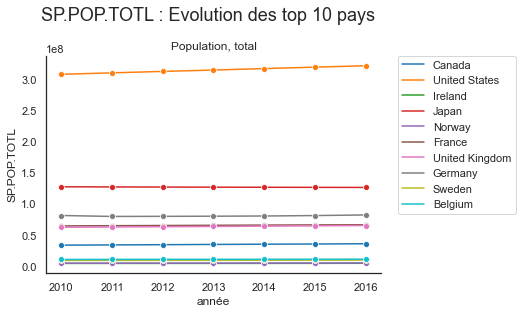

In [172]:
plot_evolution_indicateur(
    data_selected, code_population, selected_pays=pays_choisis, nb_pays=nb_choisis)


### Evolution de l'accès à Internet

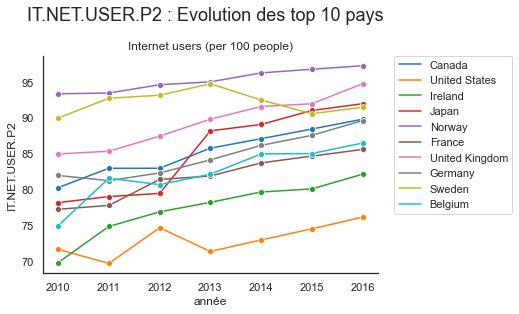

In [173]:
plot_evolution_indicateur(data_selected, code_internet,
                          selected_pays=pays_choisis, nb_pays=nb_choisis)


- Spain et Brazil montre un croissance plus vite d'accès à l'internet que d'autre pays
- Surprenant que 26% de la population de United States n'a pas internet en 2016

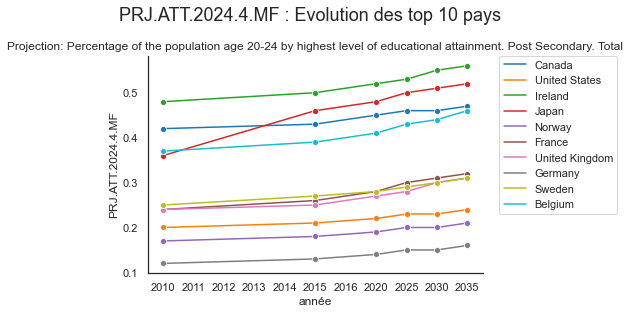

In [174]:
plot_evolution_indicateur(data_selected, code_tertiaire,
                          selected_pays=pays_choisis, nb_pays=nb_choisis)


- tous les pays selectionnés ont d'augmention de la proportion de la population qui fait des études tertiaires

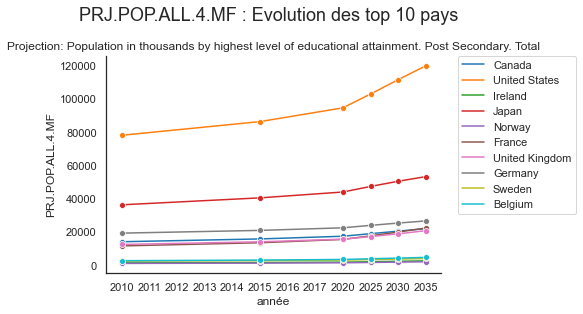

In [175]:
plot_evolution_indicateur(data_longlist_df, 'PRJ.POP.ALL.4.MF', selected_pays=pays_choisis, nb_pays=nb_choisis)

Cette indicateur n'était pas sélectionné, car 

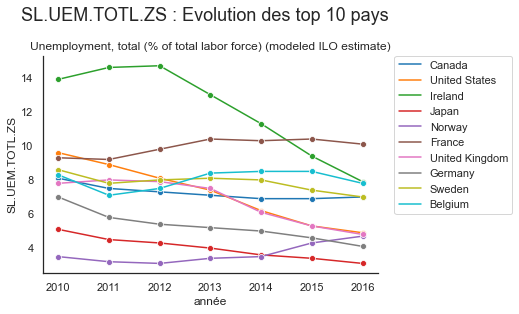

In [176]:
plot_evolution_indicateur(
    data_selected, code_motivation, selected_pays=pays_choisis, nb_pays=nb_choisis)


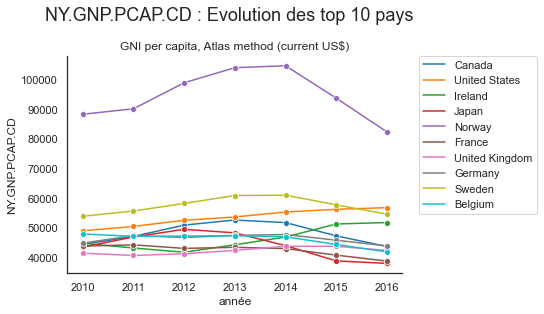

In [177]:
plot_evolution_indicateur(data_selected, code_prix, selected_pays=pays_choisis, nb_pays=nb_choisis)


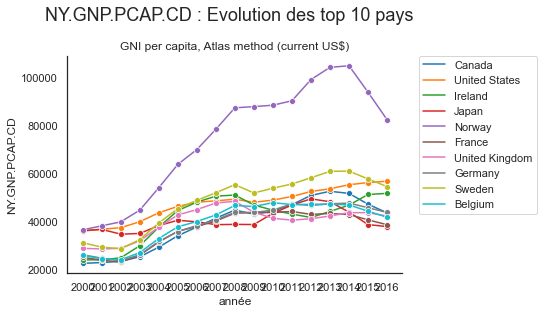

In [178]:
(raw_data_df
 .pipe(drop_annees_avant_internet, avant=2000)
 .pipe(plot_evolution_indicateur,code_prix, selected_pays=pays_choisis, nb_pays=nb_choisis))


## 5.3 Dans quels pays l'entreprise doit-elle opérer en priorité ?<a name="conclusion-priorite"></a>

En éliminant Chine (trop fermé politiquement), et Inde (trop bas GNI per capita):

### Scenario A:
- Dépend de la choix de vendre à beaucoup de clients moins cher (Udemy) ou moins de clients mais plus suivi (OpenClassrooms):
  - prioritiser le nombre de clients : [United States, Japan, Canada, United Kingdom] 
  - prioritiser un haut prix : [United States, Canada, Germany, United Kingdom, Japan] 
  - prioritiser la langue anglaise : [Canada, United States, Ireland, United Kingdom]

### Scenario B:
- Si on considere que la taux de chômage est un facteur de motivation dans les pays ou il y a un grand pourcentage de la population avec un haut niveau d'education, comme c'est le cas en France, on peut aussi cibler: [Spain, Italy, Brazil]  


In [179]:
def filter_pays(data,pays=pays_choisis):
    filter_pays = data['Country Code'].isin(pays_choisis['Country Code'])
    return data[filter_pays]

data2015_pays_choisis = data2015.pipe(filter_pays, pays_choisis)

In [180]:
scenario_A = dict(percent_marche=0.1, facteur_motivations=0, percent_revenu=2)
scenario_B = dict(percent_marche=0.1, facteur_motivations=0.9, percent_revenu=2)

# Business Model 1
Business_Model_1_revenu_total = (data2015_pays_choisis.pipe(top_pays, per_habitant=False, **scenario_A))

# Business Model 2
Business_Model_2_revenu_per_habitant = (data2015_pays_choisis.pipe(top_pays, per_habitant=True, **scenario_A))

# Business Model 3
Business_Model_3_revenu_total = (data2015_pays_choisis.pipe(top_pays, per_habitant=False, **scenario_B))

# Business Model 4
Business_Model_4_revenu_per_habitant = (data2015_pays_choisis.pipe(top_pays, per_habitant=True, **scenario_B))

In [181]:
Business_Model_1_revenu_total.style.set_precision(0)

,rank,Country Code,Country Name,nb_etudiants,prix_de_vente,revenu,revenu_1000_habitants,SP.POP.TOTL,IT.NET.USER.P2,PRJ.ATT.2024.4.MF,SL.UEM.TOTL.ZS,NY.GNP.PCAP.CD
0,0,USA,United States,50241,1125,57,176,320896618,75,0,5,56250
1,1,JPN,Japan,53255,776,41,325,127141000,91,0,3,38780
2,2,CAN,Canada,13638,945,13,360,35848610,88,0,7,47250
3,3,GBR,United Kingdom,14980,874,13,201,65128861,92,0,5,43720
4,4,FRA,France,14671,815,12,179,66624068,85,0,10,40730
5,5,DEU,Germany,9301,916,9,104,81686611,88,0,5,45790
6,6,BEL,Belgium,3740,887,3,294,11274196,85,0,8,44340
7,7,SWE,Sweden,2397,1155,3,283,9799186,91,0,7,57760
8,8,IRL,Ireland,1874,1026,2,411,4676835,80,0,9,51290
9,9,NOR,Norway,904,1877,2,327,5188607,97,0,4,93860


In [182]:
Business_Model_2_revenu_per_habitant.style.set_precision(0)

,rank,Country Code,Country Name,nb_etudiants,prix_de_vente,revenu,revenu_1000_habitants,SP.POP.TOTL,IT.NET.USER.P2,PRJ.ATT.2024.4.MF,SL.UEM.TOTL.ZS,NY.GNP.PCAP.CD
0,0,IRL,Ireland,1874,1026,2,411,4676835,80,0,9,51290
1,1,CAN,Canada,13638,945,13,360,35848610,88,0,7,47250
2,2,NOR,Norway,904,1877,2,327,5188607,97,0,4,93860
3,3,JPN,Japan,53255,776,41,325,127141000,91,0,3,38780
4,4,BEL,Belgium,3740,887,3,294,11274196,85,0,8,44340
5,5,SWE,Sweden,2397,1155,3,283,9799186,91,0,7,57760
6,6,GBR,United Kingdom,14980,874,13,201,65128861,92,0,5,43720
7,7,FRA,France,14671,815,12,179,66624068,85,0,10,40730
8,8,USA,United States,50241,1125,57,176,320896618,75,0,5,56250
9,9,DEU,Germany,9301,916,9,104,81686611,88,0,5,45790


In [183]:
Business_Model_3_revenu_total.style.set_precision(0)

,rank,Country Code,Country Name,nb_etudiants,prix_de_vente,revenu,revenu_1000_habitants,SP.POP.TOTL,IT.NET.USER.P2,PRJ.ATT.2024.4.MF,SL.UEM.TOTL.ZS,NY.GNP.PCAP.CD
0,0,USA,United States,164359,1125,185,576,320896618,75,0,5,56250
1,1,JPN,Japan,88681,776,69,541,127141000,91,0,3,38780
2,2,FRA,France,67487,815,55,826,66624068,85,0,10,40730
3,3,GBR,United Kingdom,43561,874,38,585,65128861,92,0,5,43720
4,4,DEU,Germany,38923,916,36,436,81686611,88,0,5,45790
5,5,CAN,Canada,33333,945,31,879,35848610,88,0,7,47250
6,6,BEL,Belgium,11075,887,10,871,11274196,85,0,8,44340
7,7,SWE,Sweden,8311,1155,10,980,9799186,91,0,7,57760
8,8,IRL,Ireland,5044,1026,5,1107,4676835,80,0,9,51290
9,9,NOR,Norway,2848,1877,5,1030,5188607,97,0,4,93860


In [184]:
Business_Model_4_revenu_per_habitant.style.set_precision(0)

,rank,Country Code,Country Name,nb_etudiants,prix_de_vente,revenu,revenu_1000_habitants,SP.POP.TOTL,IT.NET.USER.P2,PRJ.ATT.2024.4.MF,SL.UEM.TOTL.ZS,NY.GNP.PCAP.CD
0,0,IRL,Ireland,5044,1026,5,1107,4676835,80,0,9,51290
1,1,NOR,Norway,2848,1877,5,1030,5188607,97,0,4,93860
2,2,SWE,Sweden,8311,1155,10,980,9799186,91,0,7,57760
3,3,CAN,Canada,33333,945,31,879,35848610,88,0,7,47250
4,4,BEL,Belgium,11075,887,10,871,11274196,85,0,8,44340
5,5,FRA,France,67487,815,55,826,66624068,85,0,10,40730
6,6,GBR,United Kingdom,43561,874,38,585,65128861,92,0,5,43720
7,7,USA,United States,164359,1125,185,576,320896618,75,0,5,56250
8,8,JPN,Japan,88681,776,69,541,127141000,91,0,3,38780
9,9,DEU,Germany,38923,916,36,436,81686611,88,0,5,45790


## 5.4 Améliorations / études à faire

- Mieux comprendre le business model:
 
  - quel sont les raisons pour lequels les étudiants font le choix de e-learning
    - cout moins cher que l'université traditionelle
    - ruralité (manque d'accès)
    - inegalité d'opportunités pour les femmes
    - retour au marché du travail (après chomage/enfants/maladie)
    - reconversions (satisfaction)

 - marché ciblé dans chaque pays 
    - prix mondiale, ou par pays?

  - dépenses de l'entreprise (couts de traduction, mentorat, impots)
    - rester dans euro zone?
  